In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Input
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import time as tm

Using Theano backend.


In [15]:
select_domain  = 0 #0:apnea ro 1:obesity
domain = ['apnea','obesity']
root = '../linkPrediction/'
filepath=[['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv'],
        ['dataset/obesity-all,3.csv',
         'dataset/obesity-distinct_keyword.csv']]
graphpath=root+'graphs/'+domain[select_domain]
datapath=root+'dataframes/'+domain[select_domain]
modelpath=root+'models/'+domain[select_domain]
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
times=[2007,2008,2015,1,1,200]
df, key_list = ut.load_dataset(filepath[select_domain], column_split)

In [16]:
# time=[1991,1992,1994,1,1,20]
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, times)

../linkPrediction/graphs/apnea\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
../linkPrediction/graphs/apnea\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
../linkPrediction/graphs/apnea\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
../linkPrediction/graphs/apnea\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
../linkPrediction/graphs/apnea\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
../linkPrediction/graphs/apnea\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
../linkPrediction/graphs/apnea\train_graph_2014.gpickle loaded, nodes: 583 edges: 1144
../linkPrediction/graphs/apnea\test_graph_2015.gpickle loaded, nodes: 1093 edges: 2019
../linkPrediction/graphs/apnea\parent_graph_2007-2008.gpickle loaded, nodes: 388 edges: 689
../linkPrediction/graphs/apnea\train_graph_2008-2015.gpickle loaded, nodes: 1093 edges: 5142
../linkPrediction/graphs/apnea\test_graph_2015-2016.gpickle loaded, nodes: 1093 edges: 2019


In [17]:
importlib.reload(ut)
train_data = ut.load_data(datapath, domain[select_domain], "train_data", times)
node_feature = ut.load_data(datapath, domain[select_domain], "node_feature", times)
edge_list = ut.load_data(datapath, domain[select_domain], "edge_list", times)
test_data = ut.load_data(datapath, domain[select_domain], "test_data", times)
test_node = ut.load_data(datapath, domain[select_domain], "test_node", times)
print('train data length:',len(train_data))
print('node feature length:',len(node_feature))
print('edge_list length:',len(edge_list))
print('test_data length:',len(test_data[2015]))
print('test_node length:',len(test_node[2015]))

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
train data length: 7
node feature length: 7
edge_list length: 12494
test_data length: 12494
test_node length: 1093


In [18]:
s_key={0:[9875,1020],1:[7614,9953]}
for t in range(2008,2015):
    g_train[t].remove_nodes_from(s_key[select_domain])
g_test[2015].remove_nodes_from(s_key[select_domain])
g_parent.remove_nodes_from(s_key[select_domain])
g_train_static.remove_nodes_from(s_key[select_domain])
g_test_static.remove_nodes_from(s_key[select_domain])

In [19]:
test_node[2015]

,node_index,y_weight,term_art,term_aut,term_af1,term_af2,term_coun,closeness,degree,citation,degrees,node_type_aut,node_type_art,node_type_deg
0,7218,1,0.700949,0.379414,-1.215046,-0.820928,-0.370452,0.193241,2,38,0.018519,3,3,3
1,14408,1,3.614369,2.936313,3.145723,2.828505,2.742535,0.252554,22,66,0.203704,5,5,5
2,13880,1,3.072535,2.257045,2.089515,2.025526,2.892028,0.215971,15,48,0.138889,3,3,3
3,11601,1,0.523367,-0.001531,1.300971,-0.123124,-5.022255,0.166781,3,2,0.027778,3,3,3
4,13912,1,0.939074,0.793199,1.279161,0.099309,-3.052839,0.213733,3,0,0.027778,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,13827,1,-2.316267,-0.976235,-2.676468,-0.891141,-1.018547,0.000916,1,1,0.009259,1,1,1
1089,1138,1,0.374695,0.149918,0.120104,0.079677,-0.432329,0.207637,3,0,0.027778,5,5,5
1090,16014,1,0.374695,0.149918,0.120104,0.079677,-0.432329,0.207637,3,0,0.027778,5,5,5
1091,6032,1,-0.393156,-0.542765,-0.137003,-0.981454,-0.403052,0.170129,2,2,0.018519,3,3,3


In [10]:
# time=[1991,1992,1994,1,1,20]
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, times)

../linkPrediction/graphs/apnea\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
../linkPrediction/graphs/apnea\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
../linkPrediction/graphs/apnea\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
../linkPrediction/graphs/apnea\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
../linkPrediction/graphs/apnea\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
../linkPrediction/graphs/apnea\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
../linkPrediction/graphs/apnea\train_graph_2014.gpickle loaded, nodes: 583 edges: 1144
../linkPrediction/graphs/apnea\test_graph_2015.gpickle loaded, nodes: 1093 edges: 2019
../linkPrediction/graphs/apnea\parent_graph_2007-2008.gpickle loaded, nodes: 388 edges: 689
../linkPrediction/graphs/apnea\train_graph_2008-2015.gpickle loaded, nodes: 1093 edges: 5142
../linkPrediction/graphs/apnea\test_graph_2015-2016.gpickle loaded, nodes: 1093 edges: 2019


In [11]:
s_key={0:[9875,1020],1:[7614,9953]}
for t in range(2008,2015):
    g_train[t].remove_nodes_from(s_key[select_domain])
g_test[2015].remove_nodes_from(s_key[select_domain])
g_parent.remove_nodes_from(s_key[select_domain])
g_train_static.remove_nodes_from(s_key[select_domain])
g_test_static.remove_nodes_from(s_key[select_domain])

In [20]:
for t in range(2008,2015):
    g=g_train[t]
    print(t,'nodes:',len(g.nodes()),'edges:',len(g.edges()))
print(2007,'nodes:',len(g_parent.nodes()),'edges:',len(g_parent.edges()))
print(2015,'nodes:',len(g_test[2015].nodes()),'edges:',len(g_test[2015].edges()))

2008 nodes: 459 edges: 773
2009 nodes: 470 edges: 688
2010 nodes: 496 edges: 786
2011 nodes: 536 edges: 977
2012 nodes: 584 edges: 1054
2013 nodes: 634 edges: 1280
2014 nodes: 583 edges: 1144
2007 nodes: 388 edges: 689
2015 nodes: 1093 edges: 2019


In [8]:
def reshape(train_data, node_feature, edge_list, test_data,test_node,times,features):
    cat ={25:0,5:1,3:2,1:3}
    ts = times[1]
    te = times[2]+1
    it_index = times[4]
    times_range = te - ts
    total_sample = len(edge_list)
    train_data[times[2]] = test_data
    node_feature[times[2]] = test_node
    feature_length = len(features['edge'])+32
    X = np.zeros([total_sample, times_range, feature_length])
    y = np.zeros(total_sample)
    print("X shape:", X.shape, "y shape:", y.shape)
    for id, edge in enumerate(edge_list):
        for t in range(ts, te, it_index):
            t_data = train_data[t]
            n_data = node_feature[t]
            node_list = set(n_data['node_index'])
            edge_list_t = set(t_data['row_name'])
            if edge in edge_list_t:
                train_row = np.asarray(t_data.loc[t_data['row_name'] == edge,features['edge']].values[0])
                X[id][t - ts][0:6] = train_row
                X[id][t - ts][3] = X[id][t - ts][3]*(t-ts+1)*2
            if edge[0] in node_list:
                node_row0 = np.asarray(n_data.loc[n_data['node_index'] == edge[0],features['node']].values[0])
                X[id][t - ts][6:9] = node_row0[0:3]
                X[id][t - ts][cat[node_row0[3]]+9] = 1
                X[id][t - ts][cat[node_row0[4]]+13] = 1
                X[id][t - ts][cat[node_row0[5]]+17] = 1
                X[id][t - ts][21] = node_row0[6]
                if edge[1] not in node_list:
                    X[id][t - ts][3] = node_row0[6]*(t-ts+1)
            if edge[1] in node_list:
                node_row1 = np.asarray(n_data.loc[n_data['node_index'] == edge[1],features['node']].values[0])
                X[id][t - ts][22:25] = node_row1[0:3]
                X[id][t - ts][cat[node_row1[3]]+25] = 1
                X[id][t - ts][cat[node_row1[4]]+29] = 1
                X[id][t - ts][cat[node_row1[5]]+33] = 1
                X[id][t - ts][37] = node_row1[6]
                if edge[0] not in node_list:
                    X[id][t - ts][3] = node_row1[6]*(t-ts+1)
        y[id] = test_data.loc[test_data['row_name'] == edge,'label'].values[0]
    return X, y

In [38]:
node_feature[2008].head()

,node_index,y_weight,term_art,term_aut,term_af1,term_af2,term_coun,closeness,degree,citation,degrees,node_type_aut,node_type_art,node_type_deg
0,7943,1,3.563167,3.278160,3.063238,2.763745,3.011017,0.345861,54,861,0.154286,5,5,5
1,9516,1,-0.402686,0.632127,0.203748,0.164155,-0.198249,0.251092,4,47,0.011429,3,3,3
2,1511,1,0.325682,-0.688074,-0.557940,-0.495598,-1.313288,0.266475,5,38,0.014286,5,5,5
3,2459,1,1.994278,1.723824,1.637934,1.417986,1.122538,0.307244,16,113,0.045714,5,5,5
4,4347,1,2.711948,2.788349,2.448573,2.219458,2.465206,0.320385,47,433,0.134286,5,5,5


In [39]:
features = [{'node':['term_aut','node_type_aut'],
           'edge':['typeaut']},
           {'node':['term_art','node_type_art'],
           'edge':['typeart']},
           {'node':['degree','node_type_deg'],
           'edge':['typenode']},
           {'node':['citation'],
           'edge':['citation1']},
           {'node':['degree'],
           'edge':['pref']},
           {'node':['degree'],
           'edge':['cm']}]

In [40]:
#####################  6           7        8       9,10,11,12     13,14,15,16      17,18,19,20      21
#####################  22          23       24      25,26,27,28    29,30,31,32      33,34,35,36      37
feature = {'node':['term_aut','term_art','degree','node_type_aut','node_type_art','node_type_deg','citation'],
           'edge':['typeaut','typeart','typenode','citation1','pref','cm']}
################       0         1         2           3        4      5

start = tm.time()
X, y = reshape(train_data, node_feature, edge_list, test_data[2015],test_node[2015],times,feature)
end = tm.time()
print(end - start)
ut.save_data(X, datapath, domain[select_domain], "X-features", times)
ut.save_data(y, datapath, domain[select_domain], "y-features", times)

X shape: (131006, 8, 38) y shape: (131006,)
31530.548484563828
../linkPrediction/dataframes/obesity\obesity-X-features_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-y-features_2008-2015.pkl


In [9]:
feature_names = {
'author':[0,6,22,9,10,11,12,25,26,27,28],
'article': [1,7,23,13,14,15,16,29,30,31,32],
'degree': [2,8,24,17,18,19,20,33,34,35,36],
'citation': [3,21,37],
'pref': [4,8,24],
'cm': [5,8,24]
}

In [9]:
import keras

class CustomSaver(keras.callbacks.Callback):
    
    def __init__(self, param):
        self.name = param[3]
        self.times = param[4]
    def on_epoch_end(self, epoch, logs={}):
        ep_set =set([100,500,1000])
        if epoch in ep_set:  # or save after some epoch, each k-th epoch etc.
            ut.save_data(self.model, datapath, domain[select_domain], "model-"+name+"-"+str(epoch), self.times)

In [10]:
def create_linear(param):
        inputx = Input(shape=(param[0], param[1]))
        x = LSTM(20)(inputx)
        x = LSTM(20, activation="relu")(inputx)
        x = Dense(40, activation="relu")(x)
        x = Dense(20, activation="relu")(x)
        x = Dense(param[2],activation='linear',name="lin")(x)
        model = Model(inputs=inputx, outputs=x)
        return model

def create_cat1(param):
        inputx = Input(shape=(param[0], param[1]))
        x = LSTM(20)(inputx)
        x = Dense(20)(x)
        x = Dense(10,activation='relu')(x)
        x = Dense(param[2],activation='softmax',name="cat1")(x)
        model = Model(inputs=inputx, outputs=x)
        return model
    
def create_cat2(param):
        inputx = Input(shape=(param[0], param[1]))
        x = LSTM(20)(inputx)
        x = Dense(20)(x)
        x = Dense(10,activation='relu')(x)
        x = Dense(param[2],activation='softmax',name="cat2")(x)
        model = Model(inputs=inputx, outputs=x)
        return model
    
def lstm_forecast(X,param):
        X = ut.scale(X,0,1)
        y = X[:,7]
        X = X[:,0:7]
        batch_size = param[1]
        epoch = param[2]
        names1 = set(['author','article','degree'])
        names2 = set(['citation','pref','cm'])
        print(X.shape,y.shape)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = param[0], random_state = 0)
        ######## the first branch operates on the linear input

        lin_parameters = [X_train[:,:,0:3].shape[1], X_train[:,:,0:3].shape[2], y_train[:,0:3].shape[1]]
        lin = create_linear(lin_parameters)        
        
        saver = CustomSaver(param)
        
        if param[3] in names1:
            cat_parameters1 = [X_train[:,:,3:7].shape[1], X_train[:,:,3:7].shape[2], y_train[:,3:7].shape[1]]
            cat1 = create_cat1(cat_parameters1)

            cat_parameters2 = [X_train[:,:,7:11].shape[1], X_train[:,:,7:11].shape[2], y_train[:,7:11].shape[1]]
            cat2 = create_cat2(cat_parameters2)
        
            model = Model(inputs=[lin.input, cat1.input, cat2.input], outputs=[lin.output, cat1.output,cat2.output])
            model.compile(loss={'lin':'mse','cat1':'categorical_crossentropy','cat2':'categorical_crossentropy'},
                              optimizer='Adam',
                              metrics={'lin':'accuracy','cat1':'categorical_accuracy','cat2':'categorical_accuracy'})
            history = model.fit([X_train[:,:,0:3],X_train[:,:,3:7],X_train[:,:,7:11]],
                                [y_train[:,0:3],y_train[:,3:7],y_train[:,7:11]],
                                callbacks=[saver],
                                batch_size=batch_size,
                                epochs=epoch,
                                verbose=1)
        else:
            model = Model(inputs=lin.input, outputs=lin.output)
            model.compile(loss={'lin':'mse'},
                              optimizer='Adam',
                              metrics={'lin':'accuracy'})
            history = model.fit(X_train[:,:,0:3],
                                y_train[:,0:3],
                                callbacks=[saver],
                                batch_size=batch_size,
                                epochs=epoch,
                                verbose=1)
#         y_pr = model.predict([X_test[:,:,0:3],X_test[:,:,3:7],X_test[:,:,7:11]])
        return X_test, y_test

In [21]:
feature_names = {
# 'author':[0,6,22,9,10,11,12,25,26,27,28]
'article': [1,7,23,13,14,15,16,29,30,31,32]
# 'degree': [2,8,24,17,18,19,20,33,34,35,36],
# 'citation': [3,21,37],
# 'pref': [4,8,24],
# 'cm': [5,8,24]
}
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
X = ut.load_data(datapath, domain[select_domain], "X-features", times)
y = ut.load_data(datapath, domain[select_domain], "y-features", times)
for name,feature in feature_names.items():
    if name in names1:
        param = [0.3,64,1001,name,times]
        print(name,"---------------------------------------------------------------------------------")
        X_test, y_test = lstm_forecast(X[:,:,feature],param)
        ut.save_data(X_test, datapath, domain[select_domain], "X_test-"+name, times)
        ut.save_data(y_test, datapath, domain[select_domain], "y_test-"+name, times)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
article ---------------------------------------------------------------------------------
(12494, 7, 11) (12494, 11)
Epoch 1/1001
8745/8745 [==============================] - 2s 212us/step - loss: 2.4451 - lin_loss: 0.0281 - cat1_loss: 1.2064 - cat2_loss: 1.2107 - lin_acc: 0.5649 - cat1_categorical_accuracy: 0.4170 - cat2_categorical_accuracy: 0.3975
Epoch 2/1001
8745/8745 [==============================] - 2s 215us/step - loss: 2.0721 - lin_loss: 0.0150 - cat1_loss: 1.0175 - cat2_loss: 1.0396 - lin_acc: 0.6591 - cat1_categorical_accuracy: 0.4822 - cat2_categorical_accuracy: 0.4615
Epoch 3/1001
8745/8745 [==============================] - 2s 221us/step - loss: 2.0404 - lin_loss: 0.0146 - cat1_loss: 1.0031 - cat2_loss: 1.0227 - lin_acc: 0.6603 - cat1_categorical_accuracy: 0.4867 - cat2_categorical_accuracy: 0.4709
Epoch 4/1001
8745/8745 [==============================] - 2s 238us/step - loss: 2.0249 - lin_loss: 0.0143

8745/8745 [==============================] - 2s 253us/step - loss: 1.6002 - lin_loss: 0.0133 - cat1_loss: 0.7547 - cat2_loss: 0.8322 - lin_acc: 0.6898 - cat1_categorical_accuracy: 0.6539 - cat2_categorical_accuracy: 0.5830
Epoch 32/1001
8745/8745 [==============================] - 2s 255us/step - loss: 1.5744 - lin_loss: 0.0133 - cat1_loss: 0.7408 - cat2_loss: 0.8203 - lin_acc: 0.6919 - cat1_categorical_accuracy: 0.6636 - cat2_categorical_accuracy: 0.5909
Epoch 33/1001
8745/8745 [==============================] - 2s 273us/step - loss: 1.5555 - lin_loss: 0.0132 - cat1_loss: 0.7291 - cat2_loss: 0.8132 - lin_acc: 0.6885 - cat1_categorical_accuracy: 0.6751 - cat2_categorical_accuracy: 0.6025
Epoch 34/1001
8745/8745 [==============================] - 2s 281us/step - loss: 1.5425 - lin_loss: 0.0133 - cat1_loss: 0.7180 - cat2_loss: 0.8113 - lin_acc: 0.6874 - cat1_categorical_accuracy: 0.6790 - cat2_categorical_accuracy: 0.59782s - loss: 1.4916 - lin_loss: 0.0127 - cat1_loss: 0.6925 - cat2_los

8745/8745 [==============================] - 3s 393us/step - loss: 1.1249 - lin_loss: 0.0130 - cat1_loss: 0.4992 - cat2_loss: 0.6127 - lin_acc: 0.6931 - cat1_categorical_accuracy: 0.7820 - cat2_categorical_accuracy: 0.7153
Epoch 62/1001
8745/8745 [==============================] - 2s 278us/step - loss: 1.1137 - lin_loss: 0.0130 - cat1_loss: 0.4931 - cat2_loss: 0.6076 - lin_acc: 0.6911 - cat1_categorical_accuracy: 0.7867 - cat2_categorical_accuracy: 0.71980s - loss: 1.1094 - lin_loss: 0.0130 - cat1_loss: 0.4898 - cat2_loss: 0.6067 - lin_acc: 0.6906 - cat1_categorical_accuracy: 0.7866 - cat2_categorical_accu
Epoch 63/1001
8745/8745 [==============================] - 3s 305us/step - loss: 1.1022 - lin_loss: 0.0130 - cat1_loss: 0.4865 - cat2_loss: 0.6027 - lin_acc: 0.6986 - cat1_categorical_accuracy: 0.7911 - cat2_categorical_accuracy: 0.7224
Epoch 64/1001
8745/8745 [==============================] - 2s 274us/step - loss: 1.0956 - lin_loss: 0.0130 - cat1_loss: 0.4831 - cat2_loss: 0.5995 - 

8745/8745 [==============================] - 2s 285us/step - loss: 0.8705 - lin_loss: 0.0129 - cat1_loss: 0.3763 - cat2_loss: 0.4813 - lin_acc: 0.6935 - cat1_categorical_accuracy: 0.8368 - cat2_categorical_accuracy: 0.78152s - loss: 0.9061 - lin_loss: 0.0132 - cat1_loss: 0.3802 - cat2_loss: 0.5127 - lin_acc: 0.7057 -
Epoch 90/1001
8745/8745 [==============================] - 2s 261us/step - loss: 0.8671 - lin_loss: 0.0129 - cat1_loss: 0.3720 - cat2_loss: 0.4822 - lin_acc: 0.6965 - cat1_categorical_accuracy: 0.8397 - cat2_categorical_accuracy: 0.7847
Epoch 91/1001
8745/8745 [==============================] - ETA: 0s - loss: 0.8597 - lin_loss: 0.0128 - cat1_loss: 0.3685 - cat2_loss: 0.4784 - lin_acc: 0.6954 - cat1_categorical_accuracy: 0.8411 - cat2_categorical_accuracy: 0.7817 ETA: 1s - loss: 0.8610 - lin_loss: 0.0128 - cat1_loss: 0.3726 - cat2_loss: 0.4756 - lin_acc: 0.6959 - cat1_categorical_accuracy:  - 2s 275us/step - loss: 0.8571 - lin_loss: 0.0128 - cat1_loss: 0.3673 - cat2_loss: 

8745/8745 [==============================] - 2s 281us/step - loss: 0.7197 - lin_loss: 0.0128 - cat1_loss: 0.3124 - cat2_loss: 0.3946 - lin_acc: 0.7004 - cat1_categorical_accuracy: 0.8613 - cat2_categorical_accuracy: 0.83201s - loss: 0.7213 - lin_loss: 0.0126 - cat1_loss: 0.3107 - cat2_loss: 0.3980 - lin_acc: 0.6992 - cat1_categorical_accuracy: 0.86
Epoch 118/1001
8745/8745 [==============================] - 2s 261us/step - loss: 0.7243 - lin_loss: 0.0127 - cat1_loss: 0.3125 - cat2_loss: 0.3992 - lin_acc: 0.7042 - cat1_categorical_accuracy: 0.8622 - cat2_categorical_accuracy: 0.8270
Epoch 119/1001
8745/8745 [==============================] - 2s 264us/step - loss: 0.7212 - lin_loss: 0.0128 - cat1_loss: 0.3165 - cat2_loss: 0.3919 - lin_acc: 0.7028 - cat1_categorical_accuracy: 0.8607 - cat2_categorical_accuracy: 0.8367
Epoch 120/1001
8745/8745 [==============================] - 2s 264us/step - loss: 0.7167 - lin_loss: 0.0127 - cat1_loss: 0.3148 - cat2_loss: 0.3892 - lin_acc: 0.7039 - cat1_

8745/8745 [==============================] - 2s 267us/step - loss: 0.6445 - lin_loss: 0.0125 - cat1_loss: 0.2871 - cat2_loss: 0.3449 - lin_acc: 0.7089 - cat1_categorical_accuracy: 0.8704 - cat2_categorical_accuracy: 0.8526
Epoch 148/1001
8745/8745 [==============================] - 2s 268us/step - loss: 0.6504 - lin_loss: 0.0125 - cat1_loss: 0.2926 - cat2_loss: 0.3452 - lin_acc: 0.7076 - cat1_categorical_accuracy: 0.8700 - cat2_categorical_accuracy: 0.85082s - loss: 0.5702 - lin_loss: 0.0129 - cat1_loss: 0.2423 - cat2_loss: 0.3150 - lin_acc: 
Epoch 149/1001
8745/8745 [==============================] - 2s 262us/step - loss: 0.6348 - lin_loss: 0.0125 - cat1_loss: 0.2840 - cat2_loss: 0.3383 - lin_acc: 0.7034 - cat1_categorical_accuracy: 0.8722 - cat2_categorical_accuracy: 0.8527
Epoch 150/1001
8745/8745 [==============================] - 3s 288us/step - loss: 0.6460 - lin_loss: 0.0126 - cat1_loss: 0.2916 - cat2_loss: 0.3419 - lin_acc: 0.7049 - cat1_categorical_accuracy: 0.8701 - cat2_cate

8745/8745 [==============================] - 3s 358us/step - loss: 0.5982 - lin_loss: 0.0124 - cat1_loss: 0.2708 - cat2_loss: 0.3150 - lin_acc: 0.7084 - cat1_categorical_accuracy: 0.8739 - cat2_categorical_accuracy: 0.8601
Epoch 178/1001
8745/8745 [==============================] - 3s 328us/step - loss: 0.5989 - lin_loss: 0.0124 - cat1_loss: 0.2715 - cat2_loss: 0.3149 - lin_acc: 0.7047 - cat1_categorical_accuracy: 0.8706 - cat2_categorical_accuracy: 0.8584
Epoch 179/1001
8745/8745 [==============================] - 2s 270us/step - loss: 0.6065 - lin_loss: 0.0125 - cat1_loss: 0.2766 - cat2_loss: 0.3174 - lin_acc: 0.7061 - cat1_categorical_accuracy: 0.8706 - cat2_categorical_accuracy: 0.8542
Epoch 180/1001
8745/8745 [==============================] - 2s 281us/step - loss: 0.6022 - lin_loss: 0.0124 - cat1_loss: 0.2731 - cat2_loss: 0.3167 - lin_acc: 0.7087 - cat1_categorical_accuracy: 0.8751 - cat2_categorical_accuracy: 0.8589
Epoch 181/1001
8745/8745 [==============================] - 2s 

8745/8745 [==============================] - 2s 278us/step - loss: 0.5729 - lin_loss: 0.0123 - cat1_loss: 0.2633 - cat2_loss: 0.2973 - lin_acc: 0.7090 - cat1_categorical_accuracy: 0.8768 - cat2_categorical_accuracy: 0.86441s - loss: 0.5748 - lin_loss: 0.0122 - cat1_loss: 0.2606 - cat2_loss: 0.3020 - lin_acc: 0.7068 - cat1_categorical_accu
Epoch 209/1001
8745/8745 [==============================] - 2s 274us/step - loss: 0.5759 - lin_loss: 0.0123 - cat1_loss: 0.2656 - cat2_loss: 0.2980 - lin_acc: 0.7061 - cat1_categorical_accuracy: 0.8752 - cat2_categorical_accuracy: 0.8631
Epoch 210/1001
8745/8745 [==============================] - 2s 262us/step - loss: 0.5724 - lin_loss: 0.0123 - cat1_loss: 0.2648 - cat2_loss: 0.2953 - lin_acc: 0.7030 - cat1_categorical_accuracy: 0.8738 - cat2_categorical_accuracy: 0.8623
Epoch 211/1001
8745/8745 [==============================] - 2s 268us/step - loss: 0.5762 - lin_loss: 0.0123 - cat1_loss: 0.2654 - cat2_loss: 0.2985 - lin_acc: 0.7078 - cat1_categorica

8745/8745 [==============================] - 2s 267us/step - loss: 0.5625 - lin_loss: 0.0122 - cat1_loss: 0.2611 - cat2_loss: 0.2892 - lin_acc: 0.7058 - cat1_categorical_accuracy: 0.8724 - cat2_categorical_accuracy: 0.8634
Epoch 240/1001
8745/8745 [==============================] - 2s 273us/step - loss: 0.5637 - lin_loss: 0.0122 - cat1_loss: 0.2612 - cat2_loss: 0.2904 - lin_acc: 0.7132 - cat1_categorical_accuracy: 0.8739 - cat2_categorical_accuracy: 0.86350s - loss: 0.5628 - lin_loss: 0.0122 - cat1_loss: 0.2606 - cat2_loss: 0.2900 - lin_acc: 0.7136 - cat1_categorical_accuracy: 0.8741 - cat2_categorical_accuracy: 0.86
Epoch 241/1001
8745/8745 [==============================] - 2s 272us/step - loss: 0.5628 - lin_loss: 0.0122 - cat1_loss: 0.2648 - cat2_loss: 0.2858 - lin_acc: 0.7060 - cat1_categorical_accuracy: 0.8768 - cat2_categorical_accuracy: 0.8682
Epoch 242/1001
8745/8745 [==============================] - 2s 260us/step - loss: 0.5568 - lin_loss: 0.0122 - cat1_loss: 0.2577 - cat2_lo

8745/8745 [==============================] - 2s 271us/step - loss: 0.5501 - lin_loss: 0.0121 - cat1_loss: 0.2564 - cat2_loss: 0.2815 - lin_acc: 0.7113 - cat1_categorical_accuracy: 0.8789 - cat2_categorical_accuracy: 0.86631s - loss: 0.5507 - lin_loss: 0.0120 - cat1_loss: 0.2595 - cat2_loss: 0.2791 - lin_acc: 0.7179 - cat1_categorical_accuracy: 0.
Epoch 272/1001
8745/8745 [==============================] - 3s 289us/step - loss: 0.5526 - lin_loss: 0.0121 - cat1_loss: 0.2574 - cat2_loss: 0.2832 - lin_acc: 0.7108 - cat1_categorical_accuracy: 0.8774 - cat2_categorical_accuracy: 0.8662
Epoch 273/1001
8745/8745 [==============================] - 2s 286us/step - loss: 0.5505 - lin_loss: 0.0121 - cat1_loss: 0.2574 - cat2_loss: 0.2810 - lin_acc: 0.7145 - cat1_categorical_accuracy: 0.8781 - cat2_categorical_accuracy: 0.8683
Epoch 274/1001
8745/8745 [==============================] - 2s 267us/step - loss: 0.5506 - lin_loss: 0.0121 - cat1_loss: 0.2571 - cat2_loss: 0.2814 - lin_acc: 0.7095 - cat1_ca

8745/8745 [==============================] - 3s 299us/step - loss: 0.5409 - lin_loss: 0.0120 - cat1_loss: 0.2548 - cat2_loss: 0.2741 - lin_acc: 0.7142 - cat1_categorical_accuracy: 0.8787 - cat2_categorical_accuracy: 0.86740s - loss: 0.5384 - lin_loss: 0.0121 - cat1_loss: 0.2520 - cat2_loss: 0.2743 - lin_acc: 0.7135 - cat1_categorical_accuracy: 0.8801 - cat2_categori
Epoch 301/1001
8745/8745 [==============================] - 3s 290us/step - loss: 0.5456 - lin_loss: 0.0119 - cat1_loss: 0.2576 - cat2_loss: 0.2761 - lin_acc: 0.7140 - cat1_categorical_accuracy: 0.8730 - cat2_categorical_accuracy: 0.8700
Epoch 302/1001
8745/8745 [==============================] - 2s 263us/step - loss: 0.5469 - lin_loss: 0.0121 - cat1_loss: 0.2570 - cat2_loss: 0.2778 - lin_acc: 0.7118 - cat1_categorical_accuracy: 0.8770 - cat2_categorical_accuracy: 0.8698
Epoch 303/1001
8745/8745 [==============================] - 2s 281us/step - loss: 0.5472 - lin_loss: 0.0120 - cat1_loss: 0.2523 - cat2_loss: 0.2829 - lin_a

Epoch 331/1001
8745/8745 [==============================] - 3s 292us/step - loss: 0.5486 - lin_loss: 0.0119 - cat1_loss: 0.2555 - cat2_loss: 0.2813 - lin_acc: 0.7100 - cat1_categorical_accuracy: 0.8783 - cat2_categorical_accuracy: 0.86521s - loss: 0.5436 - lin_loss: 0.0120 - cat1_loss: 0.2494 - cat2_loss: 0.2822 - lin_acc: 0.7102 - cat1_categorical_ac
Epoch 332/1001
8745/8745 [==============================] - 2s 261us/step - loss: 0.5381 - lin_loss: 0.0119 - cat1_loss: 0.2545 - cat2_loss: 0.2717 - lin_acc: 0.7174 - cat1_categorical_accuracy: 0.8779 - cat2_categorical_accuracy: 0.8671
Epoch 333/1001
8745/8745 [==============================] - 2s 284us/step - loss: 0.5451 - lin_loss: 0.0119 - cat1_loss: 0.2563 - cat2_loss: 0.2769 - lin_acc: 0.7172 - cat1_categorical_accuracy: 0.8738 - cat2_categorical_accuracy: 0.8628
Epoch 334/1001
8745/8745 [==============================] - 2s 276us/step - loss: 0.5379 - lin_loss: 0.0119 - cat1_loss: 0.2528 - cat2_loss: 0.2733 - lin_acc: 0.7178 - ca

8745/8745 [==============================] - 2s 254us/step - loss: 0.5408 - lin_loss: 0.0118 - cat1_loss: 0.2548 - cat2_loss: 0.2743 - lin_acc: 0.7158 - cat1_categorical_accuracy: 0.8749 - cat2_categorical_accuracy: 0.8660
Epoch 363/1001
8745/8745 [==============================] - 2s 263us/step - loss: 0.5399 - lin_loss: 0.0117 - cat1_loss: 0.2553 - cat2_loss: 0.2729 - lin_acc: 0.7142 - cat1_categorical_accuracy: 0.8760 - cat2_categorical_accuracy: 0.8666
Epoch 364/1001
8745/8745 [==============================] - 2s 273us/step - loss: 0.5421 - lin_loss: 0.0117 - cat1_loss: 0.2571 - cat2_loss: 0.2732 - lin_acc: 0.7140 - cat1_categorical_accuracy: 0.8760 - cat2_categorical_accuracy: 0.8669
Epoch 365/1001
8745/8745 [==============================] - 2s 285us/step - loss: 0.5346 - lin_loss: 0.0118 - cat1_loss: 0.2517 - cat2_loss: 0.2711 - lin_acc: 0.7189 - cat1_categorical_accuracy: 0.8776 - cat2_categorical_accuracy: 0.8722
Epoch 366/1001
8745/8745 [==============================] - 2s 

8745/8745 [==============================] - 3s 300us/step - loss: 0.5386 - lin_loss: 0.0116 - cat1_loss: 0.2551 - cat2_loss: 0.2719 - lin_acc: 0.7193 - cat1_categorical_accuracy: 0.8760 - cat2_categorical_accuracy: 0.8678
Epoch 394/1001
8745/8745 [==============================] - 2s 276us/step - loss: 0.5374 - lin_loss: 0.0116 - cat1_loss: 0.2531 - cat2_loss: 0.2726 - lin_acc: 0.7192 - cat1_categorical_accuracy: 0.8754 - cat2_categorical_accuracy: 0.8678
Epoch 395/1001
8745/8745 [==============================] - 2s 283us/step - loss: 0.5380 - lin_loss: 0.0116 - cat1_loss: 0.2538 - cat2_loss: 0.2726 - lin_acc: 0.7196 - cat1_categorical_accuracy: 0.8752 - cat2_categorical_accuracy: 0.8655
Epoch 396/1001
8745/8745 [==============================] - 2s 263us/step - loss: 0.5363 - lin_loss: 0.0116 - cat1_loss: 0.2539 - cat2_loss: 0.2708 - lin_acc: 0.7221 - cat1_categorical_accuracy: 0.8782 - cat2_categorical_accuracy: 0.8687
Epoch 397/1001
8745/8745 [==============================] - 2s 

8745/8745 [==============================] - 2s 276us/step - loss: 0.5357 - lin_loss: 0.0116 - cat1_loss: 0.2553 - cat2_loss: 0.2689 - lin_acc: 0.7234 - cat1_categorical_accuracy: 0.8767 - cat2_categorical_accuracy: 0.8684
Epoch 426/1001
8745/8745 [==============================] - 2s 271us/step - loss: 0.5329 - lin_loss: 0.0115 - cat1_loss: 0.2524 - cat2_loss: 0.2691 - lin_acc: 0.7205 - cat1_categorical_accuracy: 0.8774 - cat2_categorical_accuracy: 0.8655
Epoch 427/1001
8745/8745 [==============================] - 2s 286us/step - loss: 0.5320 - lin_loss: 0.0115 - cat1_loss: 0.2522 - cat2_loss: 0.2682 - lin_acc: 0.7197 - cat1_categorical_accuracy: 0.8767 - cat2_categorical_accuracy: 0.8659
Epoch 428/1001
8745/8745 [==============================] - 3s 302us/step - loss: 0.5325 - lin_loss: 0.0115 - cat1_loss: 0.2497 - cat2_loss: 0.2713 - lin_acc: 0.7189 - cat1_categorical_accuracy: 0.8764 - cat2_categorical_accuracy: 0.8635
Epoch 429/1001
8745/8745 [==============================] - 2s 

8745/8745 [==============================] - 2s 275us/step - loss: 0.5286 - lin_loss: 0.0115 - cat1_loss: 0.2492 - cat2_loss: 0.2679 - lin_acc: 0.7221 - cat1_categorical_accuracy: 0.8790 - cat2_categorical_accuracy: 0.86551s - loss: 0.5165 - lin_loss: 0.0114 - cat1_loss: 0.2433 - cat2_loss: 0.2618 - lin_acc: 0.7286 - cat1_categorical_accuracy: 
Epoch 454/1001
8745/8745 [==============================] - 2s 281us/step - loss: 0.5327 - lin_loss: 0.0114 - cat1_loss: 0.2505 - cat2_loss: 0.2708 - lin_acc: 0.7245 - cat1_categorical_accuracy: 0.8784 - cat2_categorical_accuracy: 0.8678
Epoch 455/1001
8745/8745 [==============================] - 2s 272us/step - loss: 0.5344 - lin_loss: 0.0114 - cat1_loss: 0.2537 - cat2_loss: 0.2692 - lin_acc: 0.7234 - cat1_categorical_accuracy: 0.8768 - cat2_categorical_accuracy: 0.8685
Epoch 456/1001
8745/8745 [==============================] - 2s 264us/step - loss: 0.5329 - lin_loss: 0.0114 - cat1_loss: 0.2508 - cat2_loss: 0.2706 - lin_acc: 0.7243 - cat1_cate

8745/8745 [==============================] - 2s 273us/step - loss: 0.5271 - lin_loss: 0.0113 - cat1_loss: 0.2482 - cat2_loss: 0.2675 - lin_acc: 0.7275 - cat1_categorical_accuracy: 0.8803 - cat2_categorical_accuracy: 0.86980s - loss: 0.5263 - lin_loss: 0.0112 - cat1_loss: 0.2492 - cat2_loss: 0.2659 - lin_acc: 0.7274 - cat1_categorical_accuracy: 0.8805 - cat2_categori
Epoch 485/1001
8745/8745 [==============================] - 2s 267us/step - loss: 0.5252 - lin_loss: 0.0113 - cat1_loss: 0.2492 - cat2_loss: 0.2646 - lin_acc: 0.7260 - cat1_categorical_accuracy: 0.8768 - cat2_categorical_accuracy: 0.8694
Epoch 486/1001
8745/8745 [==============================] - 2s 277us/step - loss: 0.5267 - lin_loss: 0.0113 - cat1_loss: 0.2503 - cat2_loss: 0.2651 - lin_acc: 0.7272 - cat1_categorical_accuracy: 0.8763 - cat2_categorical_accuracy: 0.8656
Epoch 487/1001
8745/8745 [==============================] - 2s 265us/step - loss: 0.5268 - lin_loss: 0.0113 - cat1_loss: 0.2486 - cat2_loss: 0.2669 - lin_a

8745/8745 [==============================] - 2s 276us/step - loss: 0.5276 - lin_loss: 0.0112 - cat1_loss: 0.2496 - cat2_loss: 0.2668 - lin_acc: 0.7294 - cat1_categorical_accuracy: 0.8779 - cat2_categorical_accuracy: 0.86712s - loss: 0.5174 - lin_loss: 0.0110 - cat1_loss: 0.2384 - cat2_loss: 0.2679 - lin_acc: 0.7365 - cat
Epoch 514/1001
8745/8745 [==============================] - 3s 306us/step - loss: 0.5264 - lin_loss: 0.0112 - cat1_loss: 0.2498 - cat2_loss: 0.2654 - lin_acc: 0.7290 - cat1_categorical_accuracy: 0.8778 - cat2_categorical_accuracy: 0.8669
Epoch 515/1001
8745/8745 [==============================] - 3s 324us/step - loss: 0.5303 - lin_loss: 0.0112 - cat1_loss: 0.2506 - cat2_loss: 0.2685 - lin_acc: 0.7312 - cat1_categorical_accuracy: 0.8766 - cat2_categorical_accuracy: 0.8645
Epoch 516/1001
8745/8745 [==============================] - 3s 287us/step - loss: 0.5285 - lin_loss: 0.0112 - cat1_loss: 0.2515 - cat2_loss: 0.2658 - lin_acc: 0.7283 - cat1_categorical_accuracy: 0.8748

8745/8745 [==============================] - 2s 277us/step - loss: 0.5264 - lin_loss: 0.0111 - cat1_loss: 0.2496 - cat2_loss: 0.2657 - lin_acc: 0.7314 - cat1_categorical_accuracy: 0.8775 - cat2_categorical_accuracy: 0.8688
Epoch 545/1001
8745/8745 [==============================] - 2s 280us/step - loss: 0.5307 - lin_loss: 0.0111 - cat1_loss: 0.2511 - cat2_loss: 0.2685 - lin_acc: 0.7310 - cat1_categorical_accuracy: 0.8767 - cat2_categorical_accuracy: 0.8655
Epoch 546/1001
8745/8745 [==============================] - 2s 266us/step - loss: 0.5274 - lin_loss: 0.0111 - cat1_loss: 0.2483 - cat2_loss: 0.2680 - lin_acc: 0.7289 - cat1_categorical_accuracy: 0.8805 - cat2_categorical_accuracy: 0.8658
Epoch 547/1001
8745/8745 [==============================] - 2s 281us/step - loss: 0.5256 - lin_loss: 0.0111 - cat1_loss: 0.2491 - cat2_loss: 0.2654 - lin_acc: 0.7325 - cat1_categorical_accuracy: 0.8779 - cat2_categorical_accuracy: 0.8667
Epoch 548/1001
8745/8745 [==============================] - 2s 

8745/8745 [==============================] - 2s 276us/step - loss: 0.5250 - lin_loss: 0.0110 - cat1_loss: 0.2508 - cat2_loss: 0.2631 - lin_acc: 0.7320 - cat1_categorical_accuracy: 0.8767 - cat2_categorical_accuracy: 0.86930s - loss: 0.5220 - lin_loss: 0.0110 - cat1_loss: 0.2490 - cat2_loss: 0.2620 - lin_acc: 0.7330 - cat1_categorical_accuracy: 0.8774 - cat2_categorical_accuracy: 0.
Epoch 576/1001
8745/8745 [==============================] - 2s 272us/step - loss: 0.5230 - lin_loss: 0.0110 - cat1_loss: 0.2480 - cat2_loss: 0.2640 - lin_acc: 0.7345 - cat1_categorical_accuracy: 0.8764 - cat2_categorical_accuracy: 0.8688
Epoch 577/1001
8745/8745 [==============================] - 2s 271us/step - loss: 0.5239 - lin_loss: 0.0110 - cat1_loss: 0.2499 - cat2_loss: 0.2630 - lin_acc: 0.7317 - cat1_categorical_accuracy: 0.8767 - cat2_categorical_accuracy: 0.8699
Epoch 578/1001
8745/8745 [==============================] - 2s 275us/step - loss: 0.5254 - lin_loss: 0.0111 - cat1_loss: 0.2493 - cat2_loss

8745/8745 [==============================] - 2s 276us/step - loss: 0.5222 - lin_loss: 0.0111 - cat1_loss: 0.2471 - cat2_loss: 0.2641 - lin_acc: 0.7320 - cat1_categorical_accuracy: 0.8779 - cat2_categorical_accuracy: 0.8695
Epoch 605/1001
8745/8745 [==============================] - 2s 282us/step - loss: 0.5317 - lin_loss: 0.0109 - cat1_loss: 0.2483 - cat2_loss: 0.2724 - lin_acc: 0.7353 - cat1_categorical_accuracy: 0.8784 - cat2_categorical_accuracy: 0.8655
Epoch 606/1001
8745/8745 [==============================] - 2s 274us/step - loss: 0.5262 - lin_loss: 0.0109 - cat1_loss: 0.2502 - cat2_loss: 0.2650 - lin_acc: 0.7342 - cat1_categorical_accuracy: 0.8770 - cat2_categorical_accuracy: 0.8701
Epoch 607/1001
8745/8745 [==============================] - 2s 278us/step - loss: 0.5252 - lin_loss: 0.0110 - cat1_loss: 0.2482 - cat2_loss: 0.2660 - lin_acc: 0.7360 - cat1_categorical_accuracy: 0.8755 - cat2_categorical_accuracy: 0.8684
Epoch 608/1001
8745/8745 [==============================] - 2s 

8745/8745 [==============================] - 2s 282us/step - loss: 0.5232 - lin_loss: 0.0108 - cat1_loss: 0.2475 - cat2_loss: 0.2649 - lin_acc: 0.7416 - cat1_categorical_accuracy: 0.8789 - cat2_categorical_accuracy: 0.8662
Epoch 637/1001
8745/8745 [==============================] - 2s 281us/step - loss: 0.5210 - lin_loss: 0.0108 - cat1_loss: 0.2479 - cat2_loss: 0.2623 - lin_acc: 0.7349 - cat1_categorical_accuracy: 0.8784 - cat2_categorical_accuracy: 0.8709
Epoch 638/1001
8745/8745 [==============================] - 2s 269us/step - loss: 0.5223 - lin_loss: 0.0108 - cat1_loss: 0.2498 - cat2_loss: 0.2617 - lin_acc: 0.7365 - cat1_categorical_accuracy: 0.8754 - cat2_categorical_accuracy: 0.8694
Epoch 639/1001
8745/8745 [==============================] - 2s 276us/step - loss: 0.5219 - lin_loss: 0.0108 - cat1_loss: 0.2476 - cat2_loss: 0.2635 - lin_acc: 0.7413 - cat1_categorical_accuracy: 0.8805 - cat2_categorical_accuracy: 0.87010s - loss: 0.5184 - lin_loss: 0.0108 - cat1_loss: 0.2440 - cat2_

8745/8745 [==============================] - 2s 275us/step - loss: 0.5221 - lin_loss: 0.0106 - cat1_loss: 0.2473 - cat2_loss: 0.2642 - lin_acc: 0.7421 - cat1_categorical_accuracy: 0.8768 - cat2_categorical_accuracy: 0.8685
Epoch 668/1001
8745/8745 [==============================] - 2s 285us/step - loss: 0.5205 - lin_loss: 0.0106 - cat1_loss: 0.2469 - cat2_loss: 0.2630 - lin_acc: 0.7429 - cat1_categorical_accuracy: 0.8779 - cat2_categorical_accuracy: 0.87170s - loss: 0.5146 - lin_loss: 0.0106 - cat1_loss: 0.2447 - cat2_loss: 0.2593 - lin_acc: 0.7439 - cat1_categorical_accuracy: 0.8786 - cat2_catego
Epoch 669/1001
8745/8745 [==============================] - 2s 286us/step - loss: 0.5183 - lin_loss: 0.0107 - cat1_loss: 0.2461 - cat2_loss: 0.2616 - lin_acc: 0.7410 - cat1_categorical_accuracy: 0.8792 - cat2_categorical_accuracy: 0.8678
Epoch 670/1001
8745/8745 [==============================] - 3s 296us/step - loss: 0.5192 - lin_loss: 0.0106 - cat1_loss: 0.2464 - cat2_loss: 0.2622 - lin_acc

8745/8745 [==============================] - 2s 281us/step - loss: 0.5196 - lin_loss: 0.0105 - cat1_loss: 0.2462 - cat2_loss: 0.2630 - lin_acc: 0.7481 - cat1_categorical_accuracy: 0.8794 - cat2_categorical_accuracy: 0.86921s - loss: 0.5409 - lin_loss: 0.0106 - cat1_loss: 0.2571 - cat2_loss: 0.2732 - lin_acc: 0.7355 - cat1_categorical_accuracy: 0.8744 - - ETA: 0s - loss: 0.5288 - lin_loss: 0.0105 - cat1_loss: 0.2516 - cat2_loss: 0.2667 - lin_acc: 0.7446 - cat1_categorical_accuracy: 0.8768 - cat2_categori
Epoch 697/1001
8745/8745 [==============================] - 2s 273us/step - loss: 0.5211 - lin_loss: 0.0105 - cat1_loss: 0.2469 - cat2_loss: 0.2637 - lin_acc: 0.7461 - cat1_categorical_accuracy: 0.8792 - cat2_categorical_accuracy: 0.8679
Epoch 698/1001
8745/8745 [==============================] - 2s 277us/step - loss: 0.5195 - lin_loss: 0.0105 - cat1_loss: 0.2465 - cat2_loss: 0.2625 - lin_acc: 0.7465 - cat1_categorical_accuracy: 0.8779 - cat2_categorical_accuracy: 0.86861s - loss: 0.509

8745/8745 [==============================] - 2s 277us/step - loss: 0.5161 - lin_loss: 0.0104 - cat1_loss: 0.2461 - cat2_loss: 0.2597 - lin_acc: 0.7457 - cat1_categorical_accuracy: 0.8763 - cat2_categorical_accuracy: 0.8722
Epoch 726/1001
8745/8745 [==============================] - 2s 278us/step - loss: 0.5189 - lin_loss: 0.0104 - cat1_loss: 0.2460 - cat2_loss: 0.2624 - lin_acc: 0.7477 - cat1_categorical_accuracy: 0.8800 - cat2_categorical_accuracy: 0.86771s - loss: 0.5137 - lin_loss: 0.0103 - cat1_loss: 0.2492 - cat2_loss: 0.2542 - lin_acc: 0.7648 - cat1_catego
Epoch 727/1001
8745/8745 [==============================] - 2s 273us/step - loss: 0.5216 - lin_loss: 0.0104 - cat1_loss: 0.2479 - cat2_loss: 0.2632 - lin_acc: 0.7473 - cat1_categorical_accuracy: 0.8757 - cat2_categorical_accuracy: 0.8671
Epoch 728/1001
8745/8745 [==============================] - 2s 270us/step - loss: 0.5175 - lin_loss: 0.0104 - cat1_loss: 0.2475 - cat2_loss: 0.2595 - lin_acc: 0.7476 - cat1_categorical_accuracy

8745/8745 [==============================] - 3s 304us/step - loss: 0.5183 - lin_loss: 0.0103 - cat1_loss: 0.2468 - cat2_loss: 0.2613 - lin_acc: 0.7449 - cat1_categorical_accuracy: 0.8765 - cat2_categorical_accuracy: 0.86840s - loss: 0.5175 - lin_loss: 0.0103 - cat1_loss: 0.2467 - cat2_loss: 0.2606 - lin_acc: 0.7444 - cat1_categorical_accuracy: 0.8765 - cat2_categorical_accuracy: 0.86
Epoch 757/1001
8745/8745 [==============================] - 2s 271us/step - loss: 0.5160 - lin_loss: 0.0104 - cat1_loss: 0.2459 - cat2_loss: 0.2597 - lin_acc: 0.7477 - cat1_categorical_accuracy: 0.8796 - cat2_categorical_accuracy: 0.8695
Epoch 758/1001
8745/8745 [==============================] - 2s 268us/step - loss: 0.5195 - lin_loss: 0.0103 - cat1_loss: 0.2474 - cat2_loss: 0.2618 - lin_acc: 0.7475 - cat1_categorical_accuracy: 0.8778 - cat2_categorical_accuracy: 0.8692
Epoch 759/1001
8745/8745 [==============================] - 2s 273us/step - loss: 0.5216 - lin_loss: 0.0103 - cat1_loss: 0.2475 - cat2_lo

Epoch 787/1001
8745/8745 [==============================] - 2s 277us/step - loss: 0.5184 - lin_loss: 0.0103 - cat1_loss: 0.2466 - cat2_loss: 0.2615 - lin_acc: 0.7457 - cat1_categorical_accuracy: 0.8783 - cat2_categorical_accuracy: 0.86800s - loss: 0.5114 - lin_loss: 0.0102 - cat1_loss: 0.2435 - cat2_loss: 0.2577 - lin_acc: 0.7487 - cat1_categorical_accuracy: 0.8784 - cat2_categorical_accuracy: 0.87 - ETA: 0s - loss: 0.5159 - lin_loss: 0.0102 - cat1_loss: 0.2466 - cat2_loss: 0.2591 - lin_acc: 0.7475 - cat1_categorical_accuracy: 0.8776 - cat2_categorical_accuracy - ETA: 0s - loss: 0.5177 - lin_loss: 0.0102 - cat1_loss: 0.2461 - cat2_loss: 0.2614 - lin_acc: 0.7462 - cat1_categorical_accuracy: 0.8779 - cat2_categorical_accuracy
Epoch 788/1001
8745/8745 [==============================] - 2s 280us/step - loss: 0.5159 - lin_loss: 0.0102 - cat1_loss: 0.2448 - cat2_loss: 0.2608 - lin_acc: 0.7503 - cat1_categorical_accuracy: 0.8795 - cat2_categorical_accuracy: 0.8699
Epoch 789/1001
8745/8745 [==

8745/8745 [==============================] - 3s 290us/step - loss: 0.5160 - lin_loss: 0.0101 - cat1_loss: 0.2474 - cat2_loss: 0.2585 - lin_acc: 0.7507 - cat1_categorical_accuracy: 0.8766 - cat2_categorical_accuracy: 0.86992s - loss: 0.4800 - lin_loss: 0.0098 - cat1_loss: 0.2328 - cat2_loss: 0.2374 - lin_acc: 0.75
Epoch 817/1001
8745/8745 [==============================] - 3s 298us/step - loss: 0.5170 - lin_loss: 0.0102 - cat1_loss: 0.2455 - cat2_loss: 0.2612 - lin_acc: 0.7503 - cat1_categorical_accuracy: 0.8789 - cat2_categorical_accuracy: 0.87112s - loss: 0.4977 - lin_loss: 0.0106 - cat1_loss: 0.2349 - cat2_loss: 0.2522 - lin_acc: 0.7555 - cat1_ca
Epoch 818/1001
8745/8745 [==============================] - 2s 270us/step - loss: 0.5129 - lin_loss: 0.0102 - cat1_loss: 0.2440 - cat2_loss: 0.2587 - lin_acc: 0.7484 - cat1_categorical_accuracy: 0.8805 - cat2_categorical_accuracy: 0.8661
Epoch 819/1001
8745/8745 [==============================] - 2s 271us/step - loss: 0.5182 - lin_loss: 0.01

8745/8745 [==============================] - 2s 269us/step - loss: 0.5282 - lin_loss: 0.0101 - cat1_loss: 0.2456 - cat2_loss: 0.2725 - lin_acc: 0.7505 - cat1_categorical_accuracy: 0.8787 - cat2_categorical_accuracy: 0.8660
Epoch 848/1001
8745/8745 [==============================] - 2s 278us/step - loss: 0.5168 - lin_loss: 0.0101 - cat1_loss: 0.2440 - cat2_loss: 0.2626 - lin_acc: 0.7520 - cat1_categorical_accuracy: 0.8791 - cat2_categorical_accuracy: 0.8701
Epoch 849/1001
8745/8745 [==============================] - 2s 270us/step - loss: 0.5204 - lin_loss: 0.0101 - cat1_loss: 0.2482 - cat2_loss: 0.2620 - lin_acc: 0.7487 - cat1_categorical_accuracy: 0.8780 - cat2_categorical_accuracy: 0.8684
Epoch 850/1001
8745/8745 [==============================] - 3s 314us/step - loss: 0.5130 - lin_loss: 0.0101 - cat1_loss: 0.2451 - cat2_loss: 0.2579 - lin_acc: 0.7532 - cat1_categorical_accuracy: 0.8784 - cat2_categorical_accuracy: 0.8684
Epoch 851/1001
8745/8745 [==============================] - 2s 

8745/8745 [==============================] - 2s 272us/step - loss: 0.5156 - lin_loss: 0.0100 - cat1_loss: 0.2461 - cat2_loss: 0.2595 - lin_acc: 0.7481 - cat1_categorical_accuracy: 0.8802 - cat2_categorical_accuracy: 0.8685
Epoch 880/1001
8745/8745 [==============================] - 2s 283us/step - loss: 0.5136 - lin_loss: 0.0101 - cat1_loss: 0.2456 - cat2_loss: 0.2579 - lin_acc: 0.7529 - cat1_categorical_accuracy: 0.8779 - cat2_categorical_accuracy: 0.8717
Epoch 881/1001
8745/8745 [==============================] - 2s 268us/step - loss: 0.5199 - lin_loss: 0.0100 - cat1_loss: 0.2478 - cat2_loss: 0.2621 - lin_acc: 0.7511 - cat1_categorical_accuracy: 0.8780 - cat2_categorical_accuracy: 0.8676
Epoch 882/1001
8745/8745 [==============================] - 2s 284us/step - loss: 0.5154 - lin_loss: 0.0101 - cat1_loss: 0.2445 - cat2_loss: 0.2609 - lin_acc: 0.7503 - cat1_categorical_accuracy: 0.8803 - cat2_categorical_accuracy: 0.8699
Epoch 883/1001
8745/8745 [==============================] - 2s 

8745/8745 [==============================] - 4s 458us/step - loss: 0.5145 - lin_loss: 0.0100 - cat1_loss: 0.2451 - cat2_loss: 0.2594 - lin_acc: 0.7537 - cat1_categorical_accuracy: 0.8774 - cat2_categorical_accuracy: 0.8694
Epoch 911/1001
8745/8745 [==============================] - 3s 326us/step - loss: 0.5155 - lin_loss: 0.0100 - cat1_loss: 0.2453 - cat2_loss: 0.2603 - lin_acc: 0.7559 - cat1_categorical_accuracy: 0.8784 - cat2_categorical_accuracy: 0.87032s - loss: 0.5447 - lin_loss: 0.0103 - cat1_loss: 0.2574 - cat2_loss: 0.2770 - lin_acc: 0.7396 -
Epoch 912/1001
8745/8745 [==============================] - 3s 318us/step - loss: 0.5138 - lin_loss: 0.0100 - cat1_loss: 0.2442 - cat2_loss: 0.2596 - lin_acc: 0.7524 - cat1_categorical_accuracy: 0.8776 - cat2_categorical_accuracy: 0.8696
Epoch 913/1001
8745/8745 [==============================] - 3s 378us/step - loss: 0.5148 - lin_loss: 0.0100 - cat1_loss: 0.2451 - cat2_loss: 0.2597 - lin_acc: 0.7515 - cat1_categorical_accuracy: 0.8790 - c

8745/8745 [==============================] - 2s 282us/step - loss: 0.5134 - lin_loss: 0.0100 - cat1_loss: 0.2444 - cat2_loss: 0.2590 - lin_acc: 0.7519 - cat1_categorical_accuracy: 0.8768 - cat2_categorical_accuracy: 0.8712
Epoch 940/1001
8745/8745 [==============================] - 3s 349us/step - loss: 0.5148 - lin_loss: 0.0099 - cat1_loss: 0.2456 - cat2_loss: 0.2592 - lin_acc: 0.7540 - cat1_categorical_accuracy: 0.8757 - cat2_categorical_accuracy: 0.86760s - loss: 0.5139 - lin_loss: 0.0100 - cat1_loss: 0.2436 - cat2_loss: 0.2603 - lin_acc: 0.7574 - cat1_categorical_accuracy: 0.8780 - c
Epoch 941/1001
8745/8745 [==============================] - 2s 272us/step - loss: 0.5147 - lin_loss: 0.0099 - cat1_loss: 0.2458 - cat2_loss: 0.2590 - lin_acc: 0.7527 - cat1_categorical_accuracy: 0.8766 - cat2_categorical_accuracy: 0.8693
Epoch 942/1001
8745/8745 [==============================] - 3s 314us/step - loss: 0.5152 - lin_loss: 0.0099 - cat1_loss: 0.2441 - cat2_loss: 0.2613 - lin_acc: 0.7548 -

8745/8745 [==============================] - 3s 286us/step - loss: 0.5139 - lin_loss: 0.0099 - cat1_loss: 0.2447 - cat2_loss: 0.2594 - lin_acc: 0.7549 - cat1_categorical_accuracy: 0.8795 - cat2_categorical_accuracy: 0.86981s - loss: 0.4890 - lin_loss: 0.0098 - cat1_loss: 0.2343 - cat2_loss: 0.2448 - lin_acc: 0.7588 - cat1_categorica
Epoch 970/1001
8745/8745 [==============================] - 2s 280us/step - loss: 0.5122 - lin_loss: 0.0099 - cat1_loss: 0.2441 - cat2_loss: 0.2581 - lin_acc: 0.7563 - cat1_categorical_accuracy: 0.8772 - cat2_categorical_accuracy: 0.87070s - loss: 0.5183 - lin_loss: 0.0099 - cat1_loss: 0.2517 - cat2_loss: 0.2568 - lin_acc: 0.7549 - cat1_categorical_accuracy: 0.8743 - cat2_cate
Epoch 971/1001
8745/8745 [==============================] - 3s 287us/step - loss: 0.5138 - lin_loss: 0.0099 - cat1_loss: 0.2445 - cat2_loss: 0.2594 - lin_acc: 0.7520 - cat1_categorical_accuracy: 0.8760 - cat2_categorical_accuracy: 0.87091s - loss: 0.5144 - lin_loss: 0.0100 - cat1_loss

8745/8745 [==============================] - 3s 307us/step - loss: 0.5141 - lin_loss: 0.0098 - cat1_loss: 0.2442 - cat2_loss: 0.2601 - lin_acc: 0.7546 - cat1_categorical_accuracy: 0.8781 - cat2_categorical_accuracy: 0.8722
Epoch 999/1001
8745/8745 [==============================] - 3s 291us/step - loss: 0.5129 - lin_loss: 0.0098 - cat1_loss: 0.2444 - cat2_loss: 0.2587 - lin_acc: 0.7499 - cat1_categorical_accuracy: 0.8771 - cat2_categorical_accuracy: 0.8671
Epoch 1000/1001
8745/8745 [==============================] - 2s 269us/step - loss: 0.5163 - lin_loss: 0.0098 - cat1_loss: 0.2448 - cat2_loss: 0.2616 - lin_acc: 0.7548 - cat1_categorical_accuracy: 0.8770 - cat2_categorical_accuracy: 0.8684
Epoch 1001/1001
8745/8745 [==============================] - 3s 379us/step - loss: 0.5133 - lin_loss: 0.0098 - cat1_loss: 0.2428 - cat2_loss: 0.2606 - lin_acc: 0.7585 - cat1_categorical_accuracy: 0.8795 - cat2_categorical_accuracy: 0.86902s - loss: 0.5017 - lin_loss: 0.0096 - cat1_loss: 0.2227 - cat

In [27]:
feature_names = {
'author':[0,6,22,9,10,11,12,25,26,27,28],
'article': [1,7,23,13,14,15,16,29,30,31,32],
'degree': [2,8,24,17,18,19,20,33,34,35,36],
'citation': [3,21,37],
'pref': [4,8,24],
'cm': [5,8,24]
}
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
X = ut.load_data(datapath, domain[select_domain], "X-features", times)
y = ut.load_data(datapath, domain[select_domain], "y-features", times)
for name,feature in feature_names.items():
    if name in names2:
        param = [0.3,64,1001,name,times]
        print(name,"---------------------------------------------------------------------------------")
        X_test, y_test = lstm_forecast(X[:,:,feature],param)
        ut.save_data(X_test, datapath, domain[select_domain], "X_test-"+name, times)
        ut.save_data(y_test, datapath, domain[select_domain], "y_test-"+name, times)

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
citation ---------------------------------------------------------------------------------
(131006, 7, 3) (131006, 3)
Epoch 1/1001
91704/91704 [==============================] - 5s 53us/step - loss: 8.8304e-05 - acc: 0.9989
Epoch 2/1001
91704/91704 [==============================] - 5s 53us/step - loss: 5.4576e-05 - acc: 0.9976
Epoch 3/1001
91704/91704 [==============================] - 5s 53us/step - loss: 4.7644e-05 - acc: 1.0000
Epoch 4/1001
91704/91704 [==============================] - 5s 53us/step - loss: 4.3998e-05 - acc: 0.9957
Epoch 5/1001
91704/91704 [==============================] - 5s 53us/step - loss: 4.1869e-05 - acc: 0.9982
Epoch 6/1001
91704/91704 [==============================] - 5s 51us/step - loss: 4.0307e-05 - acc: 0.9993
Epoch 7/1001
91704/91704 [==============================] - 5s 51us/step - loss: 3.9497e-05 - acc: 1.0000
Epoch 8/1001
91704/91704 [==============================] - 5s 53u

91704/91704 [==============================] - 5s 54us/step - loss: 2.3560e-05 - acc: 1.0000
Epoch 151/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.3054e-05 - acc: 1.0000
Epoch 152/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.3126e-05 - acc: 1.0000
Epoch 153/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.3207e-05 - acc: 1.0000
Epoch 154/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.3061e-05 - acc: 1.0000
Epoch 155/1001
91704/91704 [==============================] - 5s 55us/step - loss: 2.2992e-05 - acc: 1.0000
Epoch 156/1001
91704/91704 [==============================] - 5s 56us/step - loss: 2.3061e-05 - acc: 1.0000
Epoch 157/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.3002e-05 - acc: 1.0000
Epoch 158/1001
91704/91704 [==============================] - 5s 56us/step - loss: 2.2851e-05 - acc: 1.0000
Epoch 159/1001
91704/91704 [===============

Epoch 226/1001
91704/91704 [==============================] - 5s 55us/step - loss: 2.1053e-05 - acc: 1.0000
Epoch 227/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.1049e-05 - acc: 1.0000
Epoch 228/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.0989e-05 - acc: 1.0000
Epoch 229/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.1197e-05 - acc: 1.0000
Epoch 230/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.1026e-05 - acc: 1.0000
Epoch 231/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.0851e-05 - acc: 1.0000
Epoch 232/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.1192e-05 - acc: 1.0000
Epoch 233/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.1382e-05 - acc: 1.0000
Epoch 234/1001
91704/91704 [==============================] - 5s 57us/step - loss: 2.0798e-05 - acc: 1.0000
Epoch 235/1001
91704/91704 [

91704/91704 [==============================] - 5s 53us/step - loss: 1.9305e-05 - acc: 1.0000
Epoch 377/1001
91704/91704 [==============================] - 5s 52us/step - loss: 1.9451e-05 - acc: 1.0000
Epoch 378/1001
91704/91704 [==============================] - 5s 55us/step - loss: 1.9664e-05 - acc: 1.0000
Epoch 379/1001
91704/91704 [==============================] - 5s 56us/step - loss: 1.9342e-05 - acc: 1.0000
Epoch 380/1001
91704/91704 [==============================] - 5s 58us/step - loss: 1.9303e-05 - acc: 1.0000
Epoch 381/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.9460e-05 - acc: 1.0000
Epoch 382/1001
91704/91704 [==============================] - 5s 56us/step - loss: 1.9249e-05 - acc: 1.0000
Epoch 383/1001
91704/91704 [==============================] - 5s 55us/step - loss: 1.9223e-05 - acc: 1.0000
Epoch 384/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.9447e-05 - acc: 1.0000
Epoch 385/1001
91704/91704 [===============

Epoch 452/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.8738e-05 - acc: 1.0000: 0s - loss: 1.8682e-05 - acc: 1
Epoch 453/1001
91704/91704 [==============================] - 5s 53us/step - loss: 1.9044e-05 - acc: 1.0000
Epoch 454/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.8675e-05 - acc: 1.0000
Epoch 455/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.9221e-05 - acc: 1.0000
Epoch 456/1001
91704/91704 [==============================] - 5s 58us/step - loss: 1.8800e-05 - acc: 1.0000: 1
Epoch 457/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.8865e-05 - acc: 1.0000
Epoch 458/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.9119e-05 - acc: 1.0000
Epoch 459/1001
91704/91704 [==============================] - 5s 57us/step - loss: 1.8685e-05 - acc: 1.0000
Epoch 460/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.8764e-05 - acc: 

91704/91704 [==============================] - 5s 54us/step - loss: 1.8114e-05 - acc: 1.0000
Epoch 602/1001
91704/91704 [==============================] - 7s 75us/step - loss: 1.8059e-05 - acc: 1.0000
Epoch 603/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.8111e-05 - acc: 1.0000
Epoch 604/1001
91704/91704 [==============================] - 5s 56us/step - loss: 1.8097e-05 - acc: 1.0000
Epoch 605/1001
91704/91704 [==============================] - 5s 53us/step - loss: 1.8129e-05 - acc: 1.0000
Epoch 606/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.8018e-05 - acc: 1.0000
Epoch 607/1001
91704/91704 [==============================] - 5s 57us/step - loss: 1.8328e-05 - acc: 1.0000
Epoch 608/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.7922e-05 - acc: 1.0000
Epoch 609/1001
91704/91704 [==============================] - ETA: 0s - loss: 1.8048e-05 - acc: 1.000 - 5s 55us/step - loss: 1.8060e-05 - acc: 1.0000
E

91704/91704 [==============================] - 5s 54us/step - loss: 1.7526e-05 - acc: 1.0000
Epoch 752/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.7422e-05 - acc: 1.0000
Epoch 753/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.7627e-05 - acc: 1.0000
Epoch 754/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.7459e-05 - acc: 1.0000
Epoch 755/1001
91704/91704 [==============================] - 5s 55us/step - loss: 1.7568e-05 - acc: 1.0000
Epoch 756/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.7530e-05 - acc: 1.0000
Epoch 757/1001
91704/91704 [==============================] - 6s 61us/step - loss: 1.7584e-05 - acc: 1.0000
Epoch 758/1001
91704/91704 [==============================] - 5s 54us/step - loss: 1.7564e-05 - acc: 1.0000
Epoch 759/1001
91704/91704 [==============================] - 5s 60us/step - loss: 1.7672e-05 - acc: 1.0000
Epoch 760/1001
91704/91704 [===============

Epoch 902/1001
91704/91704 [==============================] - 7s 71us/step - loss: 1.7043e-05 - acc: 1.0000
Epoch 903/1001
91704/91704 [==============================] - 6s 70us/step - loss: 1.7005e-05 - acc: 1.0000
Epoch 904/1001
91704/91704 [==============================] - 6s 68us/step - loss: 1.7095e-05 - acc: 1.0000
Epoch 905/1001
91704/91704 [==============================] - 6s 68us/step - loss: 1.7132e-05 - acc: 1.0000
Epoch 906/1001
91704/91704 [==============================] - 6s 68us/step - loss: 1.6862e-05 - acc: 1.0000
Epoch 907/1001
91704/91704 [==============================] - 6s 70us/step - loss: 1.7102e-05 - acc: 1.0000
Epoch 908/1001
91704/91704 [==============================] - 6s 69us/step - loss: 1.6952e-05 - acc: 1.0000: 1s -
Epoch 909/1001
91704/91704 [==============================] - 6s 69us/step - loss: 1.7113e-05 - acc: 1.0000
Epoch 910/1001
91704/91704 [==============================] - 6s 68us/step - loss: 1.6869e-05 - acc: 1.0000
Epoch 911/1001
91704/9

91704/91704 [==============================] - 6s 66us/step - loss: 1.3487e-04 - acc: 0.7282
Epoch 50/1001
91704/91704 [==============================] - 7s 74us/step - loss: 1.3363e-04 - acc: 0.7274
Epoch 51/1001
91704/91704 [==============================] - 6s 66us/step - loss: 1.3283e-04 - acc: 0.7304
Epoch 52/1001
91704/91704 [==============================] - 6s 67us/step - loss: 1.3185e-04 - acc: 0.7285
Epoch 53/1001
91704/91704 [==============================] - 7s 74us/step - loss: 1.3366e-04 - acc: 0.7292
Epoch 54/1001
91704/91704 [==============================] - 6s 66us/step - loss: 1.3233e-04 - acc: 0.7252
Epoch 55/1001
91704/91704 [==============================] - 6s 65us/step - loss: 1.3136e-04 - acc: 0.7283
Epoch 56/1001
91704/91704 [==============================] - 6s 65us/step - loss: 1.3126e-04 - acc: 0.7284
Epoch 57/1001
91704/91704 [==============================] - 7s 72us/step - loss: 1.3089e-04 - acc: 0.7277
Epoch 58/1001
91704/91704 [========================

91704/91704 [==============================] - 6s 67us/step - loss: 1.0218e-04 - acc: 0.7310
Epoch 200/1001
91704/91704 [==============================] - 6s 68us/step - loss: 1.0158e-04 - acc: 0.7289
Epoch 201/1001
91704/91704 [==============================] - 6s 67us/step - loss: 1.0242e-04 - acc: 0.7295
Epoch 202/1001
91704/91704 [==============================] - 6s 69us/step - loss: 1.0123e-04 - acc: 0.7291
Epoch 203/1001
91704/91704 [==============================] - 6s 69us/step - loss: 1.0237e-04 - acc: 0.7318
Epoch 204/1001
91704/91704 [==============================] - 6s 71us/step - loss: 1.0283e-04 - acc: 0.7299
Epoch 205/1001
91704/91704 [==============================] - 6s 68us/step - loss: 1.0172e-04 - acc: 0.7304
Epoch 206/1001
91704/91704 [==============================] - 6s 69us/step - loss: 1.0121e-04 - acc: 0.7304
Epoch 207/1001
91704/91704 [==============================] - 7s 72us/step - loss: 1.0172e-04 - acc: 0.7305
Epoch 208/1001
91704/91704 [===============

91704/91704 [==============================] - 6s 68us/step - loss: 9.1013e-05 - acc: 0.7298
Epoch 350/1001
91704/91704 [==============================] - 6s 67us/step - loss: 9.0637e-05 - acc: 0.7314
Epoch 351/1001
91704/91704 [==============================] - 7s 72us/step - loss: 9.1262e-05 - acc: 0.7295
Epoch 352/1001
91704/91704 [==============================] - 6s 68us/step - loss: 9.1062e-05 - acc: 0.7316
Epoch 353/1001
91704/91704 [==============================] - 7s 71us/step - loss: 9.1124e-05 - acc: 0.7313
Epoch 354/1001
91704/91704 [==============================] - 6s 68us/step - loss: 9.1112e-05 - acc: 0.7296
Epoch 355/1001
91704/91704 [==============================] - 6s 71us/step - loss: 9.3771e-05 - acc: 0.7295
Epoch 356/1001
91704/91704 [==============================] - 6s 68us/step - loss: 9.1476e-05 - acc: 0.7297
Epoch 357/1001
91704/91704 [==============================] - 6s 67us/step - loss: 9.0602e-05 - acc: 0.7298
Epoch 358/1001
91704/91704 [===============

Epoch 425/1001
91704/91704 [==============================] - 6s 67us/step - loss: 9.0901e-05 - acc: 0.7315
Epoch 426/1001
91704/91704 [==============================] - 6s 66us/step - loss: 8.8017e-05 - acc: 0.7312
Epoch 427/1001
91704/91704 [==============================] - 7s 79us/step - loss: 8.7784e-05 - acc: 0.7309
Epoch 428/1001
91704/91704 [==============================] - 6s 68us/step - loss: 8.7469e-05 - acc: 0.7322
Epoch 429/1001
91704/91704 [==============================] - 7s 74us/step - loss: 8.7661e-05 - acc: 0.7320
Epoch 430/1001
91704/91704 [==============================] - 6s 70us/step - loss: 8.8585e-05 - acc: 0.7315
Epoch 431/1001
91704/91704 [==============================] - 6s 68us/step - loss: 8.7719e-05 - acc: 0.7317
Epoch 432/1001
91704/91704 [==============================] - 6s 68us/step - loss: 9.2869e-05 - acc: 0.7310
Epoch 433/1001
91704/91704 [==============================] - 6s 68us/step - loss: 8.8807e-05 - acc: 0.7303
Epoch 434/1001
91704/91704 [

91704/91704 [==============================] - 8s 84us/step - loss: 8.4763e-05 - acc: 0.7310
Epoch 575/1001
91704/91704 [==============================] - 7s 71us/step - loss: 8.5355e-05 - acc: 0.7314
Epoch 576/1001
91704/91704 [==============================] - 9s 96us/step - loss: 8.5234e-05 - acc: 0.7315: - ETA: 
Epoch 577/1001
91704/91704 [==============================] - 8s 85us/step - loss: 8.4567e-05 - acc: 0.7300
Epoch 578/1001
91704/91704 [==============================] - 7s 73us/step - loss: 8.5222e-05 - acc: 0.7311
Epoch 579/1001
91704/91704 [==============================] - 8s 90us/step - loss: 8.5164e-05 - acc: 0.7325
Epoch 580/1001
91704/91704 [==============================] - 13s 141us/step - loss: 8.4524e-05 - acc: 0.7327
Epoch 581/1001
91704/91704 [==============================] - 9s 98us/step - loss: 8.5847e-05 - acc: 0.7307
Epoch 582/1001
91704/91704 [==============================] - 11s 116us/step - loss: 8.4845e-05 - acc: 0.7321
Epoch 583/1001
91704/91704 [==

91704/91704 [==============================] - 6s 67us/step - loss: 8.3251e-05 - acc: 0.7293
Epoch 725/1001
91704/91704 [==============================] - 6s 67us/step - loss: 8.2563e-05 - acc: 0.7322
Epoch 726/1001
91704/91704 [==============================] - 6s 67us/step - loss: 8.2526e-05 - acc: 0.7328
Epoch 727/1001
91704/91704 [==============================] - 6s 67us/step - loss: 8.3992e-05 - acc: 0.7323
Epoch 728/1001
91704/91704 [==============================] - 7s 78us/step - loss: 8.3111e-05 - acc: 0.7308
Epoch 729/1001
91704/91704 [==============================] - 8s 90us/step - loss: 8.3369e-05 - acc: 0.7311
Epoch 730/1001
91704/91704 [==============================] - 6s 69us/step - loss: 8.2791e-05 - acc: 0.7326
Epoch 731/1001
91704/91704 [==============================] - 6s 70us/step - loss: 8.2781e-05 - acc: 0.7330
Epoch 732/1001
91704/91704 [==============================] - ETA: 0s - loss: 8.2874e-05 - acc: 0.731 - 7s 74us/step - loss: 8.2913e-05 - acc: 0.7314
E

91704/91704 [==============================] - 6s 70us/step - loss: 8.1025e-05 - acc: 0.7323
Epoch 875/1001
91704/91704 [==============================] - 6s 68us/step - loss: 8.2040e-05 - acc: 0.7323
Epoch 876/1001
91704/91704 [==============================] - 6s 70us/step - loss: 8.1658e-05 - acc: 0.7317
Epoch 877/1001
91704/91704 [==============================] - 7s 71us/step - loss: 8.1281e-05 - acc: 0.7324
Epoch 878/1001
91704/91704 [==============================] - 6s 69us/step - loss: 8.1702e-05 - acc: 0.7318
Epoch 879/1001
91704/91704 [==============================] - 7s 72us/step - loss: 8.2043e-05 - acc: 0.7330
Epoch 880/1001
91704/91704 [==============================] - 6s 67us/step - loss: 8.1353e-05 - acc: 0.7324
Epoch 881/1001
91704/91704 [==============================] - 6s 71us/step - loss: 8.1923e-05 - acc: 0.7290
Epoch 882/1001
91704/91704 [==============================] - 6s 69us/step - loss: 8.1331e-05 - acc: 0.7326
Epoch 883/1001
91704/91704 [===============

91704/91704 [==============================] - 5s 53us/step - loss: 3.4372e-04 - acc: 0.6751
Epoch 21/1001
91704/91704 [==============================] - 5s 56us/step - loss: 3.4167e-04 - acc: 0.6765
Epoch 22/1001
91704/91704 [==============================] - 5s 52us/step - loss: 3.4035e-04 - acc: 0.6756
Epoch 23/1001
91704/91704 [==============================] - 5s 52us/step - loss: 3.3745e-04 - acc: 0.6793
Epoch 24/1001
91704/91704 [==============================] - 5s 52us/step - loss: 3.3502e-04 - acc: 0.6763
Epoch 25/1001
91704/91704 [==============================] - 5s 52us/step - loss: 3.3366e-04 - acc: 0.6814
Epoch 26/1001
91704/91704 [==============================] - 5s 52us/step - loss: 3.3100e-04 - acc: 0.6789
Epoch 27/1001
91704/91704 [==============================] - 5s 53us/step - loss: 3.3017e-04 - acc: 0.6772
Epoch 28/1001
91704/91704 [==============================] - 7s 77us/step - loss: 3.2963e-04 - acc: 0.6785
Epoch 29/1001
91704/91704 [========================

91704/91704 [==============================] - 5s 53us/step - loss: 2.7144e-04 - acc: 0.6889
Epoch 171/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.7174e-04 - acc: 0.6881
Epoch 172/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.7293e-04 - acc: 0.6872
Epoch 173/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.7225e-04 - acc: 0.6878
Epoch 174/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.7221e-04 - acc: 0.6875
Epoch 175/1001
91704/91704 [==============================] - 5s 56us/step - loss: 2.7187e-04 - acc: 0.6874
Epoch 176/1001
91704/91704 [==============================] - 5s 55us/step - loss: 2.7122e-04 - acc: 0.6881
Epoch 177/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.7210e-04 - acc: 0.6886
Epoch 178/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.7127e-04 - acc: 0.6865
Epoch 179/1001
91704/91704 [===============

Epoch 321/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.5720e-04 - acc: 0.6910
Epoch 322/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.5733e-04 - acc: 0.6880
Epoch 323/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.5758e-04 - acc: 0.6904
Epoch 324/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.5698e-04 - acc: 0.6896
Epoch 325/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.5644e-04 - acc: 0.6886
Epoch 326/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.5710e-04 - acc: 0.6884
Epoch 327/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.5727e-04 - acc: 0.6895
Epoch 328/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.5713e-04 - acc: 0.6913
Epoch 329/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.5588e-04 - acc: 0.6912
Epoch 330/1001
91704/91704 [

91704/91704 [==============================] - 5s 53us/step - loss: 2.4907e-04 - acc: 0.6887
Epoch 472/1001
91704/91704 [==============================] - 5s 58us/step - loss: 2.5019e-04 - acc: 0.6876
Epoch 473/1001
91704/91704 [==============================] - 5s 55us/step - loss: 2.4990e-04 - acc: 0.6904
Epoch 474/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.4915e-04 - acc: 0.6904
Epoch 475/1001
91704/91704 [==============================] - 5s 57us/step - loss: 2.4964e-04 - acc: 0.6891
Epoch 476/1001
91704/91704 [==============================] - 5s 55us/step - loss: 2.4987e-04 - acc: 0.6895
Epoch 477/1001
91704/91704 [==============================] - 5s 57us/step - loss: 2.4958e-04 - acc: 0.6889
Epoch 478/1001
91704/91704 [==============================] - 5s 57us/step - loss: 2.4865e-04 - acc: 0.6885
Epoch 479/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.4893e-04 - acc: 0.6890
Epoch 480/1001
91704/91704 [===============

91704/91704 [==============================] - 5s 55us/step - loss: 2.4625e-04 - acc: 0.6904
Epoch 547/1001
91704/91704 [==============================] - 5s 55us/step - loss: 2.4704e-04 - acc: 0.6906
Epoch 548/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.4785e-04 - acc: 0.6871
Epoch 549/1001
91704/91704 [==============================] - 5s 54us/step - loss: 2.4711e-04 - acc: 0.6910
Epoch 550/1001
91704/91704 [==============================] - 5s 59us/step - loss: 2.4675e-04 - acc: 0.6908
Epoch 551/1001
91704/91704 [==============================] - 5s 55us/step - loss: 2.4627e-04 - acc: 0.6894
Epoch 552/1001
91704/91704 [==============================] - 5s 53us/step - loss: 2.4670e-04 - acc: 0.6908
Epoch 553/1001
91704/91704 [==============================] - 5s 56us/step - loss: 2.4650e-04 - acc: 0.6904
Epoch 554/1001
91704/91704 [==============================] - 5s 55us/step - loss: 2.4613e-04 - acc: 0.6894
Epoch 555/1001
91704/91704 [===============

91704/91704 [==============================] - 6s 69us/step - loss: 2.4316e-04 - acc: 0.6888
Epoch 697/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.4233e-04 - acc: 0.6889
Epoch 698/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.4280e-04 - acc: 0.6891
Epoch 699/1001
91704/91704 [==============================] - 6s 68us/step - loss: 2.4304e-04 - acc: 0.6886
Epoch 700/1001
91704/91704 [==============================] - 6s 67us/step - loss: 2.4337e-04 - acc: 0.6888
Epoch 701/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.4196e-04 - acc: 0.6897
Epoch 702/1001
91704/91704 [==============================] - 6s 69us/step - loss: 2.4289e-04 - acc: 0.6900
Epoch 703/1001
91704/91704 [==============================] - 6s 69us/step - loss: 2.4336e-04 - acc: 0.6890
Epoch 704/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.4216e-04 - acc: 0.6898: 1s - loss: 2.
Epoch 705/1001
91704/91704 [

Epoch 847/1001
91704/91704 [==============================] - 7s 71us/step - loss: 2.4056e-04 - acc: 0.6881
Epoch 848/1001
91704/91704 [==============================] - 6s 68us/step - loss: 2.3950e-04 - acc: 0.6883
Epoch 849/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.3896e-04 - acc: 0.6899
Epoch 850/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.4026e-04 - acc: 0.6900
Epoch 851/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.3974e-04 - acc: 0.6906
Epoch 852/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.4049e-04 - acc: 0.6909
Epoch 853/1001
91704/91704 [==============================] - 6s 68us/step - loss: 2.3836e-04 - acc: 0.6897
Epoch 854/1001
91704/91704 [==============================] - 6s 68us/step - loss: 2.3947e-04 - acc: 0.6894
Epoch 855/1001
91704/91704 [==============================] - 6s 69us/step - loss: 2.3991e-04 - acc: 0.6886
Epoch 856/1001
91704/91704 [

91704/91704 [==============================] - 9s 94us/step - loss: 2.3927e-04 - acc: 0.6892
Epoch 998/1001
91704/91704 [==============================] - 6s 69us/step - loss: 2.3893e-04 - acc: 0.6921
Epoch 999/1001
91704/91704 [==============================] - 6s 67us/step - loss: 2.3632e-04 - acc: 0.6914
Epoch 1000/1001
91704/91704 [==============================] - 6s 67us/step - loss: 2.3630e-04 - acc: 0.6904
Epoch 1001/1001
91704/91704 [==============================] - 6s 66us/step - loss: 2.3693e-04 - acc: 0.6919
../linkPrediction/dataframes/obesity\obesity-model-cm-1000_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-X_test-cm_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-y_test-cm_2008-2015.pkl


In [22]:
import math

# ps = set(list(test_node[2015][test_node[2015]['node_type_aut']==5]['node_index']))
# eds= [ids for ids,ed in enumerate(edge_list) if ((ed[0] not in ps) and (ed[1] not in ps))]
# n_eds = np.array(eds)
name = "article"
feature = [1,7,23,13,14,15,16,29,30,31,32]
# tot = len(ps)
tn = list(test_node[2015]['node_index'])
pr = [0,1,5,10,15,20,25,50,100]
results = []
for a in pr:
    ps = list(test_node[2015][test_node[2015]['node_type_art']==5]['node_index'])
    tot = len(ps)
    dis = math.ceil((a*len(ps))/100)
    to_del = set(ps[0:dis])
    t_new =  set([nd for nd in tn if nd not in to_del])
    eds= [ids for ids,ed in enumerate(edge_list) if ((ed[0] in t_new) and (ed[1] in t_new))]
    n_eds = np.array(eds)
    print(a,dis,tot,len(ps),len(edge_list),len(n_eds),len(to_del),len(tn),len(t_new))
    X = ut.load_data(datapath, domain[select_domain], "X-features", times)
    y = ut.load_data(datapath, domain[select_domain], "y-features", times)
    X = X[n_eds]
    y = y[n_eds]
    print(len(X),len(y))
    param = [0.3,64,500,name,times]
    m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(1000), times)
    X1=X[:,:,feature]
    X1=X1[:,0:7]
    print(name, X1.shape, "--------------------------------------------------------------------")
    y_pr = m.predict([X1[:,:,0:3],X1[:,:,3:7],X1[:,:,7:11]])
    y_pr1 = np.concatenate((y_pr[0],y_pr[1],y_pr[2]),axis=1)
    X_test, y_test, model = lstm_classification(y_pr1,y,param)
    results.append(cl.model_evaluate(model, X_test, y_test, param[1], name+"-"+str(a)))
ut.save_data(results, datapath, domain[select_domain], "results-"+name+"-", times)

0 0 403 403 12494 12494 0 1093 1093
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
12494 12494
../linkPrediction/dataframes/apnea
article (12494, 7, 11) --------------------------------------------------------------------
(12494, 11) (12494,)
[12494, 11, 1]
(8745, 11) (8745,)
Train on 8745 samples, validate on 3749 samples
Epoch 1/500
8745/8745 [==============================] - 0s 12us/step - loss: 1.9983 - acc: 0.6758 - val_loss: 0.9149 - val_acc: 0.8672
Epoch 2/500
8745/8745 [==============================] - 0s 14us/step - loss: 0.8194 - acc: 0.8799 - val_loss: 0.6187 - val_acc: 0.8717
Epoch 3/500
8745/8745 [==============================] - 0s 13us/step - loss: 0.6407 - acc: 0.8701 - val_loss: 0.5270 - val_acc: 0.8866
Epoch 4/500
8745/8745 [==============================] - 0s 17us/step - loss: 0.5319 - acc: 0.8829 - val_loss: 0.5310 - val_acc: 0.8866
Epoch 5/500
8745/8745 [==============================] - 0s 19us/step - loss: 0.5727 - acc: 0.8751 - val_los

8745/8745 [==============================] - 0s 14us/step - loss: 0.3097 - acc: 0.8957 - val_loss: 0.3273 - val_acc: 0.8997
Epoch 59/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.3104 - acc: 0.8959 - val_loss: 0.3171 - val_acc: 0.9010
Epoch 60/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.3212 - acc: 0.8949 - val_loss: 0.3624 - val_acc: 0.9021
Epoch 61/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.3151 - acc: 0.8974 - val_loss: 0.3225 - val_acc: 0.9008
Epoch 62/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.3140 - acc: 0.8942 - val_loss: 0.3259 - val_acc: 0.8962
Epoch 63/500
8745/8745 [==============================] - 0s 16us/step - loss: 0.3132 - acc: 0.8950 - val_loss: 0.3158 - val_acc: 0.8994
Epoch 64/500
8745/8745 [==============================] - 0s 23us/step - loss: 0.3007 - acc: 0.8962 - val_loss: 0.3152 - val_acc: 0.9002
Epoch 65/500
8745/8745 [==============================

Epoch 118/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.3002 - acc: 0.8966 - val_loss: 0.3082 - val_acc: 0.9013
Epoch 119/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2943 - acc: 0.8969 - val_loss: 0.3080 - val_acc: 0.8992
Epoch 120/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.2969 - acc: 0.8971 - val_loss: 0.2984 - val_acc: 0.9016
Epoch 121/500
8745/8745 [==============================] - 0s 10us/step - loss: 0.3004 - acc: 0.8956 - val_loss: 0.3051 - val_acc: 0.9008
Epoch 122/500
8745/8745 [==============================] - 0s 14us/step - loss: 0.2972 - acc: 0.8965 - val_loss: 0.3071 - val_acc: 0.9008
Epoch 123/500
8745/8745 [==============================] - 0s 16us/step - loss: 0.2991 - acc: 0.8971 - val_loss: 0.3089 - val_acc: 0.8997
Epoch 124/500
8745/8745 [==============================] - 0s 20us/step - loss: 0.2990 - acc: 0.8965 - val_loss: 0.3169 - val_acc: 0.8984
Epoch 125/500
8745/8745 [=========

8745/8745 [==============================] - 0s 13us/step - loss: 0.2934 - acc: 0.8977 - val_loss: 0.2996 - val_acc: 0.9005
Epoch 178/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.2920 - acc: 0.8983 - val_loss: 0.2995 - val_acc: 0.9021
Epoch 179/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2890 - acc: 0.8974 - val_loss: 0.2966 - val_acc: 0.9013
Epoch 180/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.2879 - acc: 0.8980 - val_loss: 0.2963 - val_acc: 0.9010
Epoch 181/500
8745/8745 [==============================] - 0s 14us/step - loss: 0.2887 - acc: 0.8991 - val_loss: 0.2979 - val_acc: 0.9034
Epoch 182/500
8745/8745 [==============================] - 0s 15us/step - loss: 0.2913 - acc: 0.8986 - val_loss: 0.2965 - val_acc: 0.8986
Epoch 183/500
8745/8745 [==============================] - 0s 20us/step - loss: 0.2893 - acc: 0.8973 - val_loss: 0.2977 - val_acc: 0.9008
Epoch 184/500
8745/8745 [=======================

8745/8745 [==============================] - 0s 13us/step - loss: 0.2856 - acc: 0.8982 - val_loss: 0.3113 - val_acc: 0.8978
Epoch 237/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2971 - acc: 0.8973 - val_loss: 0.3059 - val_acc: 0.9018
Epoch 238/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.2871 - acc: 0.8978 - val_loss: 0.3008 - val_acc: 0.9016
Epoch 239/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.2878 - acc: 0.8966 - val_loss: 0.3053 - val_acc: 0.9016
Epoch 240/500
8745/8745 [==============================] - 0s 15us/step - loss: 0.2857 - acc: 0.8975 - val_loss: 0.3006 - val_acc: 0.9024
Epoch 241/500
8745/8745 [==============================] - 0s 18us/step - loss: 0.2832 - acc: 0.8985 - val_loss: 0.3003 - val_acc: 0.9013
Epoch 242/500
8745/8745 [==============================] - 0s 16us/step - loss: 0.2849 - acc: 0.8985 - val_loss: 0.3009 - val_acc: 0.9024
Epoch 243/500
8745/8745 [=======================

8745/8745 [==============================] - 0s 13us/step - loss: 0.2824 - acc: 0.8978 - val_loss: 0.2987 - val_acc: 0.9021
Epoch 296/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2814 - acc: 0.8989 - val_loss: 0.3013 - val_acc: 0.9018
Epoch 297/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2846 - acc: 0.8990 - val_loss: 0.3022 - val_acc: 0.9026
Epoch 298/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.2820 - acc: 0.8986 - val_loss: 0.3036 - val_acc: 0.9026
Epoch 299/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2819 - acc: 0.8999 - val_loss: 0.3010 - val_acc: 0.9026
Epoch 300/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2819 - acc: 0.8975 - val_loss: 0.3041 - val_acc: 0.9000
Epoch 301/500
8745/8745 [==============================] - 0s 15us/step - loss: 0.2835 - acc: 0.8986 - val_loss: 0.2991 - val_acc: 0.9000
Epoch 302/500
8745/8745 [=======================

8745/8745 [==============================] - 0s 14us/step - loss: 0.2846 - acc: 0.8978 - val_loss: 0.3038 - val_acc: 0.9018
Epoch 355/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2842 - acc: 0.8985 - val_loss: 0.3014 - val_acc: 0.9010
Epoch 356/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2808 - acc: 0.8980 - val_loss: 0.3024 - val_acc: 0.9005
Epoch 357/500
8745/8745 [==============================] - 0s 15us/step - loss: 0.2803 - acc: 0.9001 - val_loss: 0.3059 - val_acc: 0.9029
Epoch 358/500
8745/8745 [==============================] - 0s 16us/step - loss: 0.2798 - acc: 0.8990 - val_loss: 0.3027 - val_acc: 0.9016
Epoch 359/500
8745/8745 [==============================] - 0s 19us/step - loss: 0.2796 - acc: 0.8987 - val_loss: 0.3040 - val_acc: 0.9013
Epoch 360/500
8745/8745 [==============================] - 0s 16us/step - loss: 0.2793 - acc: 0.8997 - val_loss: 0.3028 - val_acc: 0.9021
Epoch 361/500
8745/8745 [=======================

8745/8745 [==============================] - 0s 12us/step - loss: 0.2797 - acc: 0.8989 - val_loss: 0.3072 - val_acc: 0.9005
Epoch 414/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2778 - acc: 0.8987 - val_loss: 0.3055 - val_acc: 0.9002
Epoch 415/500
8745/8745 [==============================] - 0s 16us/step - loss: 0.2779 - acc: 0.8996 - val_loss: 0.3037 - val_acc: 0.9016
Epoch 416/500
8745/8745 [==============================] - 0s 21us/step - loss: 0.2771 - acc: 0.9001 - val_loss: 0.3079 - val_acc: 0.9013
Epoch 417/500
8745/8745 [==============================] - 0s 23us/step - loss: 0.2767 - acc: 0.9001 - val_loss: 0.3088 - val_acc: 0.9005
Epoch 418/500
8745/8745 [==============================] - 0s 23us/step - loss: 0.2802 - acc: 0.9003 - val_loss: 0.3046 - val_acc: 0.9002
Epoch 419/500
8745/8745 [==============================] - 0s 22us/step - loss: 0.2791 - acc: 0.8995 - val_loss: 0.3031 - val_acc: 0.9008
Epoch 420/500
8745/8745 [=======================

8745/8745 [==============================] - 0s 13us/step - loss: 0.2798 - acc: 0.8986 - val_loss: 0.3057 - val_acc: 0.9000
Epoch 473/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.2759 - acc: 0.8989 - val_loss: 0.3081 - val_acc: 0.9016
Epoch 474/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2743 - acc: 0.8999 - val_loss: 0.3070 - val_acc: 0.8994
Epoch 475/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2785 - acc: 0.8982 - val_loss: 0.3107 - val_acc: 0.9008
Epoch 476/500
8745/8745 [==============================] - 0s 12us/step - loss: 0.2759 - acc: 0.9001 - val_loss: 0.3085 - val_acc: 0.8997
Epoch 477/500
8745/8745 [==============================] - 0s 11us/step - loss: 0.2751 - acc: 0.8996 - val_loss: 0.3118 - val_acc: 0.8970
Epoch 478/500
8745/8745 [==============================] - 0s 14us/step - loss: 0.2792 - acc: 0.8983 - val_loss: 0.3099 - val_acc: 0.8986
Epoch 479/500
8745/8745 [=======================

Epoch 29/500
8648/8648 [==============================] - 0s 21us/step - loss: 0.3371 - acc: 0.8985 - val_loss: 0.3702 - val_acc: 0.8961
Epoch 30/500
8648/8648 [==============================] - 0s 21us/step - loss: 0.3592 - acc: 0.8949 - val_loss: 0.4010 - val_acc: 0.8886
Epoch 31/500
8648/8648 [==============================] - 0s 19us/step - loss: 0.3621 - acc: 0.8977 - val_loss: 0.4755 - val_acc: 0.8967
Epoch 32/500
8648/8648 [==============================] - 0s 15us/step - loss: 0.4006 - acc: 0.8959 - val_loss: 0.3702 - val_acc: 0.8934
Epoch 33/500
8648/8648 [==============================] - 0s 15us/step - loss: 0.3351 - acc: 0.8985 - val_loss: 0.3618 - val_acc: 0.8996
Epoch 34/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.3322 - acc: 0.8986 - val_loss: 0.3496 - val_acc: 0.8999
Epoch 35/500
8648/8648 [==============================] - 0s 14us/step - loss: 0.3647 - acc: 0.8954 - val_loss: 0.3658 - val_acc: 0.8945
Epoch 36/500
8648/8648 [=================

Epoch 89/500
8648/8648 [==============================] - 0s 22us/step - loss: 0.3118 - acc: 0.8991 - val_loss: 0.3772 - val_acc: 0.8894
Epoch 90/500
8648/8648 [==============================] - 0s 21us/step - loss: 0.3018 - acc: 0.9015 - val_loss: 0.3061 - val_acc: 0.8986
Epoch 91/500
8648/8648 [==============================] - 0s 14us/step - loss: 0.2995 - acc: 0.9007 - val_loss: 0.3065 - val_acc: 0.8991
Epoch 92/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2964 - acc: 0.9004 - val_loss: 0.3188 - val_acc: 0.8983
Epoch 93/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.3006 - acc: 0.8991 - val_loss: 0.3135 - val_acc: 0.8972
Epoch 94/500
8648/8648 [==============================] - 0s 11us/step - loss: 0.2946 - acc: 0.9002 - val_loss: 0.3035 - val_acc: 0.8980
Epoch 95/500
8648/8648 [==============================] - 0s 14us/step - loss: 0.2981 - acc: 0.9006 - val_loss: 0.3267 - val_acc: 0.8961
Epoch 96/500
8648/8648 [=================

8648/8648 [==============================] - 0s 18us/step - loss: 0.2896 - acc: 0.8989 - val_loss: 0.3039 - val_acc: 0.8986
Epoch 149/500
8648/8648 [==============================] - 0s 18us/step - loss: 0.2842 - acc: 0.9022 - val_loss: 0.3025 - val_acc: 0.8988
Epoch 150/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.2868 - acc: 0.8993 - val_loss: 0.3000 - val_acc: 0.8986
Epoch 151/500
8648/8648 [==============================] - 0s 17us/step - loss: 0.2854 - acc: 0.9010 - val_loss: 0.3041 - val_acc: 0.8970
Epoch 152/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2906 - acc: 0.9001 - val_loss: 0.3069 - val_acc: 0.8970
Epoch 153/500
8648/8648 [==============================] - 0s 10us/step - loss: 0.2843 - acc: 0.9009 - val_loss: 0.3094 - val_acc: 0.8951
Epoch 154/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2930 - acc: 0.8988 - val_loss: 0.3010 - val_acc: 0.8986
Epoch 155/500
8648/8648 [=======================

8648/8648 [==============================] - 0s 20us/step - loss: 0.2817 - acc: 0.9007 - val_loss: 0.3079 - val_acc: 0.8983
Epoch 208/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.2815 - acc: 0.9007 - val_loss: 0.3180 - val_acc: 0.8978
Epoch 209/500
8648/8648 [==============================] - 0s 19us/step - loss: 0.2830 - acc: 0.9011 - val_loss: 0.3075 - val_acc: 0.8978
Epoch 210/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.2820 - acc: 0.9010 - val_loss: 0.3105 - val_acc: 0.8978
Epoch 211/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2829 - acc: 0.9016 - val_loss: 0.3084 - val_acc: 0.8991
Epoch 212/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2852 - acc: 0.9003 - val_loss: 0.3040 - val_acc: 0.8988
Epoch 213/500
8648/8648 [==============================] - 0s 11us/step - loss: 0.2837 - acc: 0.9006 - val_loss: 0.3033 - val_acc: 0.8986
Epoch 214/500
8648/8648 [=======================

8648/8648 [==============================] - 0s 11us/step - loss: 0.2779 - acc: 0.9007 - val_loss: 0.3032 - val_acc: 0.8986
Epoch 267/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2782 - acc: 0.9001 - val_loss: 0.3056 - val_acc: 0.8980
Epoch 268/500
8648/8648 [==============================] - 0s 13us/step - loss: 0.2765 - acc: 0.9006 - val_loss: 0.3024 - val_acc: 0.8988
Epoch 269/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2757 - acc: 0.9029 - val_loss: 0.3078 - val_acc: 0.8975
Epoch 270/500
8648/8648 [==============================] - 0s 15us/step - loss: 0.2770 - acc: 0.9010 - val_loss: 0.3051 - val_acc: 0.8980
Epoch 271/500
8648/8648 [==============================] - 0s 17us/step - loss: 0.2781 - acc: 0.9025 - val_loss: 0.3108 - val_acc: 0.8972
Epoch 272/500
8648/8648 [==============================] - 0s 17us/step - loss: 0.2782 - acc: 0.9010 - val_loss: 0.3067 - val_acc: 0.8996
Epoch 273/500
8648/8648 [=======================

8648/8648 [==============================] - 0s 13us/step - loss: 0.2747 - acc: 0.9029 - val_loss: 0.3018 - val_acc: 0.8980
Epoch 326/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.2731 - acc: 0.9022 - val_loss: 0.3021 - val_acc: 0.8967
Epoch 327/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.2734 - acc: 0.9033 - val_loss: 0.2995 - val_acc: 0.8988
Epoch 328/500
8648/8648 [==============================] - 0s 17us/step - loss: 0.2736 - acc: 0.9017 - val_loss: 0.3033 - val_acc: 0.8972
Epoch 329/500
8648/8648 [==============================] - 0s 13us/step - loss: 0.2722 - acc: 0.9028 - val_loss: 0.3069 - val_acc: 0.8970
Epoch 330/500
8648/8648 [==============================] - 0s 14us/step - loss: 0.2730 - acc: 0.9017 - val_loss: 0.3098 - val_acc: 0.8978
Epoch 331/500
8648/8648 [==============================] - 0s 17us/step - loss: 0.2778 - acc: 0.9015 - val_loss: 0.3016 - val_acc: 0.8991
Epoch 332/500
8648/8648 [=======================

8648/8648 [==============================] - 0s 18us/step - loss: 0.2705 - acc: 0.9047 - val_loss: 0.3083 - val_acc: 0.8980
Epoch 385/500
8648/8648 [==============================] - 0s 15us/step - loss: 0.2727 - acc: 0.9025 - val_loss: 0.3008 - val_acc: 0.8996
Epoch 386/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2723 - acc: 0.9008 - val_loss: 0.2946 - val_acc: 0.8988
Epoch 387/500
8648/8648 [==============================] - 0s 15us/step - loss: 0.2699 - acc: 0.9026 - val_loss: 0.3111 - val_acc: 0.8972
Epoch 388/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.2705 - acc: 0.9026 - val_loss: 0.2969 - val_acc: 0.8996
Epoch 389/500
8648/8648 [==============================] - 0s 18us/step - loss: 0.2699 - acc: 0.9031 - val_loss: 0.3114 - val_acc: 0.8978
Epoch 390/500
8648/8648 [==============================] - 0s 14us/step - loss: 0.2709 - acc: 0.9021 - val_loss: 0.3029 - val_acc: 0.9029
Epoch 391/500
8648/8648 [=======================

8648/8648 [==============================] - 0s 16us/step - loss: 0.2697 - acc: 0.9032 - val_loss: 0.3031 - val_acc: 0.9013
Epoch 444/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.2670 - acc: 0.9031 - val_loss: 0.3083 - val_acc: 0.8983
Epoch 445/500
8648/8648 [==============================] - 0s 16us/step - loss: 0.2704 - acc: 0.9033 - val_loss: 0.3211 - val_acc: 0.9005
Epoch 446/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2699 - acc: 0.9028 - val_loss: 0.3048 - val_acc: 0.8991
Epoch 447/500
8648/8648 [==============================] - 0s 14us/step - loss: 0.2698 - acc: 0.9021 - val_loss: 0.2978 - val_acc: 0.8980
Epoch 448/500
8648/8648 [==============================] - 0s 12us/step - loss: 0.2732 - acc: 0.9004 - val_loss: 0.3082 - val_acc: 0.8980
Epoch 449/500
8648/8648 [==============================] - 0s 11us/step - loss: 0.2698 - acc: 0.9025 - val_loss: 0.3081 - val_acc: 0.9005
Epoch 450/500
8648/8648 [=======================

11887 11887
../linkPrediction/dataframes/apnea
article (11887, 7, 11) --------------------------------------------------------------------
(11887, 11) (11887,)
[11887, 11, 1]
(8320, 11) (8320,)
Train on 8320 samples, validate on 3567 samples
Epoch 1/500
8320/8320 [==============================] - 0s 19us/step - loss: 1.4829 - acc: 0.7466 - val_loss: 0.8259 - val_acc: 0.8694
Epoch 2/500
8320/8320 [==============================] - 0s 17us/step - loss: 0.8420 - acc: 0.8897 - val_loss: 0.7567 - val_acc: 0.9013
Epoch 3/500
8320/8320 [==============================] - 0s 20us/step - loss: 0.7712 - acc: 0.8821 - val_loss: 0.7271 - val_acc: 0.8691
Epoch 4/500
8320/8320 [==============================] - 0s 23us/step - loss: 0.7068 - acc: 0.8790 - val_loss: 0.6271 - val_acc: 0.9041
Epoch 5/500
8320/8320 [==============================] - 0s 21us/step - loss: 0.6041 - acc: 0.8897 - val_loss: 0.5783 - val_acc: 0.8862
Epoch 6/500
8320/8320 [==============================] - 0s 20us/step - loss: 

8320/8320 [==============================] - 0s 16us/step - loss: 0.3544 - acc: 0.8982 - val_loss: 0.3980 - val_acc: 0.8963
Epoch 60/500
8320/8320 [==============================] - 0s 13us/step - loss: 0.3871 - acc: 0.8959 - val_loss: 0.3641 - val_acc: 0.9033
Epoch 61/500
8320/8320 [==============================] - 0s 13us/step - loss: 0.3739 - acc: 0.8987 - val_loss: 0.4698 - val_acc: 0.8907
Epoch 62/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.4229 - acc: 0.8975 - val_loss: 0.4401 - val_acc: 0.9050
Epoch 63/500
8320/8320 [==============================] - 0s 11us/step - loss: 0.4172 - acc: 0.8969 - val_loss: 0.4182 - val_acc: 0.8929
Epoch 64/500
8320/8320 [==============================] - 0s 15us/step - loss: 0.3547 - acc: 0.8957 - val_loss: 0.3806 - val_acc: 0.8977
Epoch 65/500
8320/8320 [==============================] - 0s 17us/step - loss: 0.3511 - acc: 0.8999 - val_loss: 0.3759 - val_acc: 0.9002
Epoch 66/500
8320/8320 [==============================

Epoch 119/500
8320/8320 [==============================] - 0s 18us/step - loss: 0.3394 - acc: 0.9008 - val_loss: 0.3534 - val_acc: 0.8994
Epoch 120/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.3566 - acc: 0.8968 - val_loss: 0.4083 - val_acc: 0.8966
Epoch 121/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.3505 - acc: 0.8987 - val_loss: 0.4500 - val_acc: 0.8901
Epoch 122/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.3454 - acc: 0.9007 - val_loss: 0.3542 - val_acc: 0.9013
Epoch 123/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.3379 - acc: 0.8995 - val_loss: 0.3415 - val_acc: 0.9055
Epoch 124/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.3251 - acc: 0.9010 - val_loss: 0.3399 - val_acc: 0.9002
Epoch 125/500
8320/8320 [==============================] - 0s 17us/step - loss: 0.3469 - acc: 0.8981 - val_loss: 0.3575 - val_acc: 0.9022
Epoch 126/500
8320/8320 [=========

8320/8320 [==============================] - 0s 17us/step - loss: 0.3009 - acc: 0.9019 - val_loss: 0.2970 - val_acc: 0.9069
Epoch 179/500
8320/8320 [==============================] - 0s 16us/step - loss: 0.3005 - acc: 0.9028 - val_loss: 0.3027 - val_acc: 0.9064
Epoch 180/500
8320/8320 [==============================] - 0s 16us/step - loss: 0.2991 - acc: 0.9017 - val_loss: 0.3011 - val_acc: 0.9047
Epoch 181/500
8320/8320 [==============================] - 0s 14us/step - loss: 0.2978 - acc: 0.9008 - val_loss: 0.2899 - val_acc: 0.9066
Epoch 182/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.2966 - acc: 0.9018 - val_loss: 0.2932 - val_acc: 0.9069
Epoch 183/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.2923 - acc: 0.9018 - val_loss: 0.3045 - val_acc: 0.9036
Epoch 184/500
8320/8320 [==============================] - 0s 14us/step - loss: 0.2919 - acc: 0.9029 - val_loss: 0.2897 - val_acc: 0.9036
Epoch 185/500
8320/8320 [=======================

8320/8320 [==============================] - 0s 16us/step - loss: 0.2846 - acc: 0.9011 - val_loss: 0.2886 - val_acc: 0.9041
Epoch 238/500
8320/8320 [==============================] - 0s 18us/step - loss: 0.2818 - acc: 0.9024 - val_loss: 0.2897 - val_acc: 0.9061
Epoch 239/500
8320/8320 [==============================] - 0s 18us/step - loss: 0.2841 - acc: 0.9018 - val_loss: 0.2955 - val_acc: 0.9036
Epoch 240/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.2829 - acc: 0.9023 - val_loss: 0.2873 - val_acc: 0.9044
Epoch 241/500
8320/8320 [==============================] - 0s 11us/step - loss: 0.2828 - acc: 0.9016 - val_loss: 0.2974 - val_acc: 0.9064
Epoch 242/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.2839 - acc: 0.9014 - val_loss: 0.3027 - val_acc: 0.9033
Epoch 243/500
8320/8320 [==============================] - 0s 12us/step - loss: 0.2866 - acc: 0.9006 - val_loss: 0.2918 - val_acc: 0.9041
Epoch 244/500
8320/8320 [=======================

8320/8320 [==============================] - 0s 18us/step - loss: 0.2788 - acc: 0.9010 - val_loss: 0.2890 - val_acc: 0.9041
Epoch 297/500
8320/8320 [==============================] - 0s 16us/step - loss: 0.2789 - acc: 0.9013 - val_loss: 0.2914 - val_acc: 0.9041
Epoch 298/500
8320/8320 [==============================] - 0s 18us/step - loss: 0.2787 - acc: 0.9013 - val_loss: 0.2900 - val_acc: 0.9041
Epoch 299/500
8320/8320 [==============================] - 0s 17us/step - loss: 0.2782 - acc: 0.9034 - val_loss: 0.2936 - val_acc: 0.9041
Epoch 300/500
8320/8320 [==============================] - 0s 18us/step - loss: 0.2785 - acc: 0.9020 - val_loss: 0.2894 - val_acc: 0.9055
Epoch 301/500
8320/8320 [==============================] - 0s 18us/step - loss: 0.2803 - acc: 0.9018 - val_loss: 0.2877 - val_acc: 0.9044
Epoch 302/500
8320/8320 [==============================] - 0s 19us/step - loss: 0.2786 - acc: 0.9010 - val_loss: 0.2844 - val_acc: 0.9061
Epoch 303/500
8320/8320 [=======================

8320/8320 [==============================] - 0s 15us/step - loss: 0.2736 - acc: 0.9019 - val_loss: 0.2914 - val_acc: 0.9036
Epoch 356/500
8320/8320 [==============================] - 0s 16us/step - loss: 0.2747 - acc: 0.9019 - val_loss: 0.2870 - val_acc: 0.9061
Epoch 357/500
8320/8320 [==============================] - 0s 20us/step - loss: 0.2750 - acc: 0.9022 - val_loss: 0.2851 - val_acc: 0.9052
Epoch 358/500
8320/8320 [==============================] - 0s 19us/step - loss: 0.2739 - acc: 0.9024 - val_loss: 0.2861 - val_acc: 0.9044
Epoch 359/500
8320/8320 [==============================] - 0s 16us/step - loss: 0.2758 - acc: 0.9024 - val_loss: 0.2898 - val_acc: 0.9083
Epoch 360/500
8320/8320 [==============================] - 0s 23us/step - loss: 0.2732 - acc: 0.9037 - val_loss: 0.2881 - val_acc: 0.9066
Epoch 361/500
8320/8320 [==============================] - 0s 21us/step - loss: 0.2729 - acc: 0.9019 - val_loss: 0.2892 - val_acc: 0.9069
Epoch 362/500
8320/8320 [=======================

8320/8320 [==============================] - 0s 16us/step - loss: 0.2697 - acc: 0.9038 - val_loss: 0.2905 - val_acc: 0.9044
Epoch 415/500
8320/8320 [==============================] - 0s 16us/step - loss: 0.2733 - acc: 0.9036 - val_loss: 0.2990 - val_acc: 0.9027
Epoch 416/500
8320/8320 [==============================] - 0s 20us/step - loss: 0.2717 - acc: 0.9037 - val_loss: 0.2896 - val_acc: 0.9038
Epoch 417/500
8320/8320 [==============================] - 0s 17us/step - loss: 0.2713 - acc: 0.9031 - val_loss: 0.2900 - val_acc: 0.9033
Epoch 418/500
8320/8320 [==============================] - 0s 25us/step - loss: 0.2703 - acc: 0.9028 - val_loss: 0.2910 - val_acc: 0.9013
Epoch 419/500
8320/8320 [==============================] - 0s 18us/step - loss: 0.2692 - acc: 0.9038 - val_loss: 0.2908 - val_acc: 0.9058
Epoch 420/500
8320/8320 [==============================] - 0s 20us/step - loss: 0.2721 - acc: 0.9020 - val_loss: 0.2905 - val_acc: 0.9052
Epoch 421/500
8320/8320 [=======================

8320/8320 [==============================] - 0s 22us/step - loss: 0.2681 - acc: 0.9037 - val_loss: 0.2887 - val_acc: 0.9072
Epoch 474/500
8320/8320 [==============================] - 0s 22us/step - loss: 0.2690 - acc: 0.9040 - val_loss: 0.2827 - val_acc: 0.9058
Epoch 475/500
8320/8320 [==============================] - 0s 22us/step - loss: 0.2676 - acc: 0.9042 - val_loss: 0.2856 - val_acc: 0.9047
Epoch 476/500
8320/8320 [==============================] - 0s 23us/step - loss: 0.2685 - acc: 0.9047 - val_loss: 0.2851 - val_acc: 0.9033
Epoch 477/500
8320/8320 [==============================] - 0s 21us/step - loss: 0.2698 - acc: 0.9052 - val_loss: 0.2915 - val_acc: 0.9005
Epoch 478/500
8320/8320 [==============================] - 0s 19us/step - loss: 0.2675 - acc: 0.9037 - val_loss: 0.2888 - val_acc: 0.9033
Epoch 479/500
8320/8320 [==============================] - 0s 14us/step - loss: 0.2666 - acc: 0.9036 - val_loss: 0.2882 - val_acc: 0.9061
Epoch 480/500
8320/8320 [=======================

Epoch 30/500
7916/7916 [==============================] - 0s 17us/step - loss: 0.4885 - acc: 0.8850 - val_loss: 0.4654 - val_acc: 0.9048
Epoch 31/500
7916/7916 [==============================] - 0s 16us/step - loss: 0.4078 - acc: 0.9016 - val_loss: 0.5222 - val_acc: 0.8821
Epoch 32/500
7916/7916 [==============================] - 0s 18us/step - loss: 0.3918 - acc: 0.8998 - val_loss: 0.4224 - val_acc: 0.8974
Epoch 33/500
7916/7916 [==============================] - 0s 18us/step - loss: 0.3800 - acc: 0.8996 - val_loss: 0.3924 - val_acc: 0.9019
Epoch 34/500
7916/7916 [==============================] - 0s 21us/step - loss: 0.4301 - acc: 0.8982 - val_loss: 0.5441 - val_acc: 0.8765
Epoch 35/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.3863 - acc: 0.9023 - val_loss: 0.4389 - val_acc: 0.9007
Epoch 36/500
7916/7916 [==============================] - 0s 16us/step - loss: 0.4363 - acc: 0.8979 - val_loss: 0.3936 - val_acc: 0.9054
Epoch 37/500
7916/7916 [=================

Epoch 90/500
7916/7916 [==============================] - 0s 20us/step - loss: 0.3231 - acc: 0.9077 - val_loss: 0.3518 - val_acc: 0.9027
Epoch 91/500
7916/7916 [==============================] - 0s 18us/step - loss: 0.3593 - acc: 0.9042 - val_loss: 0.3301 - val_acc: 0.9092
Epoch 92/500
7916/7916 [==============================] - 0s 20us/step - loss: 0.3404 - acc: 0.9066 - val_loss: 0.3970 - val_acc: 0.8998
Epoch 93/500
7916/7916 [==============================] - 0s 15us/step - loss: 0.3635 - acc: 0.9013 - val_loss: 0.3850 - val_acc: 0.9024
Epoch 94/500
7916/7916 [==============================] - 0s 14us/step - loss: 0.3394 - acc: 0.9010 - val_loss: 0.4351 - val_acc: 0.8930
Epoch 95/500
7916/7916 [==============================] - 0s 15us/step - loss: 0.3886 - acc: 0.9020 - val_loss: 0.3724 - val_acc: 0.9019
Epoch 96/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.3162 - acc: 0.9088 - val_loss: 0.4025 - val_acc: 0.9066
Epoch 97/500
7916/7916 [=================

7916/7916 [==============================] - 0s 20us/step - loss: 0.3079 - acc: 0.9079 - val_loss: 0.3241 - val_acc: 0.9042
Epoch 150/500
7916/7916 [==============================] - 0s 16us/step - loss: 0.2969 - acc: 0.9092 - val_loss: 0.3351 - val_acc: 0.9066
Epoch 151/500
7916/7916 [==============================] - 0s 13us/step - loss: 0.3035 - acc: 0.9063 - val_loss: 0.3082 - val_acc: 0.9075
Epoch 152/500
7916/7916 [==============================] - 0s 16us/step - loss: 0.3051 - acc: 0.9066 - val_loss: 0.3167 - val_acc: 0.9033
Epoch 153/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2781 - acc: 0.9083 - val_loss: 0.3114 - val_acc: 0.9060
Epoch 154/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2869 - acc: 0.9088 - val_loss: 0.3062 - val_acc: 0.9095
Epoch 155/500
7916/7916 [==============================] - 0s 17us/step - loss: 0.3008 - acc: 0.9072 - val_loss: 0.3098 - val_acc: 0.9083
Epoch 156/500
7916/7916 [=======================

7916/7916 [==============================] - 0s 20us/step - loss: 0.2714 - acc: 0.9092 - val_loss: 0.3037 - val_acc: 0.9089
Epoch 209/500
7916/7916 [==============================] - 0s 13us/step - loss: 0.2743 - acc: 0.9099 - val_loss: 0.3000 - val_acc: 0.9078
Epoch 210/500
7916/7916 [==============================] - 0s 15us/step - loss: 0.2705 - acc: 0.9098 - val_loss: 0.2963 - val_acc: 0.9101
Epoch 211/500
7916/7916 [==============================] - 0s 18us/step - loss: 0.2717 - acc: 0.9107 - val_loss: 0.3223 - val_acc: 0.9078
Epoch 212/500
7916/7916 [==============================] - 0s 20us/step - loss: 0.2917 - acc: 0.9070 - val_loss: 0.3670 - val_acc: 0.8995
Epoch 213/500
7916/7916 [==============================] - 0s 20us/step - loss: 0.2987 - acc: 0.9065 - val_loss: 0.3167 - val_acc: 0.9095
Epoch 214/500
7916/7916 [==============================] - 0s 14us/step - loss: 0.2914 - acc: 0.9066 - val_loss: 0.3293 - val_acc: 0.9042
Epoch 215/500
7916/7916 [=======================

7916/7916 [==============================] - 0s 16us/step - loss: 0.2667 - acc: 0.9103 - val_loss: 0.3163 - val_acc: 0.9069
Epoch 268/500
7916/7916 [==============================] - 0s 25us/step - loss: 0.2794 - acc: 0.9084 - val_loss: 0.2943 - val_acc: 0.9075
Epoch 269/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2788 - acc: 0.9089 - val_loss: 0.3024 - val_acc: 0.9057
Epoch 270/500
7916/7916 [==============================] - 0s 20us/step - loss: 0.2817 - acc: 0.9101 - val_loss: 0.3042 - val_acc: 0.9080
Epoch 271/500
7916/7916 [==============================] - 0s 18us/step - loss: 0.2870 - acc: 0.9078 - val_loss: 0.2915 - val_acc: 0.9069
Epoch 272/500
7916/7916 [==============================] - 0s 15us/step - loss: 0.2831 - acc: 0.9082 - val_loss: 0.2984 - val_acc: 0.9063
Epoch 273/500
7916/7916 [==============================] - 0s 18us/step - loss: 0.2694 - acc: 0.9085 - val_loss: 0.2938 - val_acc: 0.9078
Epoch 274/500
7916/7916 [=======================

7916/7916 [==============================] - 0s 25us/step - loss: 0.2618 - acc: 0.9107 - val_loss: 0.3023 - val_acc: 0.9063
Epoch 327/500
7916/7916 [==============================] - 0s 21us/step - loss: 0.2615 - acc: 0.9102 - val_loss: 0.2914 - val_acc: 0.9078
Epoch 328/500
7916/7916 [==============================] - 0s 20us/step - loss: 0.2649 - acc: 0.9072 - val_loss: 0.3039 - val_acc: 0.9075
Epoch 329/500
7916/7916 [==============================] - 0s 23us/step - loss: 0.2614 - acc: 0.9120 - val_loss: 0.3001 - val_acc: 0.9057
Epoch 330/500
7916/7916 [==============================] - 0s 23us/step - loss: 0.2583 - acc: 0.9109 - val_loss: 0.3082 - val_acc: 0.9019
Epoch 331/500
7916/7916 [==============================] - 0s 25us/step - loss: 0.2620 - acc: 0.9103 - val_loss: 0.2908 - val_acc: 0.9086
Epoch 332/500
7916/7916 [==============================] - 0s 17us/step - loss: 0.2613 - acc: 0.9106 - val_loss: 0.2920 - val_acc: 0.9063
Epoch 333/500
7916/7916 [=======================

7916/7916 [==============================] - 0s 30us/step - loss: 0.2583 - acc: 0.9104 - val_loss: 0.2951 - val_acc: 0.9078
Epoch 386/500
7916/7916 [==============================] - 0s 21us/step - loss: 0.2561 - acc: 0.9094 - val_loss: 0.3021 - val_acc: 0.9086
Epoch 387/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2562 - acc: 0.9108 - val_loss: 0.2950 - val_acc: 0.9080
Epoch 388/500
7916/7916 [==============================] - 0s 20us/step - loss: 0.2566 - acc: 0.9099 - val_loss: 0.2952 - val_acc: 0.9089
Epoch 389/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2634 - acc: 0.9108 - val_loss: 0.3023 - val_acc: 0.9075
Epoch 390/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2580 - acc: 0.9107 - val_loss: 0.2974 - val_acc: 0.9101
Epoch 391/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2567 - acc: 0.9089 - val_loss: 0.2965 - val_acc: 0.9083
Epoch 392/500
7916/7916 [=======================

7916/7916 [==============================] - 0s 23us/step - loss: 0.2511 - acc: 0.9121 - val_loss: 0.3061 - val_acc: 0.9060
Epoch 445/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2552 - acc: 0.9113 - val_loss: 0.3040 - val_acc: 0.9078
Epoch 446/500
7916/7916 [==============================] - 0s 14us/step - loss: 0.2571 - acc: 0.9117 - val_loss: 0.3178 - val_acc: 0.9042
Epoch 447/500
7916/7916 [==============================] - 0s 13us/step - loss: 0.2572 - acc: 0.9098 - val_loss: 0.2982 - val_acc: 0.9092
Epoch 448/500
7916/7916 [==============================] - 0s 15us/step - loss: 0.2551 - acc: 0.9097 - val_loss: 0.3099 - val_acc: 0.9063
Epoch 449/500
7916/7916 [==============================] - 0s 16us/step - loss: 0.2607 - acc: 0.9078 - val_loss: 0.3049 - val_acc: 0.9066
Epoch 450/500
7916/7916 [==============================] - 0s 19us/step - loss: 0.2570 - acc: 0.9075 - val_loss: 0.3027 - val_acc: 0.9069
Epoch 451/500
7916/7916 [=======================

(7563, 11) (7563,)
Train on 7563 samples, validate on 3242 samples
Epoch 1/500
7563/7563 [==============================] - 0s 18us/step - loss: 1.2538 - acc: 0.7482 - val_loss: 0.8392 - val_acc: 0.8769
Epoch 2/500
7563/7563 [==============================] - 0s 16us/step - loss: 0.6239 - acc: 0.8921 - val_loss: 0.5877 - val_acc: 0.9004
Epoch 3/500
7563/7563 [==============================] - 0s 15us/step - loss: 0.5084 - acc: 0.8994 - val_loss: 0.5642 - val_acc: 0.8877
Epoch 4/500
7563/7563 [==============================] - 0s 16us/step - loss: 0.4923 - acc: 0.8994 - val_loss: 0.4924 - val_acc: 0.9084
Epoch 5/500
7563/7563 [==============================] - 0s 17us/step - loss: 0.4403 - acc: 0.9014 - val_loss: 0.4620 - val_acc: 0.9084
Epoch 6/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.4330 - acc: 0.9012 - val_loss: 0.4818 - val_acc: 0.9090
Epoch 7/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.4409 - acc: 0.8932 - val_loss: 0.4542

7563/7563 [==============================] - 0s 23us/step - loss: 0.2968 - acc: 0.9070 - val_loss: 0.2917 - val_acc: 0.9084
Epoch 61/500
7563/7563 [==============================] - 0s 21us/step - loss: 0.3217 - acc: 0.9048 - val_loss: 0.3032 - val_acc: 0.9090
Epoch 62/500
7563/7563 [==============================] - 0s 21us/step - loss: 0.3144 - acc: 0.9055 - val_loss: 0.3149 - val_acc: 0.9093
Epoch 63/500
7563/7563 [==============================] - 0s 18us/step - loss: 0.3103 - acc: 0.9069 - val_loss: 0.2944 - val_acc: 0.9093
Epoch 64/500
7563/7563 [==============================] - 0s 21us/step - loss: 0.2968 - acc: 0.9077 - val_loss: 0.3110 - val_acc: 0.9081
Epoch 65/500
7563/7563 [==============================] - 0s 17us/step - loss: 0.2994 - acc: 0.9078 - val_loss: 0.3668 - val_acc: 0.9062
Epoch 66/500
7563/7563 [==============================] - 0s 17us/step - loss: 0.3069 - acc: 0.9064 - val_loss: 0.2917 - val_acc: 0.9081
Epoch 67/500
7563/7563 [==============================

Epoch 120/500
7563/7563 [==============================] - 0s 16us/step - loss: 0.2859 - acc: 0.9070 - val_loss: 0.2939 - val_acc: 0.9099
Epoch 121/500
7563/7563 [==============================] - 0s 14us/step - loss: 0.2949 - acc: 0.9073 - val_loss: 0.2866 - val_acc: 0.9099
Epoch 122/500
7563/7563 [==============================] - 0s 16us/step - loss: 0.2951 - acc: 0.9064 - val_loss: 0.2873 - val_acc: 0.9099
Epoch 123/500
7563/7563 [==============================] - 0s 19us/step - loss: 0.2886 - acc: 0.9074 - val_loss: 0.2830 - val_acc: 0.9096
Epoch 124/500
7563/7563 [==============================] - 0s 21us/step - loss: 0.2857 - acc: 0.9073 - val_loss: 0.2791 - val_acc: 0.9093
Epoch 125/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2848 - acc: 0.9073 - val_loss: 0.2791 - val_acc: 0.9096
Epoch 126/500
7563/7563 [==============================] - 0s 21us/step - loss: 0.2878 - acc: 0.9076 - val_loss: 0.2770 - val_acc: 0.9087
Epoch 127/500
7563/7563 [=========

7563/7563 [==============================] - 0s 20us/step - loss: 0.2786 - acc: 0.9078 - val_loss: 0.2685 - val_acc: 0.9087
Epoch 180/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2794 - acc: 0.9082 - val_loss: 0.2847 - val_acc: 0.9087
Epoch 181/500
7563/7563 [==============================] - 0s 23us/step - loss: 0.2795 - acc: 0.9074 - val_loss: 0.2729 - val_acc: 0.9087
Epoch 182/500
7563/7563 [==============================] - 0s 15us/step - loss: 0.2790 - acc: 0.9073 - val_loss: 0.2711 - val_acc: 0.9115
Epoch 183/500
7563/7563 [==============================] - 0s 18us/step - loss: 0.2777 - acc: 0.9069 - val_loss: 0.2705 - val_acc: 0.9093
Epoch 184/500
7563/7563 [==============================] - 0s 17us/step - loss: 0.2817 - acc: 0.9070 - val_loss: 0.2742 - val_acc: 0.9084
Epoch 185/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2801 - acc: 0.9072 - val_loss: 0.2679 - val_acc: 0.9096
Epoch 186/500
7563/7563 [=======================

7563/7563 [==============================] - 0s 20us/step - loss: 0.2753 - acc: 0.9077 - val_loss: 0.2745 - val_acc: 0.9087
Epoch 239/500
7563/7563 [==============================] - 0s 16us/step - loss: 0.2747 - acc: 0.9077 - val_loss: 0.2651 - val_acc: 0.9102
Epoch 240/500
7563/7563 [==============================] - 0s 17us/step - loss: 0.2760 - acc: 0.9086 - val_loss: 0.2698 - val_acc: 0.9109
Epoch 241/500
7563/7563 [==============================] - 0s 21us/step - loss: 0.2758 - acc: 0.9078 - val_loss: 0.2708 - val_acc: 0.9105
Epoch 242/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2743 - acc: 0.9086 - val_loss: 0.2747 - val_acc: 0.9087
Epoch 243/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2761 - acc: 0.9076 - val_loss: 0.2707 - val_acc: 0.9093
Epoch 244/500
7563/7563 [==============================] - 0s 15us/step - loss: 0.2754 - acc: 0.9082 - val_loss: 0.2747 - val_acc: 0.9090
Epoch 245/500
7563/7563 [=======================

7563/7563 [==============================] - 0s 19us/step - loss: 0.2719 - acc: 0.9072 - val_loss: 0.2662 - val_acc: 0.9090
Epoch 298/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2729 - acc: 0.9076 - val_loss: 0.2658 - val_acc: 0.9096
Epoch 299/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2718 - acc: 0.9090 - val_loss: 0.2654 - val_acc: 0.9105
Epoch 300/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2707 - acc: 0.9093 - val_loss: 0.2660 - val_acc: 0.9090
Epoch 301/500
7563/7563 [==============================] - 0s 18us/step - loss: 0.2850 - acc: 0.9078 - val_loss: 0.2776 - val_acc: 0.9084
Epoch 302/500
7563/7563 [==============================] - 0s 17us/step - loss: 0.2806 - acc: 0.9074 - val_loss: 0.2704 - val_acc: 0.9118
Epoch 303/500
7563/7563 [==============================] - 0s 18us/step - loss: 0.2788 - acc: 0.9085 - val_loss: 0.2754 - val_acc: 0.9090
Epoch 304/500
7563/7563 [=======================

7563/7563 [==============================] - 0s 18us/step - loss: 0.2709 - acc: 0.9093 - val_loss: 0.2639 - val_acc: 0.9109
Epoch 357/500
7563/7563 [==============================] - 0s 23us/step - loss: 0.2704 - acc: 0.9090 - val_loss: 0.2610 - val_acc: 0.9121
Epoch 358/500
7563/7563 [==============================] - 0s 14us/step - loss: 0.2694 - acc: 0.9093 - val_loss: 0.2658 - val_acc: 0.9109
Epoch 359/500
7563/7563 [==============================] - 0s 16us/step - loss: 0.2707 - acc: 0.9082 - val_loss: 0.2651 - val_acc: 0.9105
Epoch 360/500
7563/7563 [==============================] - 0s 17us/step - loss: 0.2697 - acc: 0.9088 - val_loss: 0.2645 - val_acc: 0.9118
Epoch 361/500
7563/7563 [==============================] - 0s 19us/step - loss: 0.2698 - acc: 0.9090 - val_loss: 0.2665 - val_acc: 0.9099
Epoch 362/500
7563/7563 [==============================] - 0s 21us/step - loss: 0.2715 - acc: 0.9082 - val_loss: 0.2686 - val_acc: 0.9093
Epoch 363/500
7563/7563 [=======================

7563/7563 [==============================] - 0s 21us/step - loss: 0.2713 - acc: 0.9096 - val_loss: 0.2636 - val_acc: 0.9124
Epoch 416/500
7563/7563 [==============================] - 0s 18us/step - loss: 0.2683 - acc: 0.9089 - val_loss: 0.2639 - val_acc: 0.9133
Epoch 417/500
7563/7563 [==============================] - 0s 16us/step - loss: 0.2672 - acc: 0.9092 - val_loss: 0.2670 - val_acc: 0.9112
Epoch 418/500
7563/7563 [==============================] - 0s 17us/step - loss: 0.2687 - acc: 0.9094 - val_loss: 0.2727 - val_acc: 0.9124
Epoch 419/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2671 - acc: 0.9105 - val_loss: 0.2816 - val_acc: 0.9115
Epoch 420/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2698 - acc: 0.9081 - val_loss: 0.2664 - val_acc: 0.9124
Epoch 421/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2665 - acc: 0.9093 - val_loss: 0.2635 - val_acc: 0.9130
Epoch 422/500
7563/7563 [=======================

7563/7563 [==============================] - 0s 18us/step - loss: 0.2654 - acc: 0.9102 - val_loss: 0.2644 - val_acc: 0.9136
Epoch 475/500
7563/7563 [==============================] - 0s 18us/step - loss: 0.2659 - acc: 0.9105 - val_loss: 0.2641 - val_acc: 0.9112
Epoch 476/500
7563/7563 [==============================] - 0s 18us/step - loss: 0.2686 - acc: 0.9088 - val_loss: 0.2720 - val_acc: 0.9105
Epoch 477/500
7563/7563 [==============================] - 0s 21us/step - loss: 0.2648 - acc: 0.9107 - val_loss: 0.2680 - val_acc: 0.9112
Epoch 478/500
7563/7563 [==============================] - 0s 20us/step - loss: 0.2658 - acc: 0.9089 - val_loss: 0.2669 - val_acc: 0.9112
Epoch 479/500
7563/7563 [==============================] - 0s 23us/step - loss: 0.2675 - acc: 0.9105 - val_loss: 0.2855 - val_acc: 0.9096
Epoch 480/500
7563/7563 [==============================] - 0s 16us/step - loss: 0.2673 - acc: 0.9101 - val_loss: 0.2694 - val_acc: 0.9102
Epoch 481/500
7563/7563 [=======================

Epoch 31/500
7217/7217 [==============================] - 0s 29us/step - loss: 0.3425 - acc: 0.9099 - val_loss: 0.4193 - val_acc: 0.8959
Epoch 32/500
7217/7217 [==============================] - 0s 27us/step - loss: 0.3583 - acc: 0.9067 - val_loss: 0.4116 - val_acc: 0.8898
Epoch 33/500
7217/7217 [==============================] - 0s 19us/step - loss: 0.3651 - acc: 0.9087 - val_loss: 0.4074 - val_acc: 0.8975
Epoch 34/500
7217/7217 [==============================] - 0s 15us/step - loss: 0.3911 - acc: 0.9040 - val_loss: 0.4837 - val_acc: 0.8959
Epoch 35/500
7217/7217 [==============================] - 0s 17us/step - loss: 0.3534 - acc: 0.9070 - val_loss: 0.3703 - val_acc: 0.9001
Epoch 36/500
7217/7217 [==============================] - 0s 17us/step - loss: 0.3245 - acc: 0.9124 - val_loss: 0.3837 - val_acc: 0.8975
Epoch 37/500
7217/7217 [==============================] - 0s 19us/step - loss: 0.3309 - acc: 0.9105 - val_loss: 0.3777 - val_acc: 0.8985
Epoch 38/500
7217/7217 [=================

Epoch 91/500
7217/7217 [==============================] - 0s 14us/step - loss: 0.3104 - acc: 0.9112 - val_loss: 0.3232 - val_acc: 0.9043
Epoch 92/500
7217/7217 [==============================] - 0s 13us/step - loss: 0.2928 - acc: 0.9119 - val_loss: 0.3346 - val_acc: 0.8982
Epoch 93/500
7217/7217 [==============================] - 0s 16us/step - loss: 0.2865 - acc: 0.9117 - val_loss: 0.3642 - val_acc: 0.9021
Epoch 94/500
7217/7217 [==============================] - 0s 14us/step - loss: 0.3052 - acc: 0.9104 - val_loss: 0.3217 - val_acc: 0.8998
Epoch 95/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2868 - acc: 0.9108 - val_loss: 0.3202 - val_acc: 0.9024
Epoch 96/500
7217/7217 [==============================] - 0s 18us/step - loss: 0.2925 - acc: 0.9120 - val_loss: 0.3300 - val_acc: 0.9008
Epoch 97/500
7217/7217 [==============================] - 0s 21us/step - loss: 0.2930 - acc: 0.9119 - val_loss: 0.3266 - val_acc: 0.8998
Epoch 98/500
7217/7217 [=================

7217/7217 [==============================] - 0s 19us/step - loss: 0.2795 - acc: 0.9130 - val_loss: 0.2971 - val_acc: 0.9024
Epoch 151/500
7217/7217 [==============================] - 0s 19us/step - loss: 0.2720 - acc: 0.9141 - val_loss: 0.3072 - val_acc: 0.8992
Epoch 152/500
7217/7217 [==============================] - 0s 17us/step - loss: 0.2957 - acc: 0.9106 - val_loss: 0.3337 - val_acc: 0.8998
Epoch 153/500
7217/7217 [==============================] - 0s 19us/step - loss: 0.2849 - acc: 0.9126 - val_loss: 0.2977 - val_acc: 0.9024
Epoch 154/500
7217/7217 [==============================] - 0s 21us/step - loss: 0.2804 - acc: 0.9108 - val_loss: 0.2976 - val_acc: 0.9017
Epoch 155/500
7217/7217 [==============================] - 0s 20us/step - loss: 0.2751 - acc: 0.9130 - val_loss: 0.3021 - val_acc: 0.9011
Epoch 156/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2786 - acc: 0.9134 - val_loss: 0.3099 - val_acc: 0.9024
Epoch 157/500
7217/7217 [=======================

7217/7217 [==============================] - 0s 15us/step - loss: 0.2704 - acc: 0.9138 - val_loss: 0.2937 - val_acc: 0.9027
Epoch 210/500
7217/7217 [==============================] - 0s 17us/step - loss: 0.2680 - acc: 0.9135 - val_loss: 0.2990 - val_acc: 0.9021
Epoch 211/500
7217/7217 [==============================] - 0s 20us/step - loss: 0.2658 - acc: 0.9141 - val_loss: 0.2979 - val_acc: 0.9024
Epoch 212/500
7217/7217 [==============================] - 0s 20us/step - loss: 0.2658 - acc: 0.9152 - val_loss: 0.2926 - val_acc: 0.9024
Epoch 213/500
7217/7217 [==============================] - 0s 25us/step - loss: 0.2712 - acc: 0.9122 - val_loss: 0.3053 - val_acc: 0.9037
Epoch 214/500
7217/7217 [==============================] - 0s 21us/step - loss: 0.2719 - acc: 0.9134 - val_loss: 0.2935 - val_acc: 0.9008
Epoch 215/500
7217/7217 [==============================] - 0s 20us/step - loss: 0.2674 - acc: 0.9120 - val_loss: 0.2956 - val_acc: 0.9037
Epoch 216/500
7217/7217 [=======================

7217/7217 [==============================] - 0s 21us/step - loss: 0.2618 - acc: 0.9138 - val_loss: 0.2889 - val_acc: 0.8998
Epoch 269/500
7217/7217 [==============================] - 0s 21us/step - loss: 0.2615 - acc: 0.9142 - val_loss: 0.2896 - val_acc: 0.9017
Epoch 270/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2583 - acc: 0.9152 - val_loss: 0.2870 - val_acc: 0.9030
Epoch 271/500
7217/7217 [==============================] - 0s 21us/step - loss: 0.2603 - acc: 0.9141 - val_loss: 0.2904 - val_acc: 0.8998
Epoch 272/500
7217/7217 [==============================] - 0s 18us/step - loss: 0.2581 - acc: 0.9135 - val_loss: 0.2881 - val_acc: 0.9011
Epoch 273/500
7217/7217 [==============================] - 0s 21us/step - loss: 0.2601 - acc: 0.9137 - val_loss: 0.2918 - val_acc: 0.9024
Epoch 274/500
7217/7217 [==============================] - 0s 15us/step - loss: 0.2635 - acc: 0.9141 - val_loss: 0.2992 - val_acc: 0.9005
Epoch 275/500
7217/7217 [=======================

7217/7217 [==============================] - 0s 14us/step - loss: 0.2557 - acc: 0.9134 - val_loss: 0.2896 - val_acc: 0.9005
Epoch 328/500
7217/7217 [==============================] - 0s 15us/step - loss: 0.2556 - acc: 0.9141 - val_loss: 0.2900 - val_acc: 0.9014
Epoch 329/500
7217/7217 [==============================] - 0s 18us/step - loss: 0.2568 - acc: 0.9144 - val_loss: 0.2890 - val_acc: 0.9008
Epoch 330/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2563 - acc: 0.9137 - val_loss: 0.2965 - val_acc: 0.9011
Epoch 331/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2577 - acc: 0.9138 - val_loss: 0.2875 - val_acc: 0.9024
Epoch 332/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2563 - acc: 0.9140 - val_loss: 0.2892 - val_acc: 0.9017
Epoch 333/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2573 - acc: 0.9144 - val_loss: 0.2904 - val_acc: 0.9008
Epoch 334/500
7217/7217 [=======================

7217/7217 [==============================] - 0s 17us/step - loss: 0.2534 - acc: 0.9142 - val_loss: 0.2871 - val_acc: 0.9005
Epoch 387/500
7217/7217 [==============================] - 0s 14us/step - loss: 0.2533 - acc: 0.9145 - val_loss: 0.3005 - val_acc: 0.9011
Epoch 388/500
7217/7217 [==============================] - 0s 14us/step - loss: 0.2517 - acc: 0.9144 - val_loss: 0.2889 - val_acc: 0.9001
Epoch 389/500
7217/7217 [==============================] - 0s 15us/step - loss: 0.2521 - acc: 0.9142 - val_loss: 0.2973 - val_acc: 0.9014
Epoch 390/500
7217/7217 [==============================] - 0s 17us/step - loss: 0.2526 - acc: 0.9137 - val_loss: 0.2927 - val_acc: 0.9040
Epoch 391/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2507 - acc: 0.9148 - val_loss: 0.2912 - val_acc: 0.8995
Epoch 392/500
7217/7217 [==============================] - 0s 24us/step - loss: 0.2529 - acc: 0.9133 - val_loss: 0.2934 - val_acc: 0.9021
Epoch 393/500
7217/7217 [=======================

7217/7217 [==============================] - 0s 17us/step - loss: 0.2513 - acc: 0.9148 - val_loss: 0.2907 - val_acc: 0.9011
Epoch 446/500
7217/7217 [==============================] - 0s 17us/step - loss: 0.2496 - acc: 0.9145 - val_loss: 0.2980 - val_acc: 0.9017
Epoch 447/500
7217/7217 [==============================] - 0s 17us/step - loss: 0.2506 - acc: 0.9153 - val_loss: 0.2956 - val_acc: 0.9014
Epoch 448/500
7217/7217 [==============================] - 0s 15us/step - loss: 0.2515 - acc: 0.9138 - val_loss: 0.2980 - val_acc: 0.9008
Epoch 449/500
7217/7217 [==============================] - 0s 20us/step - loss: 0.2546 - acc: 0.9158 - val_loss: 0.2952 - val_acc: 0.9005
Epoch 450/500
7217/7217 [==============================] - 0s 22us/step - loss: 0.2514 - acc: 0.9156 - val_loss: 0.2912 - val_acc: 0.9024
Epoch 451/500
7217/7217 [==============================] - 0s 26us/step - loss: 0.2509 - acc: 0.9158 - val_loss: 0.3341 - val_acc: 0.8982
Epoch 452/500
7217/7217 [=======================

6876/6876 [==============================] - 0s 15us/step - loss: 0.8350 - acc: 0.8547 - val_loss: 0.7155 - val_acc: 0.8935
Epoch 2/500
6876/6876 [==============================] - 0s 17us/step - loss: 0.6527 - acc: 0.8960 - val_loss: 0.6591 - val_acc: 0.8918
Epoch 3/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.6116 - acc: 0.9049 - val_loss: 0.6350 - val_acc: 0.8989
Epoch 4/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.6148 - acc: 0.8994 - val_loss: 0.5396 - val_acc: 0.8901
Epoch 5/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.5541 - acc: 0.9066 - val_loss: 0.5610 - val_acc: 0.9026
Epoch 6/500
6876/6876 [==============================] - 0s 18us/step - loss: 0.4969 - acc: 0.9094 - val_loss: 0.5071 - val_acc: 0.8938
Epoch 7/500
6876/6876 [==============================] - 0s 22us/step - loss: 0.5472 - acc: 0.8982 - val_loss: 0.4970 - val_acc: 0.9047
Epoch 8/500
6876/6876 [==============================] - 0s 

Epoch 61/500
6876/6876 [==============================] - 0s 21us/step - loss: 0.3356 - acc: 0.9127 - val_loss: 0.4148 - val_acc: 0.9040
Epoch 62/500
6876/6876 [==============================] - 0s 20us/step - loss: 0.3615 - acc: 0.9132 - val_loss: 0.4185 - val_acc: 0.9009
Epoch 63/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.3753 - acc: 0.9095 - val_loss: 0.4264 - val_acc: 0.9081
Epoch 64/500
6876/6876 [==============================] - 0s 17us/step - loss: 0.3775 - acc: 0.9114 - val_loss: 0.3898 - val_acc: 0.9067
Epoch 65/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.3226 - acc: 0.9139 - val_loss: 0.3503 - val_acc: 0.9101
Epoch 66/500
6876/6876 [==============================] - 0s 14us/step - loss: 0.3310 - acc: 0.9140 - val_loss: 0.3730 - val_acc: 0.9043
Epoch 67/500
6876/6876 [==============================] - 0s 14us/step - loss: 0.3342 - acc: 0.9104 - val_loss: 0.4495 - val_acc: 0.9057
Epoch 68/500
6876/6876 [=================

6876/6876 [==============================] - 0s 23us/step - loss: 0.3257 - acc: 0.9085 - val_loss: 0.3321 - val_acc: 0.9115
Epoch 121/500
6876/6876 [==============================] - 0s 24us/step - loss: 0.2913 - acc: 0.9140 - val_loss: 0.3208 - val_acc: 0.9094
Epoch 122/500
6876/6876 [==============================] - 0s 20us/step - loss: 0.2777 - acc: 0.9152 - val_loss: 0.3304 - val_acc: 0.9054
Epoch 123/500
6876/6876 [==============================] - 0s 23us/step - loss: 0.2875 - acc: 0.9138 - val_loss: 0.3268 - val_acc: 0.9101
Epoch 124/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2772 - acc: 0.9148 - val_loss: 0.3388 - val_acc: 0.9101
Epoch 125/500
6876/6876 [==============================] - 0s 16us/step - loss: 0.3036 - acc: 0.9129 - val_loss: 0.3189 - val_acc: 0.9111
Epoch 126/500
6876/6876 [==============================] - 0s 24us/step - loss: 0.2955 - acc: 0.9139 - val_loss: 0.3319 - val_acc: 0.9094
Epoch 127/500
6876/6876 [=======================

6876/6876 [==============================] - 0s 23us/step - loss: 0.2789 - acc: 0.9145 - val_loss: 0.3828 - val_acc: 0.8942
Epoch 180/500
6876/6876 [==============================] - 0s 21us/step - loss: 0.3017 - acc: 0.9116 - val_loss: 0.3173 - val_acc: 0.9115
Epoch 181/500
6876/6876 [==============================] - 0s 19us/step - loss: 0.2818 - acc: 0.9146 - val_loss: 0.2992 - val_acc: 0.9111
Epoch 182/500
6876/6876 [==============================] - 0s 14us/step - loss: 0.2646 - acc: 0.9156 - val_loss: 0.3082 - val_acc: 0.9084
Epoch 183/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2734 - acc: 0.9155 - val_loss: 0.3147 - val_acc: 0.9111
Epoch 184/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2691 - acc: 0.9167 - val_loss: 0.3106 - val_acc: 0.9094
Epoch 185/500
6876/6876 [==============================] - 0s 14us/step - loss: 0.2735 - acc: 0.9159 - val_loss: 0.2998 - val_acc: 0.9077
Epoch 186/500
6876/6876 [=======================

6876/6876 [==============================] - 0s 19us/step - loss: 0.2577 - acc: 0.9162 - val_loss: 0.2778 - val_acc: 0.9094
Epoch 239/500
6876/6876 [==============================] - 0s 21us/step - loss: 0.2556 - acc: 0.9168 - val_loss: 0.2783 - val_acc: 0.9104
Epoch 240/500
6876/6876 [==============================] - 0s 23us/step - loss: 0.2570 - acc: 0.9152 - val_loss: 0.2891 - val_acc: 0.9091
Epoch 241/500
6876/6876 [==============================] - 0s 25us/step - loss: 0.2656 - acc: 0.9149 - val_loss: 0.2879 - val_acc: 0.9125
Epoch 242/500
6876/6876 [==============================] - 0s 22us/step - loss: 0.2562 - acc: 0.9152 - val_loss: 0.2871 - val_acc: 0.9081
Epoch 243/500
6876/6876 [==============================] - 0s 21us/step - loss: 0.2566 - acc: 0.9167 - val_loss: 0.2850 - val_acc: 0.9098
Epoch 244/500
6876/6876 [==============================] - 0s 18us/step - loss: 0.2572 - acc: 0.9161 - val_loss: 0.2838 - val_acc: 0.9115
Epoch 245/500
6876/6876 [=======================

6876/6876 [==============================] - 0s 18us/step - loss: 0.2532 - acc: 0.9156 - val_loss: 0.2799 - val_acc: 0.9121
Epoch 298/500
6876/6876 [==============================] - 0s 18us/step - loss: 0.2524 - acc: 0.9180 - val_loss: 0.2750 - val_acc: 0.9118
Epoch 299/500
6876/6876 [==============================] - 0s 20us/step - loss: 0.2563 - acc: 0.9171 - val_loss: 0.2771 - val_acc: 0.9135
Epoch 300/500
6876/6876 [==============================] - 0s 19us/step - loss: 0.2510 - acc: 0.9186 - val_loss: 0.2816 - val_acc: 0.9125
Epoch 301/500
6876/6876 [==============================] - 0s 28us/step - loss: 0.2739 - acc: 0.9126 - val_loss: 0.2789 - val_acc: 0.9128
Epoch 302/500
6876/6876 [==============================] - 0s 26us/step - loss: 0.2546 - acc: 0.9168 - val_loss: 0.2814 - val_acc: 0.9115
Epoch 303/500
6876/6876 [==============================] - 0s 22us/step - loss: 0.2560 - acc: 0.9148 - val_loss: 0.2756 - val_acc: 0.9108
Epoch 304/500
6876/6876 [=======================

6876/6876 [==============================] - 0s 16us/step - loss: 0.2466 - acc: 0.9175 - val_loss: 0.2754 - val_acc: 0.9094
Epoch 357/500
6876/6876 [==============================] - 0s 16us/step - loss: 0.2470 - acc: 0.9183 - val_loss: 0.2748 - val_acc: 0.9118
Epoch 358/500
6876/6876 [==============================] - 0s 14us/step - loss: 0.2517 - acc: 0.9175 - val_loss: 0.2782 - val_acc: 0.9111
Epoch 359/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2490 - acc: 0.9181 - val_loss: 0.2843 - val_acc: 0.9091
Epoch 360/500
6876/6876 [==============================] - 0s 19us/step - loss: 0.2459 - acc: 0.9187 - val_loss: 0.2744 - val_acc: 0.9108
Epoch 361/500
6876/6876 [==============================] - 0s 22us/step - loss: 0.2504 - acc: 0.9181 - val_loss: 0.2746 - val_acc: 0.9111
Epoch 362/500
6876/6876 [==============================] - 0s 19us/step - loss: 0.2469 - acc: 0.9184 - val_loss: 0.2749 - val_acc: 0.9111
Epoch 363/500
6876/6876 [=======================

6876/6876 [==============================] - 0s 15us/step - loss: 0.2440 - acc: 0.9178 - val_loss: 0.2780 - val_acc: 0.9098
Epoch 416/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2434 - acc: 0.9199 - val_loss: 0.2790 - val_acc: 0.9098
Epoch 417/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2437 - acc: 0.9181 - val_loss: 0.2756 - val_acc: 0.9088
Epoch 418/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2443 - acc: 0.9180 - val_loss: 0.2809 - val_acc: 0.9094
Epoch 419/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2428 - acc: 0.9194 - val_loss: 0.2784 - val_acc: 0.9091
Epoch 420/500
6876/6876 [==============================] - 0s 18us/step - loss: 0.2404 - acc: 0.9200 - val_loss: 0.2786 - val_acc: 0.9077
Epoch 421/500
6876/6876 [==============================] - 0s 21us/step - loss: 0.2448 - acc: 0.9183 - val_loss: 0.2746 - val_acc: 0.9084
Epoch 422/500
6876/6876 [=======================

6876/6876 [==============================] - 0s 16us/step - loss: 0.2404 - acc: 0.9191 - val_loss: 0.2875 - val_acc: 0.9074
Epoch 475/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2430 - acc: 0.9174 - val_loss: 0.2793 - val_acc: 0.9084
Epoch 476/500
6876/6876 [==============================] - 0s 15us/step - loss: 0.2388 - acc: 0.9188 - val_loss: 0.2878 - val_acc: 0.9091
Epoch 477/500
6876/6876 [==============================] - 0s 14us/step - loss: 0.2428 - acc: 0.9196 - val_loss: 0.2779 - val_acc: 0.9088
Epoch 478/500
6876/6876 [==============================] - 0s 14us/step - loss: 0.2479 - acc: 0.9178 - val_loss: 0.2787 - val_acc: 0.9074
Epoch 479/500
6876/6876 [==============================] - 0s 18us/step - loss: 0.2444 - acc: 0.9172 - val_loss: 0.2793 - val_acc: 0.9081
Epoch 480/500
6876/6876 [==============================] - 0s 18us/step - loss: 0.2424 - acc: 0.9175 - val_loss: 0.2793 - val_acc: 0.9108
Epoch 481/500
6876/6876 [=======================

5343/5343 [==============================] - 0s 20us/step - loss: 0.3687 - acc: 0.9225 - val_loss: 0.4288 - val_acc: 0.9249
Epoch 31/500
5343/5343 [==============================] - 0s 24us/step - loss: 0.3653 - acc: 0.9197 - val_loss: 0.3858 - val_acc: 0.9223
Epoch 32/500
5343/5343 [==============================] - 0s 18us/step - loss: 0.3408 - acc: 0.9246 - val_loss: 0.3872 - val_acc: 0.9236
Epoch 33/500
5343/5343 [==============================] - 0s 26us/step - loss: 0.3670 - acc: 0.9220 - val_loss: 0.4380 - val_acc: 0.9214
Epoch 34/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.3603 - acc: 0.9197 - val_loss: 0.3746 - val_acc: 0.9240
Epoch 35/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.3329 - acc: 0.9253 - val_loss: 0.3810 - val_acc: 0.9227
Epoch 36/500
5343/5343 [==============================] - 0s 19us/step - loss: 0.3325 - acc: 0.9251 - val_loss: 0.3829 - val_acc: 0.9231
Epoch 37/500
5343/5343 [==============================

Epoch 90/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.3023 - acc: 0.9261 - val_loss: 0.3876 - val_acc: 0.9271
Epoch 91/500
5343/5343 [==============================] - 0s 19us/step - loss: 0.3336 - acc: 0.9266 - val_loss: 0.4400 - val_acc: 0.9236
Epoch 92/500
5343/5343 [==============================] - 0s 19us/step - loss: 0.3337 - acc: 0.9257 - val_loss: 0.3805 - val_acc: 0.9258
Epoch 93/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.3130 - acc: 0.9236 - val_loss: 0.3907 - val_acc: 0.9157
Epoch 94/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.3084 - acc: 0.9293 - val_loss: 0.4361 - val_acc: 0.9271
Epoch 95/500
5343/5343 [==============================] - 0s 18us/step - loss: 0.3535 - acc: 0.9281 - val_loss: 0.3860 - val_acc: 0.9279
Epoch 96/500
5343/5343 [==============================] - 0s 19us/step - loss: 0.3618 - acc: 0.9276 - val_loss: 0.5155 - val_acc: 0.9253
Epoch 97/500
5343/5343 [=================

5343/5343 [==============================] - 0s 19us/step - loss: 0.2775 - acc: 0.9281 - val_loss: 0.3146 - val_acc: 0.9258
Epoch 150/500
5343/5343 [==============================] - 0s 23us/step - loss: 0.3012 - acc: 0.9291 - val_loss: 0.3971 - val_acc: 0.9240
Epoch 151/500
5343/5343 [==============================] - 0s 21us/step - loss: 0.3176 - acc: 0.9291 - val_loss: 0.4401 - val_acc: 0.9258
Epoch 152/500
5343/5343 [==============================] - 0s 18us/step - loss: 0.3607 - acc: 0.9266 - val_loss: 0.3794 - val_acc: 0.9240
Epoch 153/500
5343/5343 [==============================] - 0s 15us/step - loss: 0.2841 - acc: 0.9283 - val_loss: 0.3256 - val_acc: 0.9275
Epoch 154/500
5343/5343 [==============================] - 0s 18us/step - loss: 0.3341 - acc: 0.9216 - val_loss: 0.4462 - val_acc: 0.9175
Epoch 155/500
5343/5343 [==============================] - 0s 15us/step - loss: 0.3071 - acc: 0.9281 - val_loss: 0.3462 - val_acc: 0.9262
Epoch 156/500
5343/5343 [=======================

5343/5343 [==============================] - 0s 23us/step - loss: 0.2642 - acc: 0.9300 - val_loss: 0.3026 - val_acc: 0.9266
Epoch 209/500
5343/5343 [==============================] - 0s 21us/step - loss: 0.3052 - acc: 0.9268 - val_loss: 0.3220 - val_acc: 0.9279
Epoch 210/500
5343/5343 [==============================] - 0s 22us/step - loss: 0.2492 - acc: 0.9319 - val_loss: 0.2872 - val_acc: 0.9258
Epoch 211/500
5343/5343 [==============================] - 0s 19us/step - loss: 0.2756 - acc: 0.9296 - val_loss: 0.4234 - val_acc: 0.9266
Epoch 212/500
5343/5343 [==============================] - 0s 18us/step - loss: 0.2946 - acc: 0.9313 - val_loss: 0.3065 - val_acc: 0.9262
Epoch 213/500
5343/5343 [==============================] - 0s 16us/step - loss: 0.2716 - acc: 0.9276 - val_loss: 0.3309 - val_acc: 0.9223
Epoch 214/500
5343/5343 [==============================] - 0s 18us/step - loss: 0.2711 - acc: 0.9293 - val_loss: 0.3312 - val_acc: 0.9205
Epoch 215/500
5343/5343 [=======================

5343/5343 [==============================] - 0s 21us/step - loss: 0.2400 - acc: 0.9319 - val_loss: 0.3003 - val_acc: 0.9284
Epoch 268/500
5343/5343 [==============================] - 0s 23us/step - loss: 0.2343 - acc: 0.9315 - val_loss: 0.3088 - val_acc: 0.9262
Epoch 269/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.2354 - acc: 0.9321 - val_loss: 0.3110 - val_acc: 0.9218
Epoch 270/500
5343/5343 [==============================] - 0s 17us/step - loss: 0.2430 - acc: 0.9308 - val_loss: 0.2888 - val_acc: 0.9275
Epoch 271/500
5343/5343 [==============================] - 0s 16us/step - loss: 0.2582 - acc: 0.9294 - val_loss: 0.2934 - val_acc: 0.9223
Epoch 272/500
5343/5343 [==============================] - 0s 18us/step - loss: 0.2461 - acc: 0.9294 - val_loss: 0.2838 - val_acc: 0.9240
Epoch 273/500
5343/5343 [==============================] - 0s 16us/step - loss: 0.2356 - acc: 0.9328 - val_loss: 0.2793 - val_acc: 0.9253
Epoch 274/500
5343/5343 [=======================

5343/5343 [==============================] - 0s 23us/step - loss: 0.2249 - acc: 0.9356 - val_loss: 0.2857 - val_acc: 0.9262
Epoch 327/500
5343/5343 [==============================] - 0s 17us/step - loss: 0.2330 - acc: 0.9321 - val_loss: 0.2798 - val_acc: 0.9271
Epoch 328/500
5343/5343 [==============================] - 0s 14us/step - loss: 0.2316 - acc: 0.9308 - val_loss: 0.2654 - val_acc: 0.9275
Epoch 329/500
5343/5343 [==============================] - 0s 16us/step - loss: 0.2295 - acc: 0.9349 - val_loss: 0.2830 - val_acc: 0.9266
Epoch 330/500
5343/5343 [==============================] - 0s 17us/step - loss: 0.2451 - acc: 0.9317 - val_loss: 0.3442 - val_acc: 0.9214
Epoch 331/500
5343/5343 [==============================] - 0s 17us/step - loss: 0.2482 - acc: 0.9293 - val_loss: 0.2779 - val_acc: 0.9249
Epoch 332/500
5343/5343 [==============================] - 0s 22us/step - loss: 0.2419 - acc: 0.9332 - val_loss: 0.2790 - val_acc: 0.9297
Epoch 333/500
5343/5343 [=======================

5343/5343 [==============================] - 0s 19us/step - loss: 0.2223 - acc: 0.9362 - val_loss: 0.2678 - val_acc: 0.9262
Epoch 386/500
5343/5343 [==============================] - 0s 23us/step - loss: 0.2309 - acc: 0.9315 - val_loss: 0.2625 - val_acc: 0.9266
Epoch 387/500
5343/5343 [==============================] - 0s 26us/step - loss: 0.2304 - acc: 0.9330 - val_loss: 0.2643 - val_acc: 0.9279
Epoch 388/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.2249 - acc: 0.9341 - val_loss: 0.2787 - val_acc: 0.9253
Epoch 389/500
5343/5343 [==============================] - 0s 24us/step - loss: 0.2231 - acc: 0.9352 - val_loss: 0.2621 - val_acc: 0.9266
Epoch 390/500
5343/5343 [==============================] - 0s 35us/step - loss: 0.2354 - acc: 0.9334 - val_loss: 0.2691 - val_acc: 0.9266
Epoch 391/500
5343/5343 [==============================] - 0s 30us/step - loss: 0.2281 - acc: 0.9337 - val_loss: 0.2856 - val_acc: 0.9262
Epoch 392/500
5343/5343 [=======================

5343/5343 [==============================] - 0s 24us/step - loss: 0.2134 - acc: 0.9369 - val_loss: 0.2733 - val_acc: 0.9266
Epoch 445/500
5343/5343 [==============================] - 0s 23us/step - loss: 0.2214 - acc: 0.9343 - val_loss: 0.2684 - val_acc: 0.9258
Epoch 446/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.2375 - acc: 0.9336 - val_loss: 0.2903 - val_acc: 0.9271
Epoch 447/500
5343/5343 [==============================] - 0s 19us/step - loss: 0.2222 - acc: 0.9351 - val_loss: 0.2834 - val_acc: 0.9253
Epoch 448/500
5343/5343 [==============================] - 0s 18us/step - loss: 0.2184 - acc: 0.9354 - val_loss: 0.2732 - val_acc: 0.9245
Epoch 449/500
5343/5343 [==============================] - 0s 19us/step - loss: 0.2174 - acc: 0.9347 - val_loss: 0.2688 - val_acc: 0.9279
Epoch 450/500
5343/5343 [==============================] - 0s 20us/step - loss: 0.2176 - acc: 0.9351 - val_loss: 0.2764 - val_acc: 0.9240
Epoch 451/500
5343/5343 [=======================

Train on 3173 samples, validate on 1361 samples
Epoch 1/500
3173/3173 [==============================] - 0s 17us/step - loss: 1.5135 - acc: 0.7000 - val_loss: 0.5375 - val_acc: 0.9420
Epoch 2/500
3173/3173 [==============================] - 0s 25us/step - loss: 0.4964 - acc: 0.9395 - val_loss: 0.5036 - val_acc: 0.9427
Epoch 3/500
3173/3173 [==============================] - 0s 23us/step - loss: 0.4542 - acc: 0.9395 - val_loss: 0.4529 - val_acc: 0.9427
Epoch 4/500
3173/3173 [==============================] - ETA: 0s - loss: 0.4036 - acc: 0.940 - 0s 21us/step - loss: 0.4161 - acc: 0.9382 - val_loss: 0.4204 - val_acc: 0.9420
Epoch 5/500
3173/3173 [==============================] - 0s 26us/step - loss: 0.3828 - acc: 0.9398 - val_loss: 0.4125 - val_acc: 0.9405
Epoch 6/500
3173/3173 [==============================] - 0s 20us/step - loss: 0.3806 - acc: 0.9408 - val_loss: 0.4223 - val_acc: 0.9427
Epoch 7/500
3173/3173 [==============================] - 0s 25us/step - loss: 0.3876 - acc: 0.9401

3173/3173 [==============================] - 0s 19us/step - loss: 0.2756 - acc: 0.9404 - val_loss: 0.3100 - val_acc: 0.9427
Epoch 61/500
3173/3173 [==============================] - 0s 18us/step - loss: 0.2626 - acc: 0.9404 - val_loss: 0.2810 - val_acc: 0.9420
Epoch 62/500
3173/3173 [==============================] - 0s 20us/step - loss: 0.2492 - acc: 0.9404 - val_loss: 0.2806 - val_acc: 0.9368
Epoch 63/500
3173/3173 [==============================] - 0s 21us/step - loss: 0.2441 - acc: 0.9395 - val_loss: 0.2562 - val_acc: 0.9412
Epoch 64/500
3173/3173 [==============================] - 0s 19us/step - loss: 0.2320 - acc: 0.9408 - val_loss: 0.2507 - val_acc: 0.9412
Epoch 65/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2265 - acc: 0.9404 - val_loss: 0.2522 - val_acc: 0.9420
Epoch 66/500
3173/3173 [==============================] - 0s 25us/step - loss: 0.2282 - acc: 0.9408 - val_loss: 0.2534 - val_acc: 0.9420
Epoch 67/500
3173/3173 [==============================

Epoch 120/500
3173/3173 [==============================] - 0s 20us/step - loss: 0.2542 - acc: 0.9395 - val_loss: 0.3180 - val_acc: 0.9390
Epoch 121/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2541 - acc: 0.9401 - val_loss: 0.2768 - val_acc: 0.9405
Epoch 122/500
3173/3173 [==============================] - 0s 23us/step - loss: 0.2312 - acc: 0.9404 - val_loss: 0.2649 - val_acc: 0.9375
Epoch 123/500
3173/3173 [==============================] - 0s 18us/step - loss: 0.2250 - acc: 0.9411 - val_loss: 0.2626 - val_acc: 0.9427
Epoch 124/500
3173/3173 [==============================] - 0s 16us/step - loss: 0.2284 - acc: 0.9395 - val_loss: 0.2716 - val_acc: 0.9390
Epoch 125/500
3173/3173 [==============================] - 0s 21us/step - loss: 0.2266 - acc: 0.9404 - val_loss: 0.2642 - val_acc: 0.9368
Epoch 126/500
3173/3173 [==============================] - 0s 17us/step - loss: 0.2193 - acc: 0.9420 - val_loss: 0.2663 - val_acc: 0.9383
Epoch 127/500
3173/3173 [=========

3173/3173 [==============================] - 0s 25us/step - loss: 0.2180 - acc: 0.9411 - val_loss: 0.2468 - val_acc: 0.9420
Epoch 180/500
3173/3173 [==============================] - 0s 28us/step - loss: 0.2393 - acc: 0.9392 - val_loss: 0.2632 - val_acc: 0.9427
Epoch 181/500
3173/3173 [==============================] - 0s 32us/step - loss: 0.2277 - acc: 0.9401 - val_loss: 0.2581 - val_acc: 0.9405
Epoch 182/500
3173/3173 [==============================] - 0s 31us/step - loss: 0.2445 - acc: 0.9411 - val_loss: 0.2914 - val_acc: 0.9383
Epoch 183/500
3173/3173 [==============================] - 0s 30us/step - loss: 0.2482 - acc: 0.9395 - val_loss: 0.2562 - val_acc: 0.9412
Epoch 184/500
3173/3173 [==============================] - 0s 28us/step - loss: 0.2246 - acc: 0.9401 - val_loss: 0.2530 - val_acc: 0.9412
Epoch 185/500
3173/3173 [==============================] - 0s 33us/step - loss: 0.2186 - acc: 0.9414 - val_loss: 0.2475 - val_acc: 0.9412
Epoch 186/500
3173/3173 [=======================

3173/3173 [==============================] - 0s 22us/step - loss: 0.2170 - acc: 0.9408 - val_loss: 0.2507 - val_acc: 0.9420
Epoch 239/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2162 - acc: 0.9414 - val_loss: 0.2566 - val_acc: 0.9361
Epoch 240/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2430 - acc: 0.9392 - val_loss: 0.2766 - val_acc: 0.9412
Epoch 241/500
3173/3173 [==============================] - 0s 23us/step - loss: 0.2325 - acc: 0.9408 - val_loss: 0.2724 - val_acc: 0.9353
Epoch 242/500
3173/3173 [==============================] - 0s 23us/step - loss: 0.2186 - acc: 0.9395 - val_loss: 0.2495 - val_acc: 0.9420
Epoch 243/500
3173/3173 [==============================] - 0s 21us/step - loss: 0.2150 - acc: 0.9411 - val_loss: 0.2469 - val_acc: 0.9375
Epoch 244/500
3173/3173 [==============================] - 0s 28us/step - loss: 0.2120 - acc: 0.9408 - val_loss: 0.2534 - val_acc: 0.9368
Epoch 245/500
3173/3173 [=======================

Epoch 297/500
3173/3173 [==============================] - 0s 20us/step - loss: 0.2104 - acc: 0.9414 - val_loss: 0.2550 - val_acc: 0.9390
Epoch 298/500
3173/3173 [==============================] - 0s 20us/step - loss: 0.2115 - acc: 0.9420 - val_loss: 0.2562 - val_acc: 0.9427
Epoch 299/500
3173/3173 [==============================] - 0s 19us/step - loss: 0.2151 - acc: 0.9401 - val_loss: 0.2478 - val_acc: 0.9420
Epoch 300/500
3173/3173 [==============================] - 0s 19us/step - loss: 0.2096 - acc: 0.9398 - val_loss: 0.2598 - val_acc: 0.9353
Epoch 301/500
3173/3173 [==============================] - 0s 23us/step - loss: 0.2141 - acc: 0.9401 - val_loss: 0.2548 - val_acc: 0.9390
Epoch 302/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2094 - acc: 0.9408 - val_loss: 0.2570 - val_acc: 0.9353
Epoch 303/500
3173/3173 [==============================] - 0s 23us/step - loss: 0.2169 - acc: 0.9395 - val_loss: 0.2572 - val_acc: 0.9420
Epoch 304/500
3173/3173 [=========

3173/3173 [==============================] - 0s 28us/step - loss: 0.2099 - acc: 0.9420 - val_loss: 0.2458 - val_acc: 0.9353
Epoch 357/500
3173/3173 [==============================] - 0s 30us/step - loss: 0.2056 - acc: 0.9417 - val_loss: 0.2491 - val_acc: 0.9412
Epoch 358/500
3173/3173 [==============================] - 0s 27us/step - loss: 0.2122 - acc: 0.9408 - val_loss: 0.2503 - val_acc: 0.9420
Epoch 359/500
3173/3173 [==============================] - 0s 17us/step - loss: 0.2117 - acc: 0.9411 - val_loss: 0.2523 - val_acc: 0.9420
Epoch 360/500
3173/3173 [==============================] - 0s 17us/step - loss: 0.2069 - acc: 0.9414 - val_loss: 0.2472 - val_acc: 0.9398
Epoch 361/500
3173/3173 [==============================] - 0s 18us/step - loss: 0.2091 - acc: 0.9408 - val_loss: 0.2765 - val_acc: 0.9427
Epoch 362/500
3173/3173 [==============================] - 0s 17us/step - loss: 0.2424 - acc: 0.9404 - val_loss: 0.2665 - val_acc: 0.9390
Epoch 363/500
3173/3173 [=======================

3173/3173 [==============================] - 0s 26us/step - loss: 0.2052 - acc: 0.9414 - val_loss: 0.2661 - val_acc: 0.9390
Epoch 416/500
3173/3173 [==============================] - 0s 32us/step - loss: 0.2077 - acc: 0.9408 - val_loss: 0.2657 - val_acc: 0.9368
Epoch 417/500
3173/3173 [==============================] - 0s 27us/step - loss: 0.2047 - acc: 0.9404 - val_loss: 0.2712 - val_acc: 0.9295
Epoch 418/500
3173/3173 [==============================] - 0s 27us/step - loss: 0.2102 - acc: 0.9401 - val_loss: 0.2535 - val_acc: 0.9420
Epoch 419/500
3173/3173 [==============================] - 0s 22us/step - loss: 0.2057 - acc: 0.9414 - val_loss: 0.2596 - val_acc: 0.9390
Epoch 420/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2042 - acc: 0.9414 - val_loss: 0.2532 - val_acc: 0.9405
Epoch 421/500
3173/3173 [==============================] - 0s 22us/step - loss: 0.2079 - acc: 0.9414 - val_loss: 0.2454 - val_acc: 0.9398
Epoch 422/500
3173/3173 [=======================

3173/3173 [==============================] - 0s 21us/step - loss: 0.2056 - acc: 0.9411 - val_loss: 0.2568 - val_acc: 0.9398
Epoch 475/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2020 - acc: 0.9411 - val_loss: 0.2560 - val_acc: 0.9375
Epoch 476/500
3173/3173 [==============================] - 0s 21us/step - loss: 0.2055 - acc: 0.9423 - val_loss: 0.2588 - val_acc: 0.9398
Epoch 477/500
3173/3173 [==============================] - 0s 25us/step - loss: 0.2010 - acc: 0.9420 - val_loss: 0.2581 - val_acc: 0.9383
Epoch 478/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2025 - acc: 0.9408 - val_loss: 0.2687 - val_acc: 0.9353
Epoch 479/500
3173/3173 [==============================] - 0s 24us/step - loss: 0.2044 - acc: 0.9411 - val_loss: 0.2582 - val_acc: 0.9427
Epoch 480/500
3173/3173 [==============================] - 0s 23us/step - loss: 0.2045 - acc: 0.9401 - val_loss: 0.2663 - val_acc: 0.9398
Epoch 481/500
3173/3173 [=======================

In [14]:
#obesity
results = ut.load_data(datapath, domain[select_domain], "results-article-", times)
for result in results:
    print(result['model name'], result['auc'], result['test accuracy'])

../linkPrediction/dataframes/obesity
article-0 0.7760284745065194 0.901480840669686
article-1 0.7779934957063247 0.9055845928200119
article-5 0.7711007076715815 0.9160721551607216
article-10 0.7669014426313447 0.9217551749504431
article-15 0.7481047506935743 0.9289018226374636
article-20 0.7466399706731757 0.9332747738838693
article-25 0.7368801743245972 0.9363033109794978
article-50 0.7126679994489458 0.954644254458755
article-100 0.5501371446072334 0.9683695651137311


In [23]:
#apnea
results = ut.load_data(datapath, domain[select_domain], "results-article-", times)
for result in results:
    print(result['model name'], result['auc'], result['test accuracy'])

../linkPrediction/dataframes/apnea
article-0 0.7232182144171371 0.8967724725480841
article-1 0.731882056874685 0.900458591467356
article-5 0.7392312823322662 0.907204934318827
article-10 0.6997916602205102 0.905982905982906
article-15 0.7531077612571669 0.9111659466153967
article-20 0.7328113695650342 0.9023917259211377
article-25 0.7158935668156979 0.908751696065129
article-50 0.6590579800137437 0.9270742357037474
article-100 0.5086036333113496 0.9382806760173436


In [95]:

a=np.argmax(y_pr[2], axis=1) 

In [34]:
m=ut.load_data(datapath, domain[select_domain], "model-author-100", times)

../linkPrediction/dataframes/apnea


In [60]:
X_test = ut.load_data(datapath, domain[select_domain], "X_test-"+"author", times)
y_test = ut.load_data(datapath, domain[select_domain], "y_test-"+"author", times)
y_pr = m.predict([X_test[:,:,0:3],X_test[:,:,3:7],X_test[:,:,7:11]])

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea


In [6]:
#obesity
feature_names = {
'author':[0,6,22,9,10,11,12,25,26,27,28],
'article': [1,7,23,13,14,15,16,29,30,31,32],
'degree': [2,8,24,17,18,19,20,33,34,35,36],
'citation': [3,21,37],
'pref': [4,8,24],
'cm': [5,8,24]
}
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
epochs = [100,500,1000]
for name,feature in feature_names.items():
    X_test = ut.load_data(datapath, domain[select_domain], "X_test-"+name, times)
    y_test = ut.load_data(datapath, domain[select_domain], "y_test-"+name, times)
    for ep in epochs:      
        if name in names1:
            m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(ep), times)    
            y_pr = m.predict([X_test[:,:,0:3],X_test[:,:,3:7],X_test[:,:,7:11]])
            mse = mean_squared_error(y_test[:,0],y_pr[0][:,0])
            rmse1 = sqrt(mse)
            mse = mean_squared_error(y_test[:,1],y_pr[0][:,1])
            rmse2 = sqrt(mse)
            print(name,"-",ep,":",rmse1," --- ",rmse2)
        if name in names2:
            m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(ep), times)
            y_pr = m.predict(X_test)
            mse = mean_squared_error(y_test[:,0],y_pr[:,0])
            rmse1 = sqrt(mse)
            mse = mean_squared_error(y_test[:,1],y_pr[:,1])
            rmse2 = sqrt(mse)
            print(name,"-",ep,":",rmse1," --- ",rmse2)

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
author - 100 : 0.007789745477723985  ---  0.08574771251323544
../linkPrediction/dataframes/obesity
author - 500 : 0.006582082098884335  ---  0.0784982570496935
../linkPrediction/dataframes/obesity
author - 1000 : 0.007046621995526154  ---  0.0760265933706484
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
article - 100 : 0.007179165221783262  ---  0.10523204986819167
../linkPrediction/dataframes/obesity
article - 500 : 0.006257755637214457  ---  0.1006813627823434
../linkPrediction/dataframes/obesity
article - 1000 : 0.006129572189202695  ---  0.09960253720309245
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
degree - 100 : 0.008613879567759032  ---  0.013030806967621072
../linkPrediction/dataframes/obesity
degree - 500 : 0.00642446310584163  ---  0.01

In [12]:
##apnea
feature_names = {
'author':[0,6,22,9,10,11,12,25,26,27,28],
'article': [1,7,23,13,14,15,16,29,30,31,32],
'degree': [2,8,24,17,18,19,20,33,34,35,36],
'citation': [3,21,37],
'pref': [4,8,24],
'cm': [5,8,24]
}
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
epochs = [100,500,1000]
for name,feature in feature_names.items():
    X_test = ut.load_data(datapath, domain[select_domain], "X_test-"+name, times)
    y_test = ut.load_data(datapath, domain[select_domain], "y_test-"+name, times)
    for ep in epochs:      
        if name in names1:
            m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(ep), times)    
            y_pr = m.predict([X_test[:,:,0:3],X_test[:,:,3:7],X_test[:,:,7:11]])
            mse = mean_squared_error(y_test[:,0],y_pr[0][:,0])
            rmse1 = sqrt(mse)
            mse = mean_squared_error(y_test[:,1],y_pr[0][:,1])
            rmse2 = sqrt(mse)
            print(name,"-",ep,":",rmse1," --- ",rmse2)
        if name in names2:
            m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(ep), times)
            y_pr = m.predict(X_test)
            mse = mean_squared_error(y_test[:,0],y_pr[:,0])
            rmse1 = sqrt(mse)
            mse = mean_squared_error(y_test[:,1],y_pr[:,1])
            rmse2 = sqrt(mse)
            print(name,"-",ep,":",rmse1," --- ",rmse2)

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
author - 100 : 0.029578154405726614  ---  0.11884102479071174
../linkPrediction/dataframes/apnea
author - 500 : 0.02218262392937712  ---  0.11465263284841977
../linkPrediction/dataframes/apnea
author - 1000 : 0.022043554315022106  ---  0.11095309028021039
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
article - 100 : 0.028315552974296086  ---  0.13744653754820232
../linkPrediction/dataframes/apnea
article - 500 : 0.023152065256332323  ---  0.1322993336473282
../linkPrediction/dataframes/apnea
article - 1000 : 0.02324034348144273  ---  0.12869113822610598
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
degree - 100 : 0.021919176227575103  ---  0.028871314235206388
../linkPrediction/dataframes/apnea
degree - 500 : 0.0125616929181644  ---  0.023158542287761177
../linkPredi

In [19]:
feature_names = {
'author':[0,6,22,9,10,11,12,25,26,27,28],
'article': [1,7,23,13,14,15,16,29,30,31,32],
'degree': [2,8,24,17,18,19,20,33,34,35,36],
'citation': [3,21,37],
'pref': [4,8,24],
'cm': [5,8,24]
}
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
X = ut.load_data(datapath, domain[select_domain], "X-features", times)
y = ut.load_data(datapath, domain[select_domain], "y-features", times)

for name,feature in feature_names.items():
    if name=='author':
    m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(1000), times)   

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
author


In [20]:
m=ut.load_data(datapath, domain[select_domain], "model-"+'author'+"-"+str(1000), times)

../linkPrediction/dataframes/apnea


In [92]:
X=X[:,0:7]
y_pr = m.predict([X[:,:,0:3],X[:,:,3:7],X[:,:,7:11]])

In [93]:
y_pr1 = np.concatenate((y_pr[0],y_pr[1],y_pr[2]),axis=1)

In [94]:
a=np.argmax(y_pr[2], axis=1) 

(12527, 11)

In [11]:
def create_class(param):
    inputx = Input(shape=(param[1],))
    x = Dense(20, activation='relu')(inputx)
    x = Dense(10,activation='relu')(x)
    x = Dense(1,activation='sigmoid',name="class")(x)
    model = Model(inputs=inputx, outputs=x)
    return model

def lstm_classification(X,y,param):
    batch_size = param[1]
    epoch = param[2]
    print(X.shape,y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = param[0], random_state = 0)
    class_param = [X.shape[0], X.shape[1], 1]
    print(class_param)
    
    cl = create_class(class_param)
    model = Model(inputs=cl.input, outputs=cl.output)
    model.compile(loss={'class':'binary_crossentropy'},
                      optimizer='Adam',
                      metrics={'class':'accuracy'})
    print(X_train.shape,y_train.shape)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        shuffle=True,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=1)
    return X_test, y_test, model
        
# name = 'author'
# param = [0.3,64,200,name,times]
# X_test, y_test, model = lstm_classification(y_pr1,y,param)
# result = cl.model_evaluate(model, X_test, y_test, param[1], name)

# if name=='author':
# m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(1000), times) 

In [12]:
p = '../linkPrediction/dataframes/apnea'
d=0
m1=ut.load_data(p, domain[d], "model-"+'author'+"-"+str(1000), times)
X = ut.load_data(p, domain[d], "X-features", times)
y = ut.load_data(p, domain[d], "y-features", times)
X=X[:,:,feature_names['author']]
X1=X[:,0:7]
X1=X1[y==1]
y_pr = m1.predict([X1[:,:,0:3],X1[:,:,3:7],X1[:,:,7:11]])
y_t = X[:,7]
y_t = y_t[y==1]

../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea
../linkPrediction/dataframes/apnea


In [28]:
feature_names = {
'author':[0,6,22,9,10,11,12,25,26,27,28],
'article': [1,7,23,13,14,15,16,29,30,31,32],
'degree': [2,8,24,17,18,19,20,33,34,35,36],
'citation': [3,21,37],
'pref': [4,8,24],
'cm': [5,8,24]
}

results = []
names1 = set(['author','article','degree'])
names2 = set(['citation','pref','cm'])
X = ut.load_data(datapath, domain[select_domain], "X-features", times)
y = ut.load_data(datapath, domain[select_domain], "y-features", times)
for name,feature in feature_names.items():
    param = [0.3,64,500,name,times]
    m=ut.load_data(datapath, domain[select_domain], "model-"+name+"-"+str(1000), times)
    X1=X[:,:,feature]
    X1=X1[:,0:7]
    print(name, X1.shape, "--------------------------------------------------------------------")
    if name in names1:
        y_pr = m.predict([X1[:,:,0:3],X1[:,:,3:7],X1[:,:,7:11]])
#         row_maxes = y_pr[1].max(axis=1).reshape(-1, 1)
#         y_pr[1][:] = np.where(y_pr[1] == row_maxes, 1, 0)
#         row_maxes = y_pr[2].max(axis=1).reshape(-1, 1)
#         y_pr[2][:] = np.where(y_pr[2] == row_maxes, 1, 0)
        y_pr1 = np.concatenate((y_pr[0],y_pr[1],y_pr[2]),axis=1)
    if name in names2:
        y_pr1 = m.predict(X1)
    X_test, y_test, model = lstm_classification(y_pr1,y,param)
    results.append(cl.model_evaluate(model, X_test, y_test, param[1], name))
ut.save_data(results, datapath, domain[select_domain], "results", times)

../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
../linkPrediction/dataframes/obesity
author (131006, 7, 11) --------------------------------------------------------------------
(131006, 11) (131006,)
[131006, 11, 1]
(91704, 11) (91704,)
Train on 91704 samples, validate on 39302 samples
Epoch 1/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.4192 - acc: 0.9029 - val_loss: 0.4329 - val_acc: 0.9057
Epoch 2/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.4093 - acc: 0.9031 - val_loss: 0.4105 - val_acc: 0.9062
Epoch 3/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.4001 - acc: 0.9048 - val_loss: 0.3654 - val_acc: 0.9063
Epoch 4/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.4164 - acc: 0.9023 - val_loss: 0.3268 - val_acc: 0.9062
Epoch 5/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.4493 - acc: 0.8953 - val_loss: 0.4538 - val_acc: 0.9061
Ep

91704/91704 [==============================] - 1s 9us/step - loss: 0.2657 - acc: 0.9099 - val_loss: 0.2732 - val_acc: 0.9077
Epoch 118/500
91704/91704 [==============================] - 1s 10us/step - loss: 0.2655 - acc: 0.9099 - val_loss: 0.2725 - val_acc: 0.9078
Epoch 119/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2655 - acc: 0.9097 - val_loss: 0.2729 - val_acc: 0.9080
Epoch 120/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2646 - acc: 0.9098 - val_loss: 0.2744 - val_acc: 0.9078
Epoch 121/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2658 - acc: 0.9098 - val_loss: 0.2731 - val_acc: 0.9078
Epoch 122/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2650 - acc: 0.9098 - val_loss: 0.2726 - val_acc: 0.9079
Epoch 123/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2651 - acc: 0.9098 - val_loss: 0.2747 - val_acc: 0.9078
Epoch 124/500
91704/91704 [============

Epoch 176/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2637 - acc: 0.9099 - val_loss: 0.2731 - val_acc: 0.9079
Epoch 177/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2643 - acc: 0.9099 - val_loss: 0.2720 - val_acc: 0.9079
Epoch 178/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2644 - acc: 0.9100 - val_loss: 0.2721 - val_acc: 0.9080
Epoch 179/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2639 - acc: 0.9101 - val_loss: 0.2780 - val_acc: 0.9073
Epoch 180/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2645 - acc: 0.9100 - val_loss: 0.2747 - val_acc: 0.9079
Epoch 181/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2640 - acc: 0.9099 - val_loss: 0.2725 - val_acc: 0.9077
Epoch 182/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2643 - acc: 0.9099 - val_loss: 0.2726 - val_acc: 0.9079
Epoch 183/500
91704/91704 [

Epoch 235/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2635 - acc: 0.9100 - val_loss: 0.2725 - val_acc: 0.9080
Epoch 236/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2628 - acc: 0.9100 - val_loss: 0.2737 - val_acc: 0.9077
Epoch 237/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2630 - acc: 0.9100 - val_loss: 0.2738 - val_acc: 0.9076
Epoch 238/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2652 - acc: 0.9098 - val_loss: 0.2755 - val_acc: 0.9075
Epoch 239/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2637 - acc: 0.9100 - val_loss: 0.2819 - val_acc: 0.8956
Epoch 240/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2637 - acc: 0.9099 - val_loss: 0.2719 - val_acc: 0.9078
Epoch 241/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2637 - acc: 0.9101 - val_loss: 0.2720 - val_acc: 0.9078
Epoch 242/500
91704/91704 [

Epoch 294/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2628 - acc: 0.9100 - val_loss: 0.2716 - val_acc: 0.9079
Epoch 295/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2644 - acc: 0.9099 - val_loss: 0.2733 - val_acc: 0.9079
Epoch 296/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2625 - acc: 0.9100 - val_loss: 0.2713 - val_acc: 0.9080
Epoch 297/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2627 - acc: 0.9101 - val_loss: 0.2712 - val_acc: 0.9080
Epoch 298/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2635 - acc: 0.9100 - val_loss: 0.2740 - val_acc: 0.9078
Epoch 299/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2625 - acc: 0.9099 - val_loss: 0.2719 - val_acc: 0.9080
Epoch 300/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2625 - acc: 0.9101 - val_loss: 0.2715 - val_acc: 0.9077
Epoch 301/500
91704/91704 [

91704/91704 [==============================] - 1s 8us/step - loss: 0.2620 - acc: 0.9098 - val_loss: 0.2725 - val_acc: 0.9077
Epoch 412/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2624 - acc: 0.9100 - val_loss: 0.2740 - val_acc: 0.9077
Epoch 413/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2623 - acc: 0.9099 - val_loss: 0.2859 - val_acc: 0.9078
Epoch 414/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2631 - acc: 0.9099 - val_loss: 0.2735 - val_acc: 0.9078
Epoch 415/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2619 - acc: 0.9099 - val_loss: 0.2722 - val_acc: 0.9079
Epoch 416/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2626 - acc: 0.9099 - val_loss: 0.2723 - val_acc: 0.9079
Epoch 417/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2621 - acc: 0.9099 - val_loss: 0.2723 - val_acc: 0.9077
Epoch 418/500
91704/91704 [==============

Epoch 470/500
91704/91704 [==============================] - 1s 10us/step - loss: 0.2617 - acc: 0.9099 - val_loss: 0.2718 - val_acc: 0.9077
Epoch 471/500
91704/91704 [==============================] - 1s 10us/step - loss: 0.2615 - acc: 0.9100 - val_loss: 0.2730 - val_acc: 0.9078
Epoch 472/500
91704/91704 [==============================] - 1s 10us/step - loss: 0.2618 - acc: 0.9099 - val_loss: 0.2711 - val_acc: 0.9079
Epoch 473/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2614 - acc: 0.9100 - val_loss: 0.2711 - val_acc: 0.9079
Epoch 474/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2682 - acc: 0.9099 - val_loss: 0.2740 - val_acc: 0.9077
Epoch 475/500
91704/91704 [==============================] - 1s 10us/step - loss: 0.2626 - acc: 0.9099 - val_loss: 0.2736 - val_acc: 0.9078
Epoch 476/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2619 - acc: 0.9100 - val_loss: 0.2725 - val_acc: 0.9081
Epoch 477/500
91704/917

Epoch 27/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2654 - acc: 0.9103 - val_loss: 0.2723 - val_acc: 0.9080
Epoch 28/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2655 - acc: 0.9104 - val_loss: 0.2717 - val_acc: 0.9077
Epoch 29/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2649 - acc: 0.9104 - val_loss: 0.2711 - val_acc: 0.9079
Epoch 30/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2647 - acc: 0.9104 - val_loss: 0.2718 - val_acc: 0.9080
Epoch 31/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2646 - acc: 0.9103 - val_loss: 0.2713 - val_acc: 0.9080
Epoch 32/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2645 - acc: 0.9104 - val_loss: 0.2721 - val_acc: 0.9076
Epoch 33/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2643 - acc: 0.9104 - val_loss: 0.2727 - val_acc: 0.9079
Epoch 34/500
91704/91704 [========

91704/91704 [==============================] - 1s 8us/step - loss: 0.2600 - acc: 0.9115 - val_loss: 0.2688 - val_acc: 0.9085
Epoch 146/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2603 - acc: 0.9114 - val_loss: 0.2692 - val_acc: 0.9088
Epoch 147/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2603 - acc: 0.9115 - val_loss: 0.2686 - val_acc: 0.9085
Epoch 148/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2602 - acc: 0.9115 - val_loss: 0.2692 - val_acc: 0.9081
Epoch 149/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2601 - acc: 0.9115 - val_loss: 0.2717 - val_acc: 0.9082
Epoch 150/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2603 - acc: 0.9115 - val_loss: 0.2702 - val_acc: 0.9087
Epoch 151/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2603 - acc: 0.9117 - val_loss: 0.2698 - val_acc: 0.9086
Epoch 152/500
91704/91704 [==============

91704/91704 [==============================] - 1s 8us/step - loss: 0.2598 - acc: 0.9116 - val_loss: 0.2689 - val_acc: 0.9084
Epoch 205/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2597 - acc: 0.9119 - val_loss: 0.2697 - val_acc: 0.9086
Epoch 206/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2598 - acc: 0.9117 - val_loss: 0.2692 - val_acc: 0.9087
Epoch 207/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2599 - acc: 0.9115 - val_loss: 0.2695 - val_acc: 0.9089
Epoch 208/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2598 - acc: 0.9116 - val_loss: 0.2687 - val_acc: 0.9087
Epoch 209/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2599 - acc: 0.9117 - val_loss: 0.2697 - val_acc: 0.9092
Epoch 210/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2598 - acc: 0.9117 - val_loss: 0.2703 - val_acc: 0.9084
Epoch 211/500
91704/91704 [==============

91704/91704 [==============================] - 1s 8us/step - loss: 0.2596 - acc: 0.9117 - val_loss: 0.2693 - val_acc: 0.9090
Epoch 264/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2597 - acc: 0.9117 - val_loss: 0.2688 - val_acc: 0.9091
Epoch 265/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2598 - acc: 0.9118 - val_loss: 0.2686 - val_acc: 0.9091
Epoch 266/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2596 - acc: 0.9117 - val_loss: 0.2702 - val_acc: 0.9089
Epoch 267/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2596 - acc: 0.9115 - val_loss: 0.2697 - val_acc: 0.9089
Epoch 268/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2598 - acc: 0.9117 - val_loss: 0.2691 - val_acc: 0.9089
Epoch 269/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2597 - acc: 0.9116 - val_loss: 0.2689 - val_acc: 0.9089
Epoch 270/500
91704/91704 [==============

91704/91704 [==============================] - 1s 8us/step - loss: 0.2595 - acc: 0.9118 - val_loss: 0.2689 - val_acc: 0.9090
Epoch 323/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2596 - acc: 0.9117 - val_loss: 0.2702 - val_acc: 0.9090
Epoch 324/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2595 - acc: 0.9118 - val_loss: 0.2687 - val_acc: 0.9090
Epoch 325/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2595 - acc: 0.9116 - val_loss: 0.2690 - val_acc: 0.9089
Epoch 326/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2595 - acc: 0.9118 - val_loss: 0.2689 - val_acc: 0.9090
Epoch 327/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2595 - acc: 0.9118 - val_loss: 0.2687 - val_acc: 0.9088
Epoch 328/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2595 - acc: 0.9114 - val_loss: 0.2689 - val_acc: 0.9090
Epoch 329/500
91704/91704 [==============

91704/91704 [==============================] - 1s 8us/step - loss: 0.2593 - acc: 0.9115 - val_loss: 0.2697 - val_acc: 0.9092
Epoch 382/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2591 - acc: 0.9118 - val_loss: 0.2694 - val_acc: 0.9092
Epoch 383/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2592 - acc: 0.9118 - val_loss: 0.2686 - val_acc: 0.9089
Epoch 384/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2592 - acc: 0.9116 - val_loss: 0.2690 - val_acc: 0.9090
Epoch 385/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2592 - acc: 0.9117 - val_loss: 0.2688 - val_acc: 0.9091
Epoch 386/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2592 - acc: 0.9117 - val_loss: 0.2687 - val_acc: 0.9091
Epoch 387/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2591 - acc: 0.9118 - val_loss: 0.2698 - val_acc: 0.9091
Epoch 388/500
91704/91704 [==============

Epoch 440/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2593 - acc: 0.9118 - val_loss: 0.2690 - val_acc: 0.9091
Epoch 441/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2593 - acc: 0.9118 - val_loss: 0.2687 - val_acc: 0.9092
Epoch 442/500
91704/91704 [==============================] - 2s 18us/step - loss: 0.2592 - acc: 0.9118 - val_loss: 0.2689 - val_acc: 0.9091
Epoch 443/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2591 - acc: 0.9119 - val_loss: 0.2687 - val_acc: 0.9093
Epoch 444/500
91704/91704 [==============================] - 1s 15us/step - loss: 0.2589 - acc: 0.9116 - val_loss: 0.2712 - val_acc: 0.9090
Epoch 445/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2592 - acc: 0.9119 - val_loss: 0.2687 - val_acc: 0.9090
Epoch 446/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2588 - acc: 0.9118 - val_loss: 0.2688 - val_acc: 0.9092
Epoch 447/500
91704/9170

91704/91704 [==============================] - 1s 15us/step - loss: 0.2729 - acc: 0.9053 - val_loss: 0.2781 - val_acc: 0.9029
Epoch 56/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2721 - acc: 0.9052 - val_loss: 0.2795 - val_acc: 0.9025
Epoch 57/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2778 - acc: 0.9051 - val_loss: 0.2815 - val_acc: 0.9026
Epoch 58/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2730 - acc: 0.9053 - val_loss: 0.2784 - val_acc: 0.9024
Epoch 59/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2716 - acc: 0.9054 - val_loss: 0.2780 - val_acc: 0.9025
Epoch 60/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2716 - acc: 0.9056 - val_loss: 0.2777 - val_acc: 0.9027
Epoch 61/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2725 - acc: 0.9056 - val_loss: 0.2804 - val_acc: 0.9022
Epoch 62/500
91704/91704 [==============

Epoch 114/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2687 - acc: 0.9065 - val_loss: 0.2767 - val_acc: 0.9029
Epoch 115/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2693 - acc: 0.9064 - val_loss: 0.2749 - val_acc: 0.9031
Epoch 116/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2693 - acc: 0.9062 - val_loss: 0.2775 - val_acc: 0.9031
Epoch 117/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2696 - acc: 0.9061 - val_loss: 0.2814 - val_acc: 0.9031
Epoch 118/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2696 - acc: 0.9064 - val_loss: 0.2758 - val_acc: 0.9035
Epoch 119/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2686 - acc: 0.9064 - val_loss: 0.2769 - val_acc: 0.9025
Epoch 120/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2701 - acc: 0.9059 - val_loss: 0.2758 - val_acc: 0.9038
Epoch 121/500
91704/

91704/91704 [==============================] - 1s 11us/step - loss: 0.2683 - acc: 0.9062 - val_loss: 0.2749 - val_acc: 0.9035
Epoch 231/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2653 - acc: 0.9064 - val_loss: 0.2743 - val_acc: 0.9039
Epoch 232/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2659 - acc: 0.9065 - val_loss: 0.2760 - val_acc: 0.9038
Epoch 233/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2663 - acc: 0.9066 - val_loss: 0.2760 - val_acc: 0.9035
Epoch 234/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2657 - acc: 0.9063 - val_loss: 0.2762 - val_acc: 0.9035
Epoch 235/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2664 - acc: 0.9064 - val_loss: 0.2750 - val_acc: 0.9036
Epoch 236/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2664 - acc: 0.9064 - val_loss: 0.2774 - val_acc: 0.9032
Epoch 237/500
91704/91704 [=======

91704/91704 [==============================] - 1s 11us/step - loss: 0.2654 - acc: 0.9065 - val_loss: 0.2755 - val_acc: 0.9035
Epoch 347/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2653 - acc: 0.9065 - val_loss: 0.2733 - val_acc: 0.9037
Epoch 348/500
91704/91704 [==============================] - 1s 15us/step - loss: 0.2651 - acc: 0.9065 - val_loss: 0.2733 - val_acc: 0.9037
Epoch 349/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2647 - acc: 0.9067 - val_loss: 0.2778 - val_acc: 0.9033
Epoch 350/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2662 - acc: 0.9066 - val_loss: 0.2750 - val_acc: 0.9034
Epoch 351/500
91704/91704 [==============================] - 1s 10us/step - loss: 0.2659 - acc: 0.9065 - val_loss: 0.2746 - val_acc: 0.9031
Epoch 352/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2668 - acc: 0.9065 - val_loss: 0.2740 - val_acc: 0.9036
Epoch 353/500
91704/91704 [=======

91704/91704 [==============================] - 1s 10us/step - loss: 0.2642 - acc: 0.9068 - val_loss: 0.2730 - val_acc: 0.9038
Epoch 463/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2642 - acc: 0.9067 - val_loss: 0.2767 - val_acc: 0.9032
Epoch 464/500
91704/91704 [==============================] - 1s 13us/step - loss: 0.2649 - acc: 0.9067 - val_loss: 0.2777 - val_acc: 0.9036
Epoch 465/500
91704/91704 [==============================] - 1s 14us/step - loss: 0.2645 - acc: 0.9066 - val_loss: 0.2747 - val_acc: 0.9036
Epoch 466/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2644 - acc: 0.9067 - val_loss: 0.2738 - val_acc: 0.9037
Epoch 467/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2652 - acc: 0.9064 - val_loss: 0.2743 - val_acc: 0.9037
Epoch 468/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2666 - acc: 0.9068 - val_loss: 0.2782 - val_acc: 0.9039
Epoch 469/500
91704/91704 [=======

Epoch 19/500
91704/91704 [==============================] - 1s 16us/step - loss: 0.2995 - acc: 0.9042 - val_loss: 0.3104 - val_acc: 0.9018
Epoch 20/500
91704/91704 [==============================] - 1s 13us/step - loss: 0.2903 - acc: 0.9054 - val_loss: 0.2938 - val_acc: 0.9025
Epoch 21/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2878 - acc: 0.9054 - val_loss: 0.2917 - val_acc: 0.9024
Epoch 22/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2879 - acc: 0.9048 - val_loss: 0.2912 - val_acc: 0.9022
Epoch 23/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2884 - acc: 0.9050 - val_loss: 0.2914 - val_acc: 0.9027
Epoch 24/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2871 - acc: 0.9052 - val_loss: 0.2924 - val_acc: 0.9027
Epoch 25/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2872 - acc: 0.9050 - val_loss: 0.2926 - val_acc: 0.9021
Epoch 26/500
91704/91704 [=

Epoch 78/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2827 - acc: 0.9048 - val_loss: 0.2863 - val_acc: 0.9021
Epoch 79/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2825 - acc: 0.9051 - val_loss: 0.2870 - val_acc: 0.9021
Epoch 80/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2830 - acc: 0.9051 - val_loss: 0.2890 - val_acc: 0.9022
Epoch 81/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2825 - acc: 0.9052 - val_loss: 0.2887 - val_acc: 0.9020
Epoch 82/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2820 - acc: 0.9051 - val_loss: 0.2866 - val_acc: 0.9020
Epoch 83/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2825 - acc: 0.9052 - val_loss: 0.2867 - val_acc: 0.9021
Epoch 84/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2819 - acc: 0.9052 - val_loss: 0.2874 - val_acc: 0.9028
Epoch 85/500
91704/91704 [=

91704/91704 [==============================] - 1s 11us/step - loss: 0.2790 - acc: 0.9048 - val_loss: 0.2839 - val_acc: 0.9029
Epoch 195/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2795 - acc: 0.9047 - val_loss: 0.2829 - val_acc: 0.9030
Epoch 196/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2818 - acc: 0.9040 - val_loss: 0.2837 - val_acc: 0.9025
Epoch 197/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2782 - acc: 0.9053 - val_loss: 0.2824 - val_acc: 0.9029
Epoch 198/500
91704/91704 [==============================] - 1s 13us/step - loss: 0.2798 - acc: 0.9048 - val_loss: 0.2846 - val_acc: 0.9030
Epoch 199/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2796 - acc: 0.9049 - val_loss: 0.2838 - val_acc: 0.9020
Epoch 200/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2791 - acc: 0.9049 - val_loss: 0.2871 - val_acc: 0.9019
Epoch 201/500
91704/91704 [=======

91704/91704 [==============================] - 1s 11us/step - loss: 0.2771 - acc: 0.9049 - val_loss: 0.2811 - val_acc: 0.9034
Epoch 311/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2787 - acc: 0.9045 - val_loss: 0.2820 - val_acc: 0.9014
Epoch 312/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2788 - acc: 0.9045 - val_loss: 0.2822 - val_acc: 0.9015
Epoch 313/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2783 - acc: 0.9045 - val_loss: 0.2851 - val_acc: 0.9021
Epoch 314/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2800 - acc: 0.9044 - val_loss: 0.2846 - val_acc: 0.9021
Epoch 315/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2770 - acc: 0.9045 - val_loss: 0.2819 - val_acc: 0.9029
Epoch 316/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2773 - acc: 0.9046 - val_loss: 0.2829 - val_acc: 0.9014
Epoch 317/500
91704/91704 [=======

Epoch 369/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2781 - acc: 0.9041 - val_loss: 0.2833 - val_acc: 0.9010
Epoch 370/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2774 - acc: 0.9040 - val_loss: 0.2809 - val_acc: 0.9027
Epoch 371/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2788 - acc: 0.9043 - val_loss: 0.2817 - val_acc: 0.9019
Epoch 372/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2772 - acc: 0.9042 - val_loss: 0.2869 - val_acc: 0.9015
Epoch 373/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2771 - acc: 0.9048 - val_loss: 0.2818 - val_acc: 0.9031
Epoch 374/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2776 - acc: 0.9046 - val_loss: 0.2833 - val_acc: 0.9013
Epoch 375/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2773 - acc: 0.9039 - val_loss: 0.2840 - val_acc: 0.9024
Epoch 376/500
91704/91704 [

91704/91704 [==============================] - 1s 8us/step - loss: 0.2771 - acc: 0.9046 - val_loss: 0.2809 - val_acc: 0.9035
Epoch 487/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2781 - acc: 0.9043 - val_loss: 0.2846 - val_acc: 0.9013
Epoch 488/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2770 - acc: 0.9043 - val_loss: 0.2818 - val_acc: 0.9016
Epoch 489/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2770 - acc: 0.9046 - val_loss: 0.2840 - val_acc: 0.9013
Epoch 490/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2772 - acc: 0.9045 - val_loss: 0.2802 - val_acc: 0.9035
Epoch 491/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2767 - acc: 0.9046 - val_loss: 0.2805 - val_acc: 0.9033
Epoch 492/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2771 - acc: 0.9043 - val_loss: 0.2820 - val_acc: 0.9018
Epoch 493/500
91704/91704 [==============

91704/91704 [==============================] - 1s 9us/step - loss: 0.2820 - acc: 0.9047 - val_loss: 0.2856 - val_acc: 0.9017
Epoch 103/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2809 - acc: 0.9044 - val_loss: 0.2854 - val_acc: 0.9015
Epoch 104/500
91704/91704 [==============================] - 1s 10us/step - loss: 0.2809 - acc: 0.9043 - val_loss: 0.2851 - val_acc: 0.9021
Epoch 105/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2815 - acc: 0.9044 - val_loss: 0.2855 - val_acc: 0.9022
Epoch 106/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2810 - acc: 0.9043 - val_loss: 0.2850 - val_acc: 0.9025
Epoch 107/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2810 - acc: 0.9045 - val_loss: 0.2853 - val_acc: 0.9024
Epoch 108/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2807 - acc: 0.9046 - val_loss: 0.2850 - val_acc: 0.9023
Epoch 109/500
91704/91704 [=============

91704/91704 [==============================] - 1s 8us/step - loss: 0.2807 - acc: 0.9043 - val_loss: 0.2861 - val_acc: 0.9026
Epoch 162/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2805 - acc: 0.9045 - val_loss: 0.2845 - val_acc: 0.9026
Epoch 163/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2807 - acc: 0.9042 - val_loss: 0.2848 - val_acc: 0.9021
Epoch 164/500
91704/91704 [==============================] - 1s 10us/step - loss: 0.2806 - acc: 0.9041 - val_loss: 0.2893 - val_acc: 0.9016
Epoch 165/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2810 - acc: 0.9043 - val_loss: 0.2849 - val_acc: 0.9017
Epoch 166/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2806 - acc: 0.9042 - val_loss: 0.2848 - val_acc: 0.9016
Epoch 167/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2810 - acc: 0.9043 - val_loss: 0.2855 - val_acc: 0.9024
Epoch 168/500
91704/91704 [=============

Epoch 220/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2804 - acc: 0.9045 - val_loss: 0.2847 - val_acc: 0.9023
Epoch 221/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2808 - acc: 0.9043 - val_loss: 0.2847 - val_acc: 0.9018
Epoch 222/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2803 - acc: 0.9043 - val_loss: 0.2849 - val_acc: 0.9023
Epoch 223/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2803 - acc: 0.9045 - val_loss: 0.2850 - val_acc: 0.9020
Epoch 224/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2801 - acc: 0.9046 - val_loss: 0.2850 - val_acc: 0.9015
Epoch 225/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2804 - acc: 0.9043 - val_loss: 0.2856 - val_acc: 0.9022
Epoch 226/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2805 - acc: 0.9045 - val_loss: 0.2873 - val_acc: 0.9015
Epoch 227/500
91704/91704 [

Epoch 279/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2804 - acc: 0.9043 - val_loss: 0.2841 - val_acc: 0.9023
Epoch 280/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2807 - acc: 0.9046 - val_loss: 0.2855 - val_acc: 0.9021
Epoch 281/500
91704/91704 [==============================] - 1s 12us/step - loss: 0.2805 - acc: 0.9043 - val_loss: 0.2844 - val_acc: 0.9025
Epoch 282/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2801 - acc: 0.9043 - val_loss: 0.2843 - val_acc: 0.9020
Epoch 283/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2802 - acc: 0.9044 - val_loss: 0.2848 - val_acc: 0.9016
Epoch 284/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2804 - acc: 0.9046 - val_loss: 0.2847 - val_acc: 0.9023
Epoch 285/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2801 - acc: 0.9048 - val_loss: 0.2834 - val_acc: 0.9026
Epoch 286/500
91704/9170

Epoch 338/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2803 - acc: 0.9044 - val_loss: 0.2853 - val_acc: 0.9015
Epoch 339/500
91704/91704 [==============================] - ETA: 0s - loss: 0.2802 - acc: 0.904 - 1s 9us/step - loss: 0.2801 - acc: 0.9043 - val_loss: 0.2841 - val_acc: 0.9024
Epoch 340/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2801 - acc: 0.9042 - val_loss: 0.2846 - val_acc: 0.9021
Epoch 341/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2806 - acc: 0.9044 - val_loss: 0.2844 - val_acc: 0.9017
Epoch 342/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2802 - acc: 0.9045 - val_loss: 0.2855 - val_acc: 0.9016
Epoch 343/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2803 - acc: 0.9044 - val_loss: 0.2851 - val_acc: 0.9022
Epoch 344/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2802 - acc: 0.9045 - val_loss: 0.2850 - val_a

91704/91704 [==============================] - 1s 8us/step - loss: 0.2803 - acc: 0.9043 - val_loss: 0.2844 - val_acc: 0.9023
Epoch 456/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2803 - acc: 0.9045 - val_loss: 0.2861 - val_acc: 0.9024
Epoch 457/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2801 - acc: 0.9048 - val_loss: 0.2856 - val_acc: 0.9024
Epoch 458/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2802 - acc: 0.9046 - val_loss: 0.2850 - val_acc: 0.9019
Epoch 459/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2807 - acc: 0.9045 - val_loss: 0.2877 - val_acc: 0.9017
Epoch 460/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2802 - acc: 0.9043 - val_loss: 0.2846 - val_acc: 0.9019
Epoch 461/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2798 - acc: 0.9046 - val_loss: 0.2857 - val_acc: 0.9015
Epoch 462/500
91704/91704 [==============

91704/91704 [==============================] - 1s 10us/step - loss: 0.3104 - acc: 0.9020 - val_loss: 0.3137 - val_acc: 0.8994
Epoch 13/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.3064 - acc: 0.9025 - val_loss: 0.3114 - val_acc: 0.8998
Epoch 14/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.3000 - acc: 0.9033 - val_loss: 0.3063 - val_acc: 0.9006
Epoch 15/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2993 - acc: 0.9034 - val_loss: 0.3055 - val_acc: 0.9004
Epoch 16/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2987 - acc: 0.9034 - val_loss: 0.3059 - val_acc: 0.9010
Epoch 17/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2989 - acc: 0.9032 - val_loss: 0.3033 - val_acc: 0.9010
Epoch 18/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2982 - acc: 0.9034 - val_loss: 0.3045 - val_acc: 0.9006
Epoch 19/500
91704/91704 [====================

91704/91704 [==============================] - 1s 8us/step - loss: 0.2923 - acc: 0.9042 - val_loss: 0.2989 - val_acc: 0.9016
Epoch 131/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2927 - acc: 0.9044 - val_loss: 0.3013 - val_acc: 0.9019
Epoch 132/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2922 - acc: 0.9042 - val_loss: 0.3000 - val_acc: 0.9021
Epoch 133/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2922 - acc: 0.9043 - val_loss: 0.2987 - val_acc: 0.9008
Epoch 134/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2921 - acc: 0.9043 - val_loss: 0.2999 - val_acc: 0.9016
Epoch 135/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2919 - acc: 0.9044 - val_loss: 0.3001 - val_acc: 0.9015
Epoch 136/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2924 - acc: 0.9044 - val_loss: 0.2989 - val_acc: 0.9008
Epoch 137/500
91704/91704 [==============

Epoch 189/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2920 - acc: 0.9040 - val_loss: 0.2995 - val_acc: 0.9009
Epoch 190/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2917 - acc: 0.9042 - val_loss: 0.2980 - val_acc: 0.9016
Epoch 191/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2916 - acc: 0.9042 - val_loss: 0.2981 - val_acc: 0.9019
Epoch 192/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2918 - acc: 0.9042 - val_loss: 0.2996 - val_acc: 0.9012
Epoch 193/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2915 - acc: 0.9041 - val_loss: 0.2981 - val_acc: 0.9021
Epoch 194/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2911 - acc: 0.9042 - val_loss: 0.2990 - val_acc: 0.9011
Epoch 195/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2917 - acc: 0.9045 - val_loss: 0.2999 - val_acc: 0.9009
Epoch 196/500
91704/91704 [

Epoch 248/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2908 - acc: 0.9048 - val_loss: 0.2974 - val_acc: 0.9027
Epoch 249/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2907 - acc: 0.9046 - val_loss: 0.2978 - val_acc: 0.9023
Epoch 250/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2902 - acc: 0.9048 - val_loss: 0.2970 - val_acc: 0.9015
Epoch 251/500
91704/91704 [==============================] - 1s 13us/step - loss: 0.2902 - acc: 0.9048 - val_loss: 0.2971 - val_acc: 0.9023
Epoch 252/500
91704/91704 [==============================] - 1s 11us/step - loss: 0.2897 - acc: 0.9050 - val_loss: 0.2988 - val_acc: 0.9015
Epoch 253/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2898 - acc: 0.9047 - val_loss: 0.2965 - val_acc: 0.9016
Epoch 254/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2901 - acc: 0.9048 - val_loss: 0.2967 - val_acc: 0.9015
Epoch 255/500
91704/91704

Epoch 307/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2901 - acc: 0.9047 - val_loss: 0.2958 - val_acc: 0.9018
Epoch 308/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2893 - acc: 0.9050 - val_loss: 0.2959 - val_acc: 0.9026
Epoch 309/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2894 - acc: 0.9050 - val_loss: 0.2962 - val_acc: 0.9029
Epoch 310/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2895 - acc: 0.9051 - val_loss: 0.2960 - val_acc: 0.9023
Epoch 311/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2894 - acc: 0.9051 - val_loss: 0.2963 - val_acc: 0.9030
Epoch 312/500
91704/91704 [==============================] - ETA: 0s - loss: 0.2903 - acc: 0.904 - 1s 8us/step - loss: 0.2899 - acc: 0.9049 - val_loss: 0.2987 - val_acc: 0.9015
Epoch 313/500
91704/91704 [==============================] - 1s 9us/step - loss: 0.2895 - acc: 0.9050 - val_loss: 0.2963 - val_a

Epoch 424/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2891 - acc: 0.9048 - val_loss: 0.2964 - val_acc: 0.9033
Epoch 425/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2893 - acc: 0.9049 - val_loss: 0.2978 - val_acc: 0.9024
Epoch 426/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2885 - acc: 0.9051 - val_loss: 0.2957 - val_acc: 0.9026
Epoch 427/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2894 - acc: 0.9051 - val_loss: 0.2967 - val_acc: 0.9023
Epoch 428/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2892 - acc: 0.9052 - val_loss: 0.2962 - val_acc: 0.9028
Epoch 429/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2891 - acc: 0.9049 - val_loss: 0.2977 - val_acc: 0.9015
Epoch 430/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2896 - acc: 0.9050 - val_loss: 0.2984 - val_acc: 0.9024
Epoch 431/500
91704/91704 [

Epoch 483/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2887 - acc: 0.9052 - val_loss: 0.2964 - val_acc: 0.9022
Epoch 484/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2888 - acc: 0.9051 - val_loss: 0.2993 - val_acc: 0.9014
Epoch 485/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2890 - acc: 0.9052 - val_loss: 0.2975 - val_acc: 0.9025
Epoch 486/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2891 - acc: 0.9051 - val_loss: 0.2975 - val_acc: 0.9024
Epoch 487/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2890 - acc: 0.9051 - val_loss: 0.2990 - val_acc: 0.9006
Epoch 488/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2887 - acc: 0.9053 - val_loss: 0.2956 - val_acc: 0.9025
Epoch 489/500
91704/91704 [==============================] - 1s 8us/step - loss: 0.2890 - acc: 0.9049 - val_loss: 0.2957 - val_acc: 0.9024
Epoch 490/500
91704/91704 [

In [9]:
#obesity
results = ut.load_data(datapath, domain[select_domain], "results", times)
for result in results:
    print(result['model name'], result['auc'], result['test accuracy'])

../linkPrediction/dataframes/obesity
author 0.7737720261046951 0.9080199480942446
article 0.7762888488546066 0.9091903719912473
degree 0.7683216576825863 0.9028293725510153
citation 0.7520289792412126 0.9019388326293827
pref 0.7435201646236598 0.9013536206808814
cm 0.6969188507475792 0.9023204925957966


In [13]:
#apnea
results = ut.load_data(datapath, domain[select_domain], "results", times)
for result in results:
    print(result['model name'], result['auc'], result['test accuracy'])

../linkPrediction/dataframes/apnea
author 0.7526146426250557 0.901040277296017
article 0.7341798266561229 0.901040277455005
degree 0.7834849635539409 0.9074419844179161
citation 0.6870195657790688 0.9007735394992711
pref 0.671423314516571 0.8978394238940555
cm 0.6365607603955434 0.8970392105038181


In [57]:
#test obesity
# a=np.argmax(y_pr[2], axis=1) 
for i, result in enumerate(results):
    print(result['model name'], result['auc'], result['test accuracy'])

author 0.7976199802178843 0.9106894841269841
article 0.7834611478880477 0.9105406746031746
degree 0.7943377968137546 0.9105654761904762
citation 0.7768129470077616 0.9076884920634921
pref 0.7537172907977944 0.9024553571428572
cm 0.6891570370334035 0.9040426587301588


In [39]:
#test apnea
# a=np.argmax(y_pr[2], axis=1) 
for i, result in enumerate(results):
    print(result['model name'], result['auc'], result['test accuracy'])

author 0.759648860252997 0.8872040437237637
article 0.7494976864217086 0.8933226923005129
degree 0.7659086254724182 0.8951848896934366
citation 0.6717593792650112 0.8893322693473895
pref 0.6760764834182814 0.8885341847187092
cm 0.7216259063484131 0.8901303539126437


In [41]:
y_pr[2][:] = np.where(y_pr[2] == row_maxes, 1, 0)

In [42]:
for i,j in enumerate(results):
    print(j)

author
article
degree
citation
pref
cm


In [37]:
def transform(y_f):
    scaler = MinMaxScaler(feature_range=(0, 1))
#     y_f = y_f.reshape((len(y_f), 1))
    scaler = scaler.fit(y_f)
#     print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
    #normalize the dataset and print
#     normalized = scaler.transform(y_f)
#     print(normalized)
    # # inverse transform and print
#     inversed = scaler.inverse_transform(normalized)
    return scaler

In [65]:
mse = mean_squared_error(y_test[:,2],y_pr[0][:,2])
rmse = sqrt(mse)
rmse

0.120226892549391

In [49]:
xl = X[:,:,feature_names['author']]
x_r = xl[:,:,0:3].reshape(-1,3)
scaler = transform(x_r)
# in_yp[:,0][in_yp[:,0]<0] = 0
in_yt = scaler.inverse_transform(y_test)
in_yp = scaler.inverse_transform(y_pr)
mse = mean_squared_error(y_test[:,0],y_pr[:,0])
mse = mean_squared_error(in_yt[:,0],in_yp[:,0])
rmse = sqrt(mse)
rmse

1533.4943757214987

In [43]:
x_r = X[:,:,0:3].reshape(-1,3)
scaler = transform(x_r)
# mima = MinMaxScaler()
# n_y_f = mima.fit_transform(x_r)
# i_y_f = mima.inverse_transform(n_y_f)
# n_y_f = scaler.transform(y_f)
# y_test, y_pr, model = lstm_forecast(X,0.3)
# in_yt = scaler.inverse_transform(y_test)
# in_yp = scaler.inverse_transform(y_pr)

In [ ]:
len(y_test[:,3][y_test[:,3]==1]

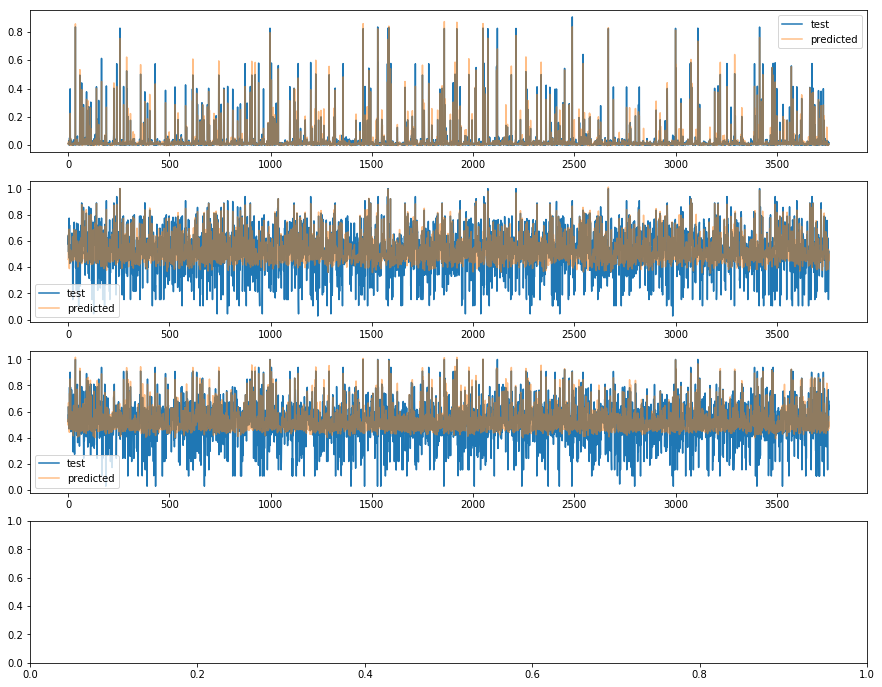

In [62]:
fig, ax = plt.subplots(4,figsize=(15,12))
for i in range(0,3):
    ax[i].plot(y_test[:,i],label = 'test')
    ax[i].plot(y_pr[0][:,i], label = 'predicted',alpha=.5)
    ax[i].legend(loc='best')